In [1]:
import os
import similaritymeasures
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.neighbors import DistanceMetric
import seaborn as sns
from scipy.spatial import minkowski_distance

import pandas as pd

import pylab

In [2]:
def nDTW(exp_data,num_data,d_th=3,p=2):
    r"""
    Parameters
    ----------
    exp_data: list
        experimental trajectory
    num_data: list
        reference trajectory
    d_th: float
        threshold distance for task completion
    p : float, 1 <= p <= infinity
        Which Minkowski p-norm to use. Default is p=2 (Eculidean).
        The manhattan distance is p=1.        
    Returns
    -------
    ndtw : float
        normalized dynamic time warping distance
    """
    dtw = np.ones((len(exp_data)+1,len(num_data)+1))*np.inf
    dtw[0,0] = 0
    for i in range(1,len(exp_data)+1):
        for j in range(1,len(num_data)+1):
            cost = minkowski_distance(exp_data[i-1],num_data[j-1],p=p)
            dtw[i,j] = cost+np.min([dtw[i-1,j],dtw[i,j-1],dtw[i-1,j-1]])
    DTW = dtw[len(exp_data),len(num_data)]
    ndtw = np.exp(-DTW/(len(num_data)*d_th))
    return ndtw

In [3]:
def TC(exp_data,num_data,d_th=3,p=2):
    r"""
    Parameters
    ----------
    exp_data: list
        experimental trajectory
    num_data: list
        reference trajectory
    d_th: float [default = 3 (meters)]
        threshold distance for task completion
    p : float, 1 <= p <= infinity
        Which Minkowski p-norm to use. Default is p=2 (Eculidean).
        The manhattan distance is p=1.        
    Returns
    -------
    tc : bool
        Task Completion score
    """
    return minkowski_distance(exp_data[-1],num_data[-1],p=p)<=d_th
    

In [4]:
def ade_matching(exp_data, num_data, p=2):
    r"""
    Compute the ADE by using matching used in Discrete Frechet Distance
    Compute the ADE between two N-D curves according to matching in
    [1]_. The Frechet distance has been defined as the walking dog problem.
    From Wikipedia: "In mathematics, the Frechet distance is a measure of
    similarity between curves that takes into account the location and
    ordering of the points along the curves. It is named after Maurice Frechet.
    https://en.wikipedia.org/wiki/Fr%C3%A9chet_distance
    Parameters
    ----------
    exp_data : array_like
        Curve from your experimental data. exp_data is of (M, N) shape, where
        M is the number of data points, and N is the number of dimmensions
    num_data : array_like
        Curve from your numerical data. num_data is of (P, N) shape, where P
        is the number of data points, and N is the number of dimmensions
    p : float, 1 <= p <= infinity
        Which Minkowski p-norm to use. Default is p=2 (Eculidean).
        The manhattan distance is p=1.
    Returns
    -------
    df : float
        discrete Frechet distance
    References
    ----------
    .. [1] Thomas Eiter and Heikki Mannila. Computing discrete Frechet
        distance. Technical report, 1994.
        http://www.kr.tuwien.ac.at/staff/eiter/et-archive/cdtr9464.pdf
        http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.90.937&rep=rep1&type=pdf
    """
    n = len(exp_data)
    m = len(num_data)
    ca = np.ones((n, m))
    ca = np.multiply(ca, -1)
    ca[0, 0] = minkowski_distance(exp_data[0], num_data[0], p=p)
    for i in range(1, n):
        ca[i, 0] = ca[i-1, 0]+ minkowski_distance(exp_data[i], num_data[0],
                                                      p=p)
    for j in range(1, m):
        ca[0, j] = ca[0, j-1]+ minkowski_distance(exp_data[0], num_data[j],
                                                      p=p)
    for i in range(1, n):
        for j in range(1, m):
            ca[i, j] = min(ca[i-1, j], ca[i, j-1], ca[i-1, j-1])+minkowski_distance(exp_data[i], num_data[j], p=p)
    return ca[n-1, m-1]/max(n,m)



In [5]:
def get_commands(val_path):
    commands = []
    for episode in os.listdir(val_path):
        filename = os.path.join(val_path,episode,'command.txt')
        with open(filename,'r') as f:
            command = f.readline().strip()
            commands.append(command)
    return commands

In [6]:
def get_scores(val_data_path, val_run_path, save_loc, episodes = None,subplots = False):
    os.makedirs(save_loc,exist_ok=True)
    frechet_dists = []
    fde_dists = []
    ade_dists = []
    ade_match_dists = []
    ndtw_dists = []
    tc_dists = []
    if episodes is None:
        episodes = list(range(50))
    if subplots != False:
        fig = plt.figure(figsize=(10,5))
        handles = []
        labels = []
    for i,episode in enumerate(episodes):
        if subplots != False:
            plt.subplot(subplots[i])
            print('subplotting')
        else:
            plt.figure(figsize=(10,10))
        episode = str(episode)
        filename = os.path.join(val_run_path,episode,'vehicle_positions.txt')
        with open(filename,'r') as f:
            positions = f.readlines()
        run_traj = np.array([ [ float(t.strip()) for t in x.strip().split(',')] for x in positions])

        filename = os.path.join(val_data_path,episode,'vehicle_positions.txt')
        with open(filename,'r') as f:
            positions = f.readlines()
        data_traj = np.array([ [ float(t.strip()) for t in x.strip().split(',')] for x in positions])

        filename = os.path.join(val_run_path,episode,'command.txt')
        with open(filename,'r') as f:
            command = f.readline().strip()

        plt.plot(data_traj[:,0],data_traj[:,1],label='Ground Truth')
        plt.plot(run_traj[:,0],run_traj[:,1],label='Inference on Prediction')
        plt.scatter(data_traj[-1,0],data_traj[-1,1],s=100,label='Ground Truth - End Point')
        plt.scatter(run_traj[-1,0],run_traj[-1,1],s=100,label='Inference - End Point')
        plt.scatter(data_traj[0,0],data_traj[0,1],s=100,label='Starting Point')

        x_min = np.min(np.hstack([data_traj[:,0],run_traj[:,0]]))
        y_min = np.min(np.hstack([data_traj[:,1],run_traj[:,1]]))

        x_max = np.max(np.hstack([data_traj[:,0],run_traj[:,0]]))
        y_max = np.max(np.hstack([data_traj[:,1],run_traj[:,1]]))

        frechet_dists.append(similaritymeasures.frechet_dist(run_traj,data_traj))
        
        min_length = min(run_traj.shape[0],data_traj.shape[0])
        
        r_idx = np.arange(1,run_traj.shape[0]-1)
        np.random.shuffle(r_idx)
        r_idx = [0]+r_idx[:min_length-2].tolist()+[run_traj.shape[0]-1]
        r_idx = sorted(r_idx)
        run_traj_trimmed = run_traj[r_idx]

        d_idx = np.arange(1,data_traj.shape[0]-1)
        np.random.shuffle(d_idx)
        d_idx = [0]+d_idx[:min_length-2].tolist()+[data_traj.shape[0]-1]
        d_idx = sorted(d_idx)
        data_traj_trimmed = data_traj[d_idx]
        print(data_traj_trimmed.shape,run_traj_trimmed.shape)
        
        distances = np.sqrt(np.sum((data_traj_trimmed-run_traj_trimmed)**2,axis=1))
        ade = np.sum(distances)/min_length
        ade_dists.append(ade)
        
        ade_match_dists.append(ade_matching(run_traj,data_traj))

        ndtw_dists.append(nDTW(run_traj,data_traj,5,2))
        tc_dists.append(TC(run_traj,data_traj,5,2))

        fde_dists.append(similaritymeasures.distance.euclidean(data_traj[-1,:],run_traj[-1,:]))
        
        size = max(x_max-x_min+10,y_max-y_min+10)
        if x_max-x_min>y_max-y_min:
            excess_size = size-(y_max-y_min)
            excess_size/=2
            plt.xlim(x_min-5, x_max+5)
            plt.ylim(y_min-excess_size, y_max+excess_size)
        else:
            excess_size = size-(x_max-x_min)
            excess_size/=2
            plt.xlim(x_min-excess_size, x_max+excess_size)
            plt.ylim(y_min-5, y_max+5)
        plt.gca().invert_xaxis()
        plt.gca().set_aspect('equal')
        plt.axis('off')
        plt.title(command)

#         plt.legend()
        if subplots == False:
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=2)
            plt.savefig(os.path.join(save_loc,episode)+'.png') 
        
        print(f'Episode {episode}: {command}')
        print(f'Frechet Distance: {frechet_dists[-1]}')
        print(f'FDE Distance: {fde_dists[-1]}')
        print(f'ADE Distance: {ade_dists[-1]}')
        print(f'ADE Matched Distance: {ade_match_dists[-1]}')
        print(f'nDTW Distance: {ndtw_dists[-1]}')
        print(f'TC Distance: {tc_dists[-1]}')
    #     print(f'Curve Length Measure: {cl_measures[-1]}')
        if subplots == False:
            plt.show()
    if subplots != False:
        lines_labels = [ ax.get_legend_handles_labels() for ax in fig.axes]
        lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
        lines = lines[:5]
        labels = labels[:5]
#         fig.legend(lines, labels)
        
        print(lines,labels)
        
        fig.legend(lines,labels,loc='upper center', bbox_to_anchor=(0.5, 0.15),
          fancybox=True, shadow=True, ncol=2)
        plt.savefig(os.path.join(save_loc,'final')+'.png') 
        plt.show()
        
    return frechet_dists, fde_dists, ade_dists, ade_match_dists, ndtw_dists, tc_dists

In [14]:
def get_scores_comp(val_data_path, val_run_paths, names, save_loc, episodes = None,subplots = False):
    os.makedirs(save_loc,exist_ok=True)
    frechet_dists = []
    fde_dists = []
    ade_dists = []
    ade_match_dists = []
    ndtw_dists = []
    tc_dists = []
    if episodes is None:
        episodes = list(range(50))
    if subplots != False:
        fig = plt.figure(figsize=(10,5))
        handles = []
        labels = []
    for i,episode in enumerate(episodes):
        if subplots != False:
            plt.subplot(subplots[i])
            print('subplotting')
        else:
            plt.figure(figsize=(10,10))
        episode = str(episode)

        filename = os.path.join(val_data_path,episode,'vehicle_positions.txt')
        with open(filename,'r') as f:
            positions = f.readlines()
        data_traj = np.array([ [ float(t.strip()) for t in x.strip().split(',')] for x in positions])
        plt.plot(data_traj[:,0],data_traj[:,1],label='Ground Truth')
        plt.scatter(data_traj[-1,0],data_traj[-1,1],s=100,label='Ground Truth - End Point')
        plt.scatter(data_traj[0,0],data_traj[0,1],s=100,label='Starting Point',color='yellow')
        
        filename = os.path.join(val_data_path,episode,'command.txt')
        with open(filename,'r') as f:
            command = f.readline().strip()

        print(f'Episode {episode}: {command}')
        
        run_trajs = []

        for idx,val_run_path in enumerate(val_run_paths):
        
            filename = os.path.join(val_run_path,episode,'vehicle_positions.txt')
            with open(filename,'r') as f:
                positions = f.readlines()
                
            run_traj = np.array([ [ float(t.strip()) for t in x.strip().split(',')] for x in positions])
            run_trajs.append(run_traj)

            plt.plot(run_traj[:,0],run_traj[:,1],label=f'Inference({names[idx]}) on Prediction')
            plt.scatter(run_traj[-1,0],run_traj[-1,1],s=100,label=f'Inference({names[idx]}) - End Point')


            frechet_dists.append(similaritymeasures.frechet_dist(run_traj,data_traj))
        
            min_length = min(run_traj.shape[0],data_traj.shape[0])

            r_idx = np.arange(1,run_traj.shape[0]-1)
            np.random.shuffle(r_idx)
            r_idx = [0]+r_idx[:min_length-2].tolist()+[run_traj.shape[0]-1]
            r_idx = sorted(r_idx)
            run_traj_trimmed = run_traj[r_idx]

            d_idx = np.arange(1,data_traj.shape[0]-1)
            np.random.shuffle(d_idx)
            d_idx = [0]+d_idx[:min_length-2].tolist()+[data_traj.shape[0]-1]
            d_idx = sorted(d_idx)
            data_traj_trimmed = data_traj[d_idx]
            print(data_traj_trimmed.shape,run_traj_trimmed.shape)

            distances = np.sqrt(np.sum((data_traj_trimmed-run_traj_trimmed)**2,axis=1))
            ade = np.sum(distances)/min_length
            ade_dists.append(ade)

            ade_match_dists.append(ade_matching(run_traj,data_traj))

            ndtw_dists.append(nDTW(run_traj,data_traj,5,2))
            tc_dists.append(TC(run_traj,data_traj,5,2))

            fde_dists.append(similaritymeasures.distance.euclidean(data_traj[-1,:],run_traj[-1,:]))
            
            print(f'{names[idx]}')

            print(f'Frechet Distance: {frechet_dists[-1]}')
            print(f'FDE Distance: {fde_dists[-1]}')
            print(f'ADE Distance: {ade_dists[-1]}')
            print(f'ADE Matched Distance: {ade_match_dists[-1]}')
            print(f'nDTW Distance: {ndtw_dists[-1]}')
            print(f'TC Distance: {tc_dists[-1]}')
        
        all_traj = np.concatenate(run_trajs,axis=0)
        

        x_min = np.min(np.hstack([data_traj[:,0],all_traj[:,0]]))
        y_min = np.min(np.hstack([data_traj[:,1],all_traj[:,1]]))

        x_max = np.max(np.hstack([data_traj[:,0],all_traj[:,0]]))
        y_max = np.max(np.hstack([data_traj[:,1],all_traj[:,1]]))

        
        size = max(x_max-x_min+10,y_max-y_min+10)
        if x_max-x_min>y_max-y_min:
            excess_size = size-(y_max-y_min)
            excess_size/=2
            plt.xlim(x_min-5, x_max+5)
            plt.ylim(y_min-excess_size, y_max+excess_size)
        else:
            excess_size = size-(x_max-x_min)
            excess_size/=2
            plt.xlim(x_min-excess_size, x_max+excess_size)
            plt.ylim(y_min-5, y_max+5)
        plt.gca().invert_xaxis()
        plt.gca().set_aspect('equal')
        plt.axis('off')
        plt.title(command)

#         plt.legend()
        if subplots == False:
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=2)
            plt.savefig(os.path.join(save_loc,episode)+'.png') 
        
#         print(f'Episode {episode}: {command}')
#         print(f'Frechet Distance: {frechet_dists[-1]}')
#         print(f'FDE Distance: {fde_dists[-1]}')
#         print(f'ADE Distance: {ade_dists[-1]}')
#         print(f'ADE Matched Distance: {ade_match_dists[-1]}')
#         print(f'nDTW Distance: {ndtw_dists[-1]}')
#         print(f'TC Distance: {tc_dists[-1]}')
    #     print(f'Curve Length Measure: {cl_measures[-1]}')
        if subplots == False:
            plt.show()
    if subplots != False:
        lines_labels = [ ax.get_legend_handles_labels() for ax in fig.axes]
        lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
        lines = lines[:1+2+2*len(names)]
        labels = labels[:1+2+2*len(names)]
#         fig.legend(lines, labels)
        
        print(lines,labels)
        

        fig.legend(lines,labels,loc='upper center', bbox_to_anchor=(0.5, 0.15),
          fancybox=True, shadow=True, ncol=2)
        plt.savefig(os.path.join(save_loc,'final')+'.png') 
        plt.show()
        import pylab

        fig2 = pylab.figure()
        figlegend = pylab.figure(figsize=(15,10))
        ax = fig.add_subplot(111)
        figlegend.legend(lines,labels,loc='center', #bbox_to_anchor=(0.5, 0.15),
          fancybox=True, shadow=True, ncol=2)
        fig2.show()
        figlegend.show()
        figlegend.savefig(os.path.join(save_loc,'legend')+'.png')
        
    return frechet_dists, fde_dists, ade_dists, ade_match_dists, ndtw_dists, tc_dists

In [8]:
def deinterlace(l: list, names: list, df=True, tc_scores = None):
    if tc_scores is not None:
        diction = {name:pd.Series(l[idx::len(names)]).where(
                            np.array(tc_scores[idx::len(names)],dtype=bool)
                            ) 
                   for idx,name in enumerate(names)}
    else:
        diction = {name:pd.Series(l[idx::len(names)]) for idx,name in enumerate(names)}

    if df:
        return pd.DataFrame(diction)
    else:
        return diction

In [9]:
# ! scp varunc@ada:/share3/varunc/val_runs.zip /ssd_scratch/cvit/varunc
# ! unzip /ssd_scratch/cvit/varunc/val_runs.zip
# ! scp varunc@ada:/share3/varunc/val_run_baseline.zip /ssd_scratch/cvit/varunc
# ! unzip /ssd_scratch/cvit/varunc/val_run_baseline.zip
# ! scp varunc@ada:/share3/varunc/val_convlstm.zip /ssd_scratch/cvit/varunc
# ! scp varunc@ada:/share3/varunc/val_framebyframe.zip /ssd_scratch/cvit/varunc
# ! scp varunc@ada:/share3/varunc/val_fbf2.zip /ssd_scratch/cvit/varunc
# ! scp varunc@ada:/share3/varunc/val_temp_convattn.zip /ssd_scratch/cvit/varunc
# ! scp varunc@ada:/share3/varunc/val_run_fbf_network2.zip /ssd_scratch/cvit/varunc
# ! scp varunc@ada:/share3/varunc/val_dual2_fbf_mask.zip /ssd_scratch/cvit/varunc
# unzip /ssd_scratch/cvit/varunc/val_convlstm.zip

scp varunc@ada:/share3/varunc/val_runs.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_runs.zip
scp varunc@ada:/share3/varunc/val_run_baseline.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_run_baseline.zip
scp varunc@ada:/share3/varunc/val_convlstm.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_convlstm.zip
scp varunc@ada:/share3/varunc/val_framebyframe.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_framebyframe.zip
scp varunc@ada:/share3/varunc/val_fbf2.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_fbf2.zip
scp varunc@ada:/share3/varunc/val_temp_convattn.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_temp_convattn.zip
scp varunc@ada:/share3/varunc/val_run_fbf_network2.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_run_fbf_network2.zip

scp varunc@ada:/share3/varunc/val_dual_fgf_mask.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_dual_fgf_mask.zip
scp varunc@ada:/share3/varunc/val_dual_fgf_trajectory.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_dual_fgf_trajectory.zip


(58, 3) (58, 3)
Episode 0: Stop before the next right turn.
Frechet Distance: 9.352273425947534
FDE Distance: 9.352273425947535
ADE Distance: 2.933344821623711
ADE Matched Distance: 0.8037949566762956
nDTW Distance: 0.6897619753816066
TC Distance: False


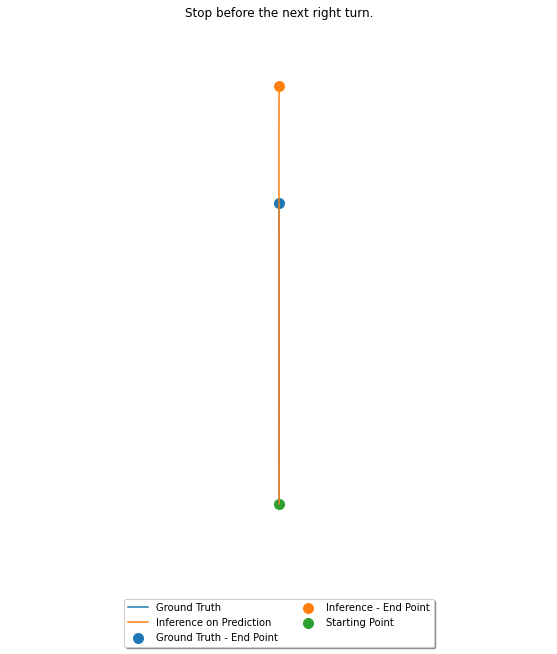

(45, 3) (45, 3)
Episode 1: After crossing the blue car come to a stop
Frechet Distance: 6.052745304516535
FDE Distance: 6.052745304516535
ADE Distance: 10.617043457844778
ADE Matched Distance: 3.9362879097158845
nDTW Distance: 0.03242115507997238
TC Distance: False


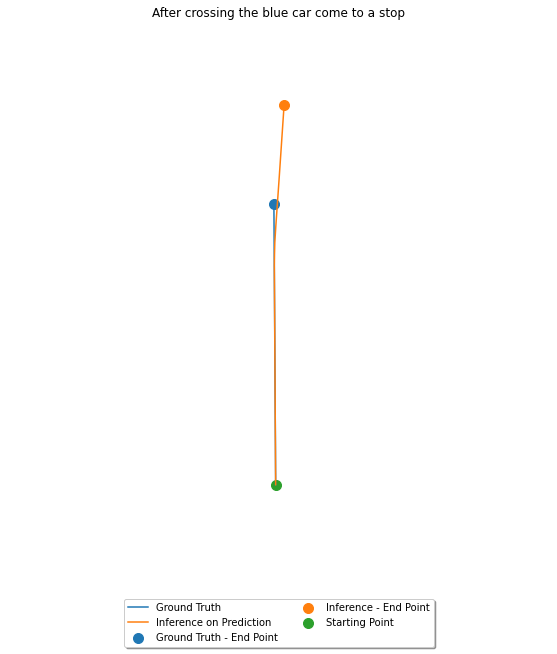

(109, 3) (109, 3)
Episode 2: stop beside the black suv
Frechet Distance: 18.428143984548306
FDE Distance: 18.428143984548306
ADE Distance: 14.357298049806587
ADE Matched Distance: 4.173968521337086
nDTW Distance: 0.004029013819113299
TC Distance: False


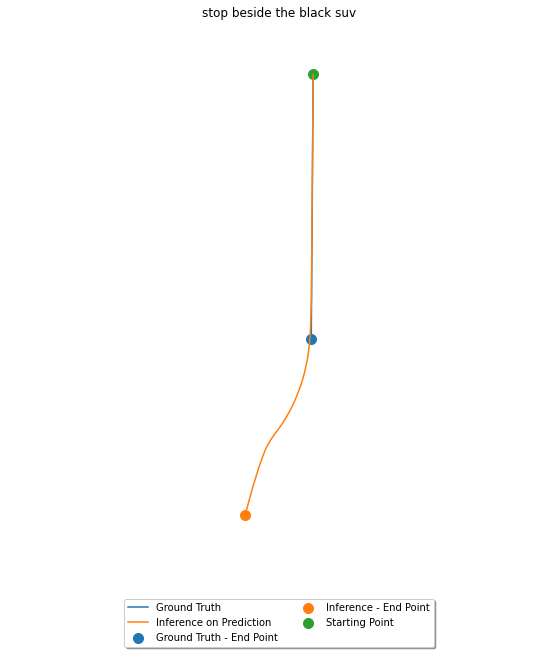

(38, 3) (38, 3)
Episode 3: Stop near the signboard
Frechet Distance: 7.196554230376918
FDE Distance: 7.196554230376918
ADE Distance: 7.593532934974429
ADE Matched Distance: 3.9815779160594125
nDTW Distance: 0.01362412698888858
TC Distance: False


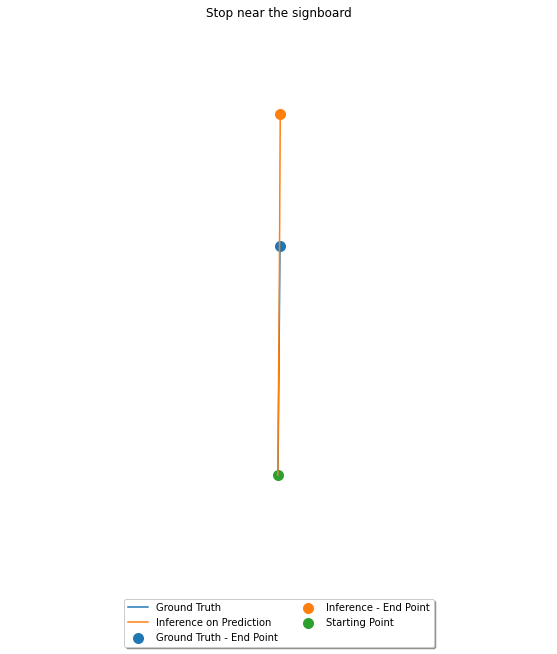

(82, 3) (82, 3)
Episode 4: Take a left at the traffic light
Frechet Distance: 115.12465786413074
FDE Distance: 115.12465786413074
ADE Distance: 82.23345856771756
ADE Matched Distance: 72.34428303213713
nDTW Distance: 4.995427195998022e-184
TC Distance: False


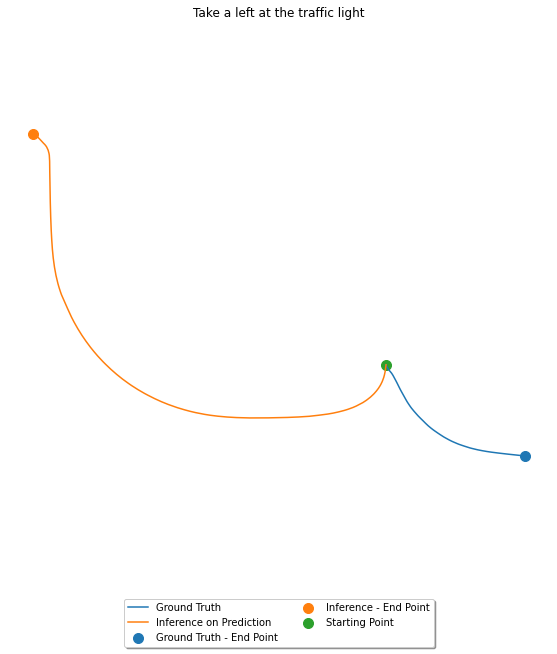

(57, 3) (57, 3)
Episode 5: Turn right from the intersection
Frechet Distance: 22.71675696413467
FDE Distance: 22.71675696413467
ADE Distance: 22.23847020747012
ADE Matched Distance: 11.305373814522637
nDTW Distance: 1.1827990101799537e-05
TC Distance: False


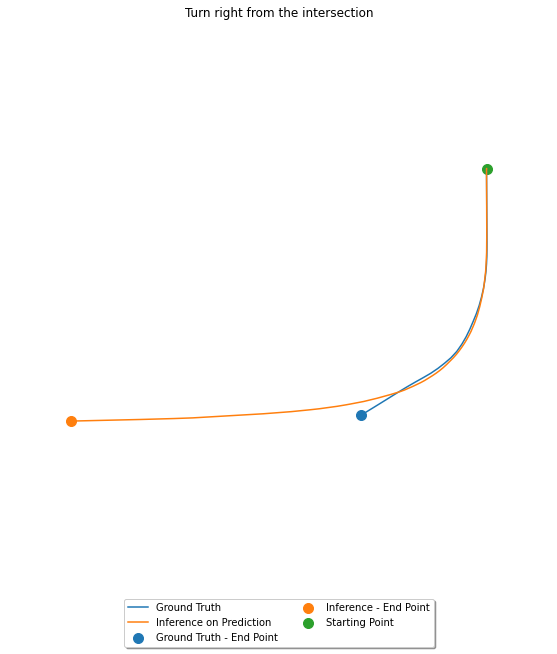

(91, 3) (91, 3)
Episode 6: Take a left from the intersection ahead
Frechet Distance: 6.680357897079284
FDE Distance: 6.680357897079284
ADE Distance: 1.914003610907929
ADE Matched Distance: 0.43201585656864017
nDTW Distance: 0.8114871006900858
TC Distance: False


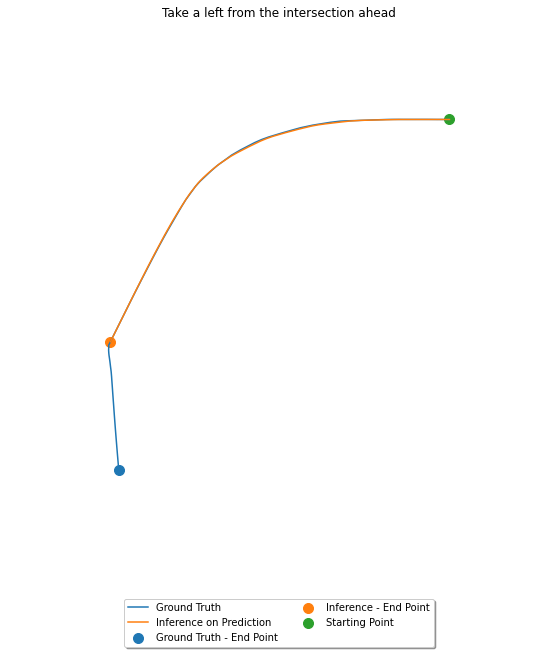

(61, 3) (61, 3)
Episode 7: Drive to the corner and go right
Frechet Distance: 28.433672497040813
FDE Distance: 28.43367249704081
ADE Distance: 11.132000848642779
ADE Matched Distance: 5.156914892243405
nDTW Distance: 0.027751134741194526
TC Distance: False


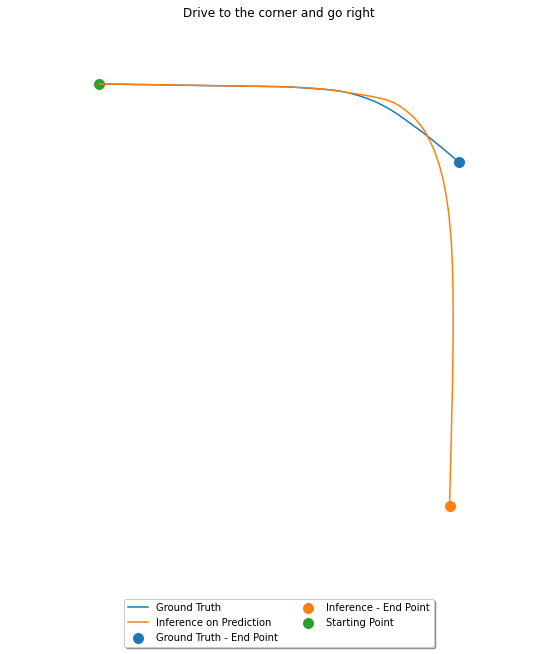

(83, 3) (83, 3)
Episode 8: Drive to the intersection and turn left
Frechet Distance: 15.5578694582314
FDE Distance: 15.5578694582314
ADE Distance: 15.868689231261508
ADE Matched Distance: 7.121627297022158
nDTW Distance: 0.0035933885107066856
TC Distance: False


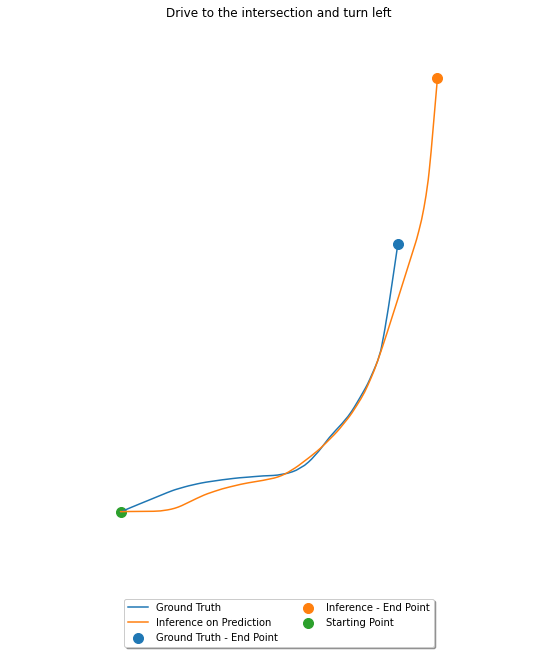

(190, 3) (190, 3)
Episode 9: Go straight and stop a few metres ahead of the bus stop
Frechet Distance: 29.99150957458776
FDE Distance: 29.991509574587756
ADE Distance: 12.836626336974067
ADE Matched Distance: 10.434152202041922
nDTW Distance: 0.10523280296569186
TC Distance: False


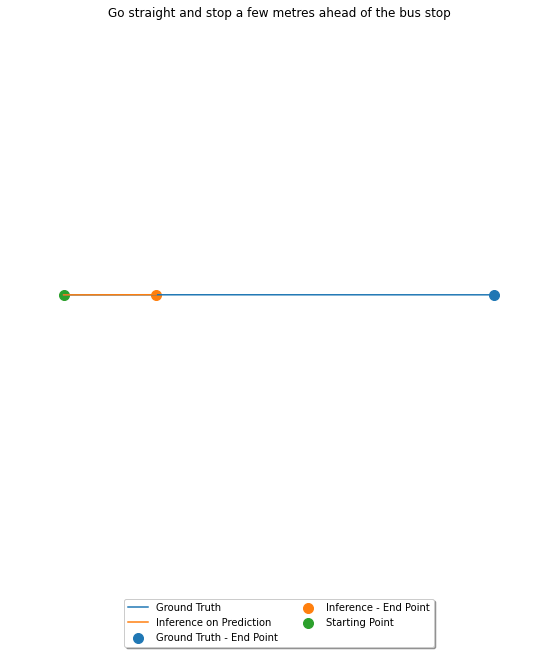

(80, 3) (80, 3)
Episode 10: Stop in front of the garbage dumpsters.
Frechet Distance: 29.750043722911244
FDE Distance: 29.750043722911244
ADE Distance: 14.010780086221212
ADE Matched Distance: 5.024588143866556
nDTW Distance: 0.044367651309329445
TC Distance: False


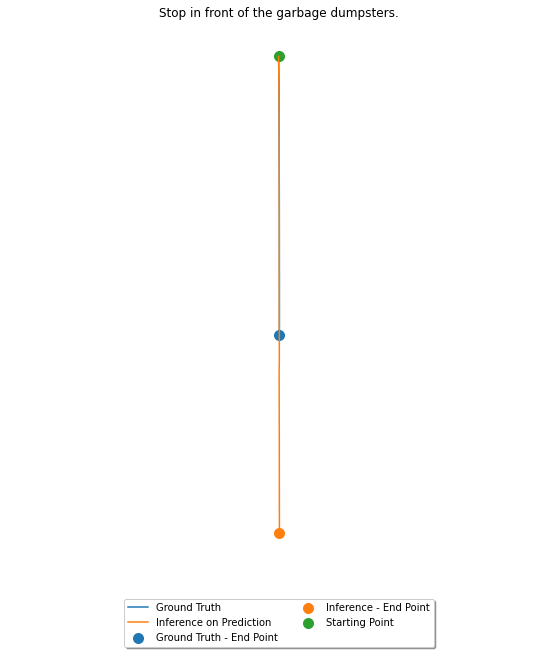

(107, 3) (107, 3)
Episode 11: Go straight and stop next to the grey arch.
Frechet Distance: 74.40491325875722
FDE Distance: 69.7647996262257
ADE Distance: 56.67400962612383
ADE Matched Distance: 48.138106306929984
nDTW Distance: 4.717716981298727e-102
TC Distance: False


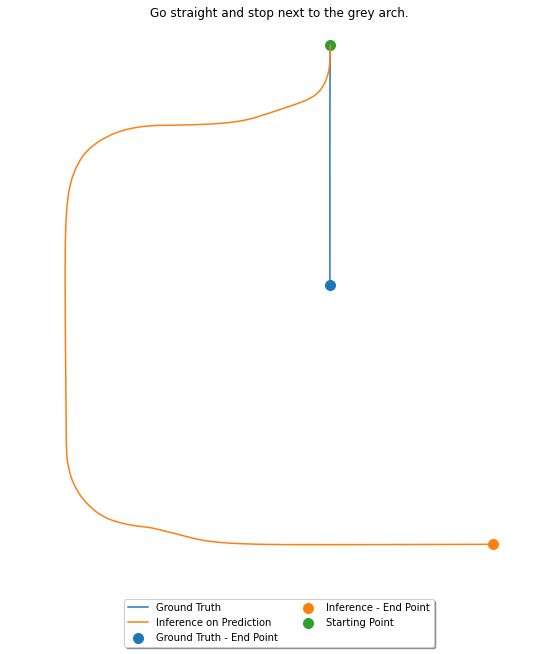

(66, 3) (66, 3)
Episode 12: Change lanes and stop at the junction.
Frechet Distance: 5.509988965578974
FDE Distance: 5.509988965578974
ADE Distance: 5.2308623997520645
ADE Matched Distance: 2.6467445789204356
nDTW Distance: 0.17127302026876007
TC Distance: False


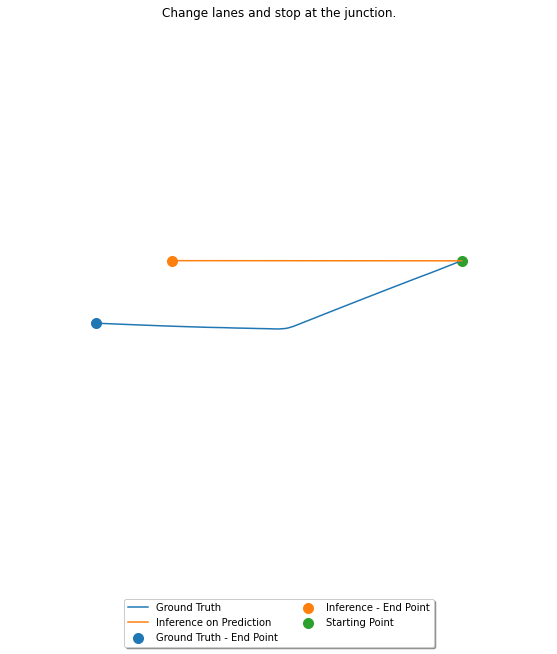

(60, 3) (60, 3)
Episode 13: Park on the roadside after you have crossed the bus stop
Frechet Distance: 6.351822628676438
FDE Distance: 6.351822628676439
ADE Distance: 4.303924837570127
ADE Matched Distance: 0.25417017689261395
nDTW Distance: 0.8139324975320544
TC Distance: False


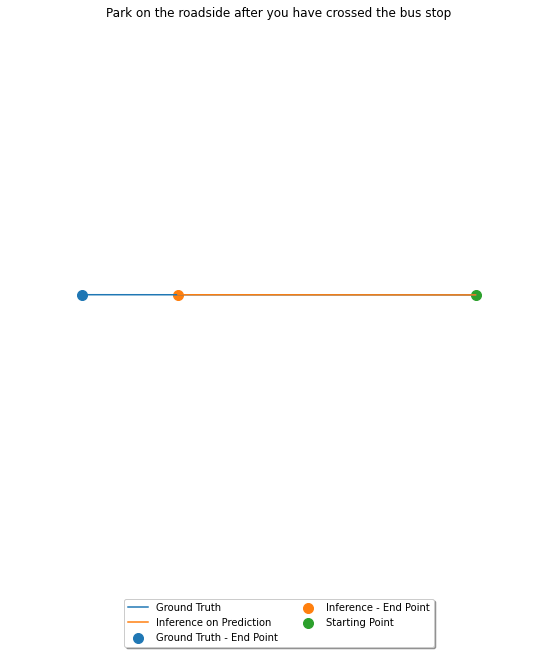

(452, 3) (452, 3)
Episode 14: Wait for the signal to turn green and continue straight
Frechet Distance: 24.18656555699258
FDE Distance: 24.186565556992583
ADE Distance: 3.767599649151517
ADE Matched Distance: 1.0726303039338003
nDTW Distance: 0.7608048880046506
TC Distance: False


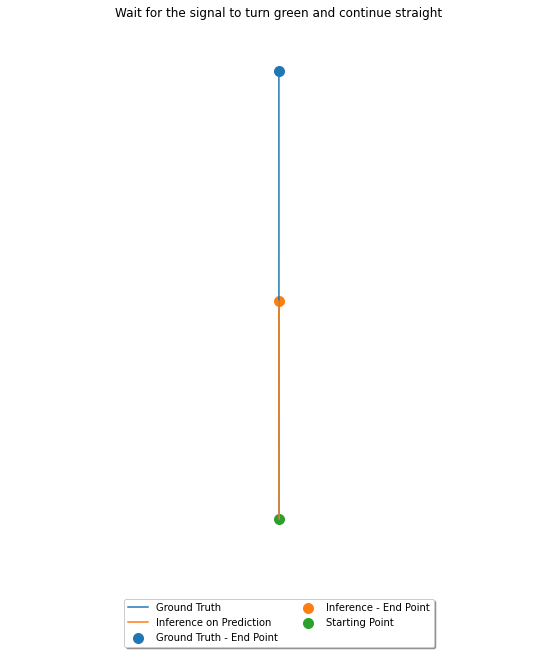

(63, 3) (63, 3)
Episode 15: Drive towards the bus stop and park after crossing it
Frechet Distance: 12.265511845715494
FDE Distance: 12.265511845715492
ADE Distance: 15.44054289003004
ADE Matched Distance: 5.810297987781323
nDTW Distance: 0.004414128813662713
TC Distance: False


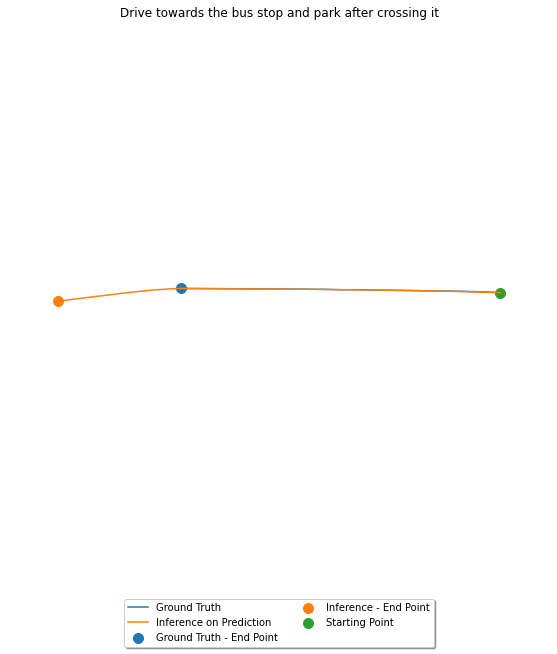

(81, 3) (81, 3)
Episode 16: take a right turn and stop across the bench on left
Frechet Distance: 17.673473443523463
FDE Distance: 17.673473443523463
ADE Distance: 15.667573852818665
ADE Matched Distance: 6.978416328864154
nDTW Distance: 0.0016172383840535173
TC Distance: False


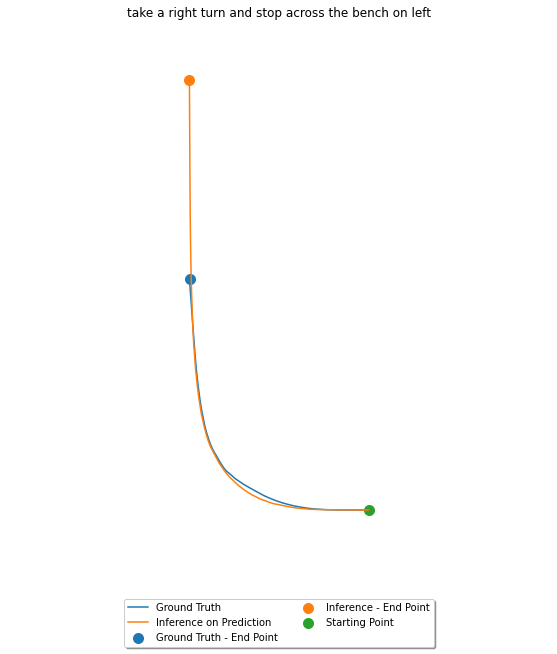

(61, 3) (61, 3)
Episode 17: Turn right from the crossroads ahead
Frechet Distance: 28.597727507566383
FDE Distance: 28.597727507566383
ADE Distance: 20.61712293880494
ADE Matched Distance: 15.8029636471156
nDTW Distance: 3.3067073250530194e-07
TC Distance: False


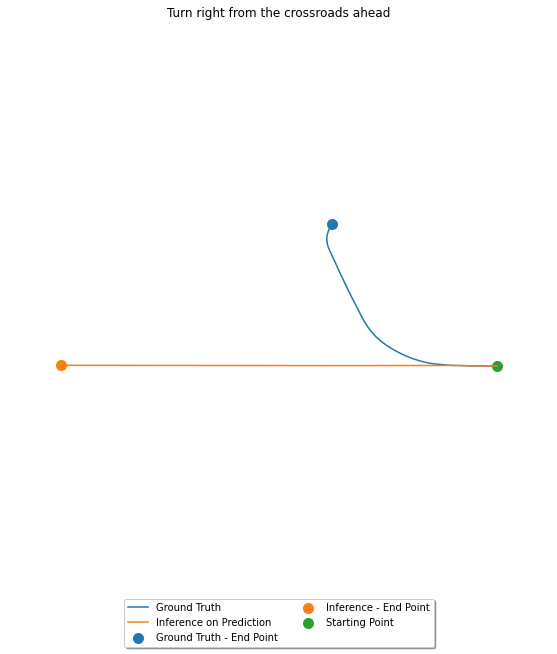

(156, 3) (156, 3)
Episode 18: Turn right and park near the sidewalk.
Frechet Distance: 28.571771139098487
FDE Distance: 28.571771139098487
ADE Distance: 8.939408448091086
ADE Matched Distance: 4.955574456403801
nDTW Distance: 0.2718712636983641
TC Distance: False


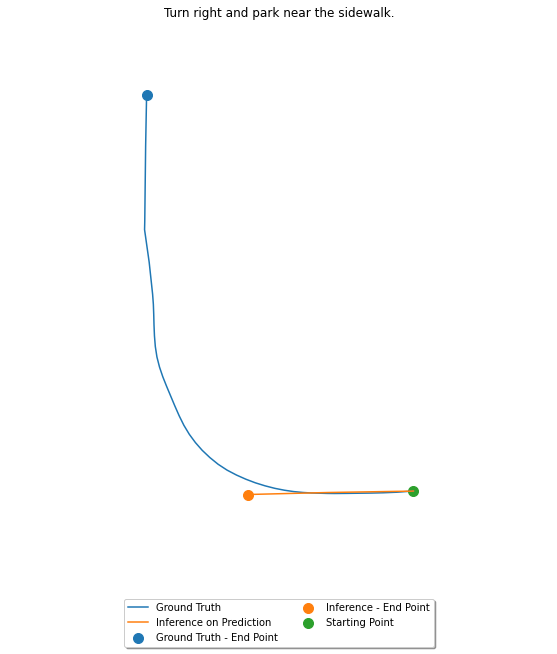

(136, 3) (136, 3)
Episode 19: go straight and take a right
Frechet Distance: 22.189434598855843
FDE Distance: 22.189434598855843
ADE Distance: 6.693935184920725
ADE Matched Distance: 3.2874379321222076
nDTW Distance: 0.36407196771956285
TC Distance: False


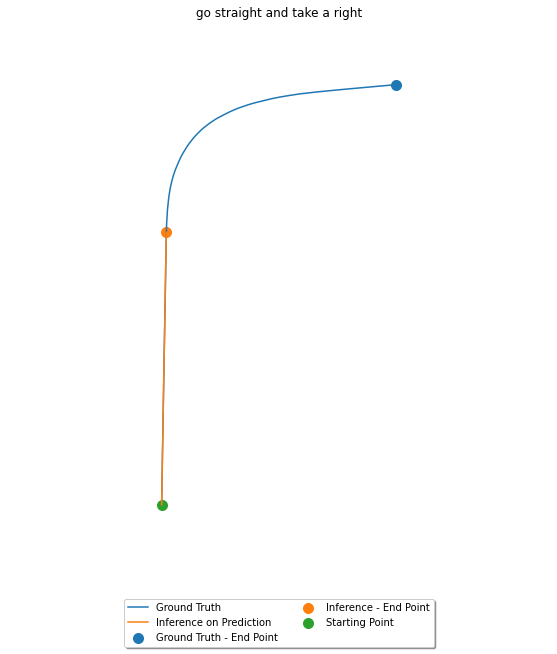

(42, 3) (42, 3)
Episode 20: park beside the red volkswagen
Frechet Distance: 5.89198236190434
FDE Distance: 5.891982361904341
ADE Distance: 10.4988064637684
ADE Matched Distance: 3.406921997234325
nDTW Distance: 0.03314305796057142
TC Distance: False


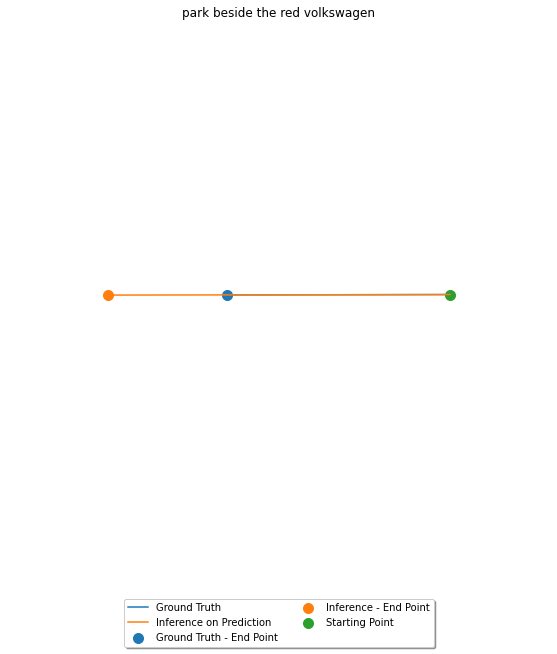

(147, 3) (147, 3)
Episode 21: Turn left from the next crossroads
Frechet Distance: 5.881346752307017
FDE Distance: 5.881346752307017
ADE Distance: 4.406540841429089
ADE Matched Distance: 0.37063523658545267
nDTW Distance: 0.6540368007930779
TC Distance: False


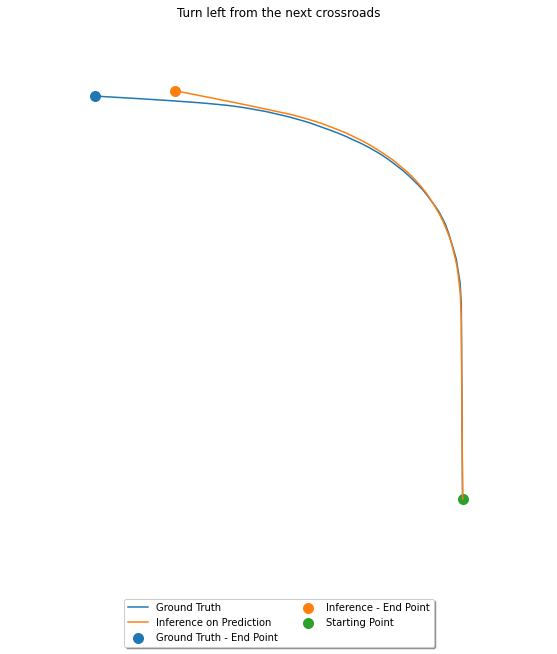

(66, 3) (66, 3)
Episode 22: Turn right from the crossroads.
Frechet Distance: 30.50765832522495
FDE Distance: 30.50765832522495
ADE Distance: 18.489093414688767
ADE Matched Distance: 16.62808996943333
nDTW Distance: 5.241963766332787e-07
TC Distance: False


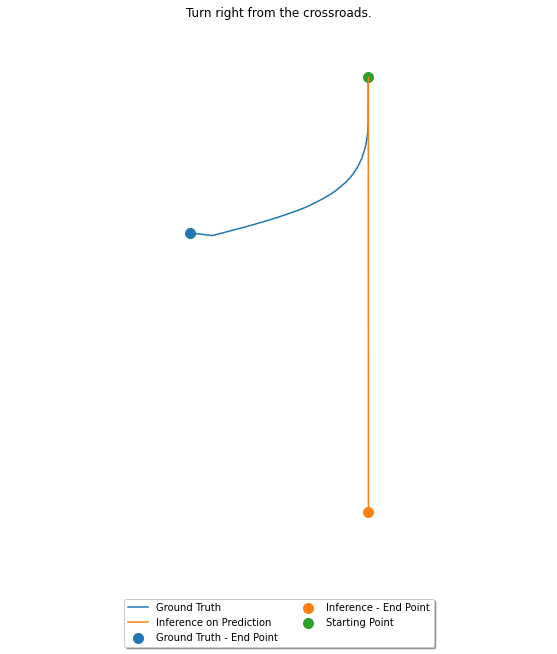

(71, 3) (71, 3)
Episode 23: stop by the lamp post
Frechet Distance: 21.841074858959306
FDE Distance: 21.841074858959306
ADE Distance: 17.859899635041067
ADE Matched Distance: 11.062040230446835
nDTW Distance: 9.27241447414038e-05
TC Distance: False


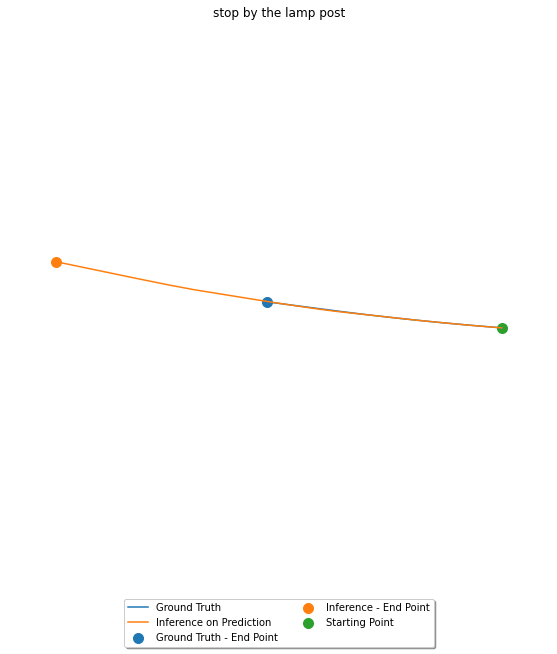

(50, 3) (50, 3)
Episode 24: park immediately after the signboard
Frechet Distance: 7.554308086873363
FDE Distance: 7.5543080868733625
ADE Distance: 8.722378558061257
ADE Matched Distance: 4.157281990162814
nDTW Distance: 0.018176607050848097
TC Distance: False


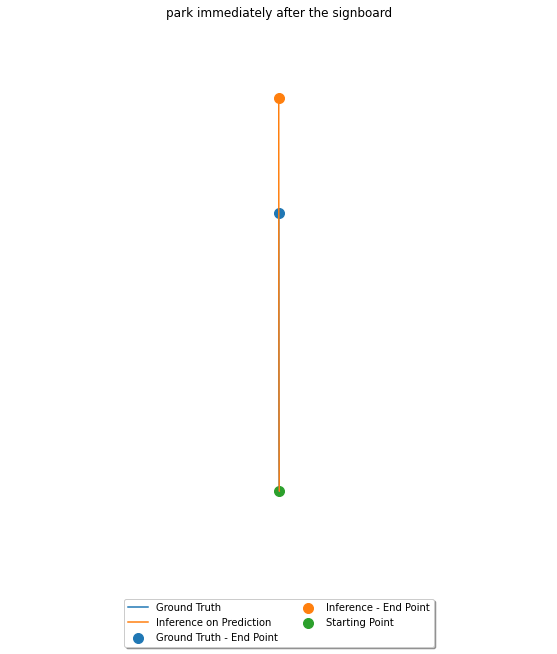

(176, 3) (176, 3)
Episode 25: Turn right and stop beside the traffic signal
Frechet Distance: 18.792091120681075
FDE Distance: 18.792091120681075
ADE Distance: 11.44209971057999
ADE Matched Distance: 1.1476733769800085
nDTW Distance: 0.5866028373919345
TC Distance: False


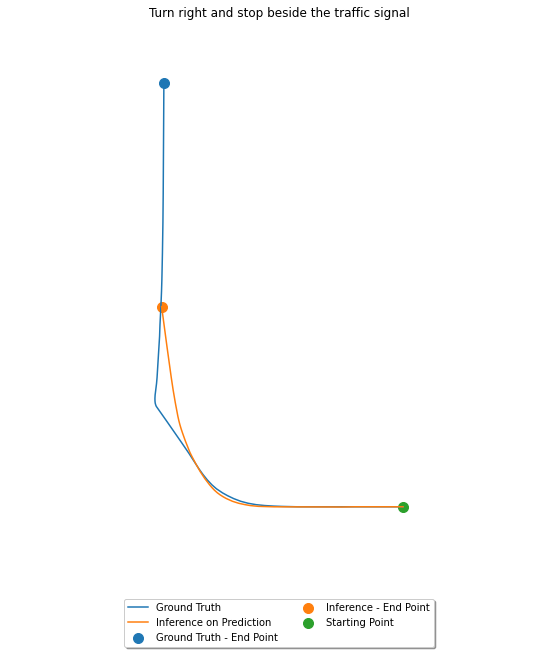

(406, 3) (406, 3)
Episode 26: Turn left and stop near the traffic signal
Frechet Distance: 232.65413297754918
FDE Distance: 232.65413297754918
ADE Distance: 153.32422405042237
ADE Matched Distance: 131.05201380268653
nDTW Distance: 2.172204137771083e-36
TC Distance: False


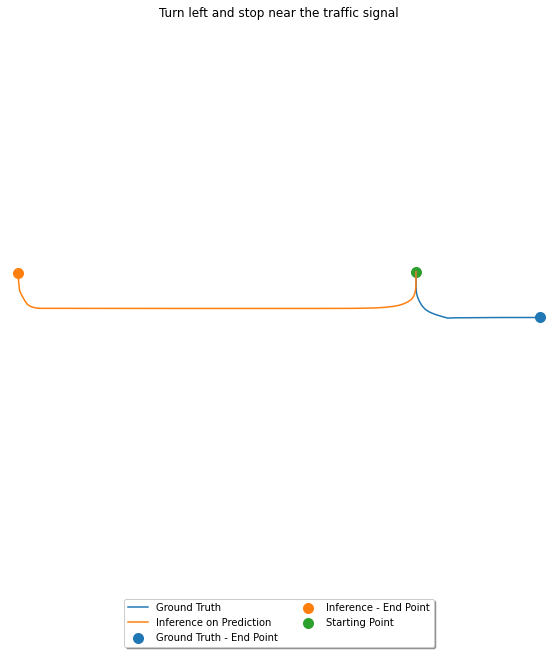

(358, 3) (358, 3)
Episode 27: Turn left and stop near the intersection
Frechet Distance: 46.44827389343058
FDE Distance: 46.44827389343058
ADE Distance: 37.73808769695777
ADE Matched Distance: 26.144705641838076
nDTW Distance: 0.001571313294415269
TC Distance: False


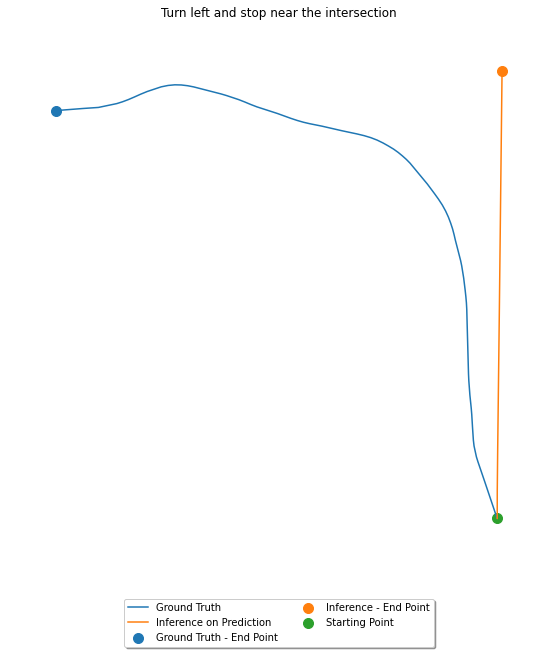

(651, 3) (651, 3)
Episode 28: Turn left and come to a halt at the intersection
Frechet Distance: 1.1568098456576317
FDE Distance: 0.07355157061962017
ADE Distance: 8.116667027250386
ADE Matched Distance: 0.21291063543699182
nDTW Distance: 0.9583117589354389
TC Distance: True


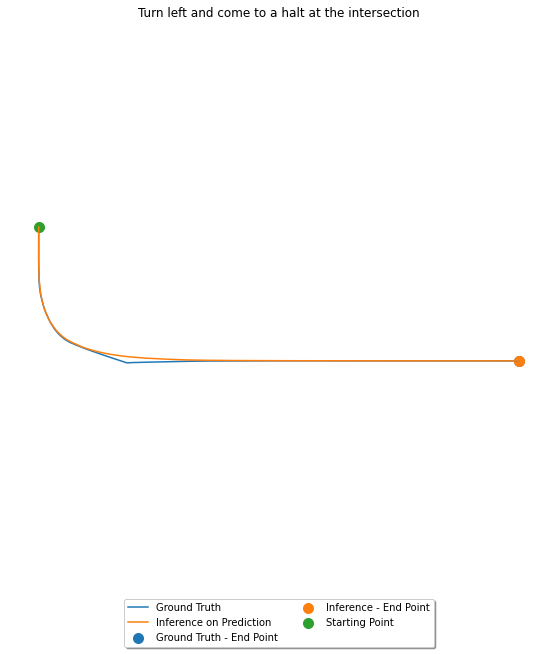

(194, 3) (194, 3)
Episode 29: Turn right and stop before the traffic signal
Frechet Distance: 10.243637139619787
FDE Distance: 10.243637139619787
ADE Distance: 8.258946743687625
ADE Matched Distance: 0.35959956241209945
nDTW Distance: 0.7270062310393396
TC Distance: False


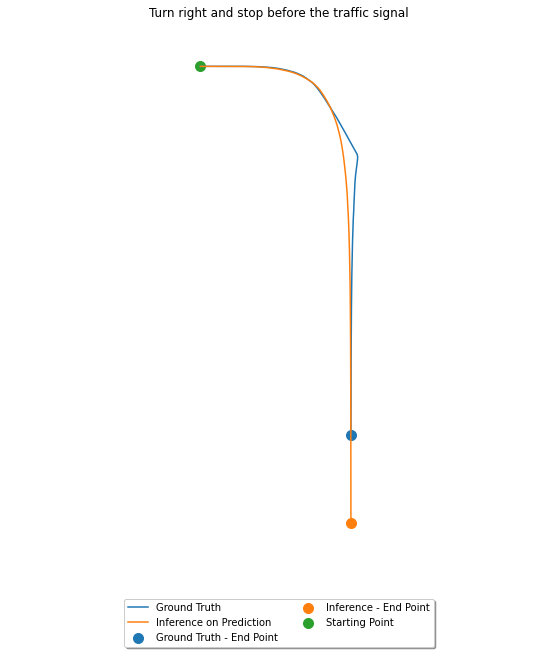

(153, 3) (153, 3)
Episode 30: Turn right and stop just before the traffic signal
Frechet Distance: 16.73428829732003
FDE Distance: 16.73428829732003
ADE Distance: 6.1901109219040675
ADE Matched Distance: 1.8556719428855069
nDTW Distance: 0.44477408673665886
TC Distance: False


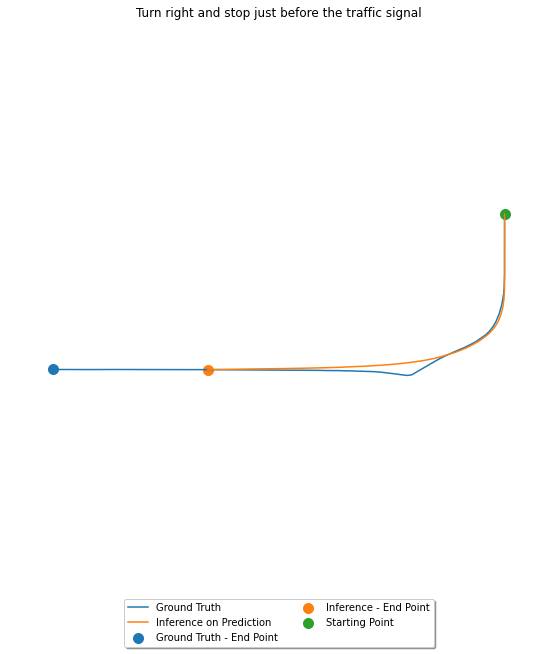

(216, 3) (216, 3)
Episode 31: Turn right and stop near the bus stop
Frechet Distance: 42.35149631092152
FDE Distance: 42.35149631092152
ADE Distance: 16.239377172476992
ADE Matched Distance: 15.122737588239275
nDTW Distance: 0.0005501285086694257
TC Distance: False


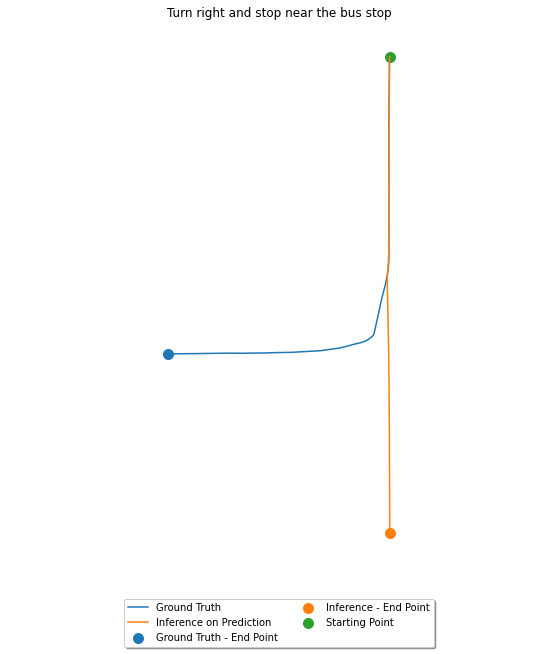

(188, 3) (188, 3)
Episode 32: Turn left and stop beside the traffic signal
Frechet Distance: 44.66966534682112
FDE Distance: 44.66966534682112
ADE Distance: 18.880818138207434
ADE Matched Distance: 3.1887951825002414
nDTW Distance: 0.08903416831454264
TC Distance: False


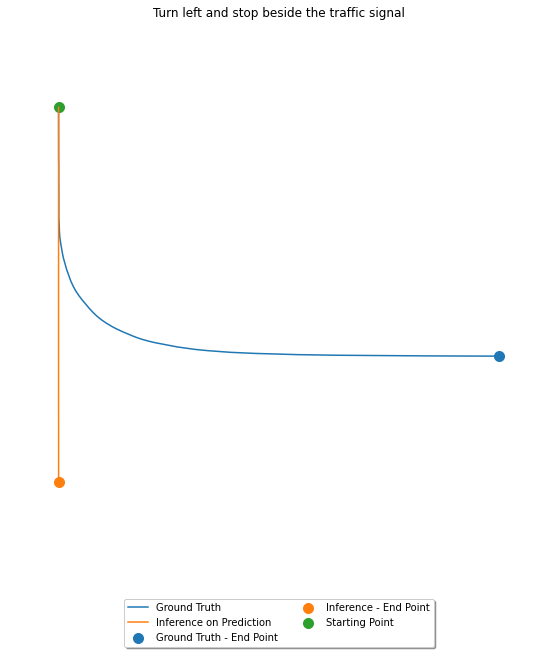

(166, 3) (166, 3)
Episode 33: Turn left and stop near the traffic signal
Frechet Distance: 72.22749939774693
FDE Distance: 72.22749939774694
ADE Distance: 31.200182748069892
ADE Matched Distance: 7.226917916704248
nDTW Distance: 0.0012578281629837243
TC Distance: False


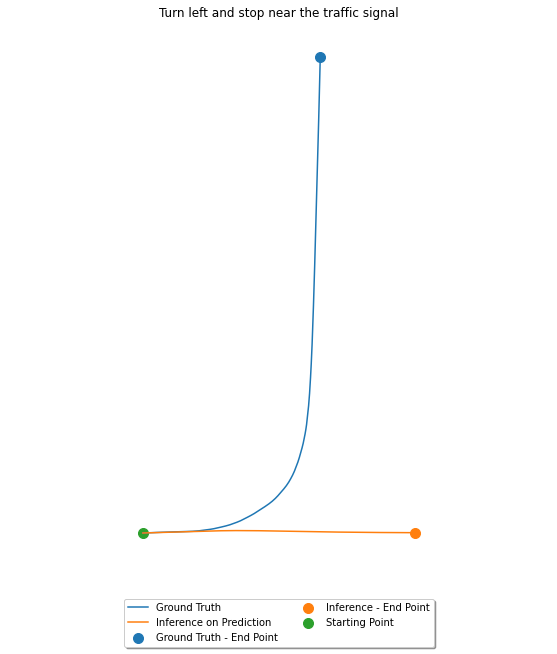

In [11]:
val_data_path = '/ssd_scratch/cvit/varunc/carla_data/test/'
val_run_path = '/ssd_scratch/cvit/varunc/ablation_runs/test_clip6_1/'
save_loc = '../trajectories_test_clip6_1/'

frechet_test_clip_6,fde_test_clip_6,ade_test_clip_6, ade_matched_test_clip_6, ndtw_test_clip_6, tc_test_clip_6 = get_scores(val_data_path, val_run_path, save_loc,episodes=list(range(34)))

Episode 19: Turn left from the intersection
(127, 3) (127, 3)
2 frames
Frechet Distance: 18.331809144225375
FDE Distance: 18.331809144225375
ADE Distance: 7.513835420577466
ADE Matched Distance: 0.7259444796786655
nDTW Distance: 0.5059290114012279
TC Distance: False
(127, 3) (127, 3)
4 frames
Frechet Distance: 14.916772736632765
FDE Distance: 14.916772736632767
ADE Distance: 8.814105263693461
ADE Matched Distance: 0.5089257890411374
nDTW Distance: 0.6192341258442475
TC Distance: False
(127, 3) (127, 3)
6 frames
Frechet Distance: 24.242030081862197
FDE Distance: 24.242030081862197
ADE Distance: 9.288054214055323
ADE Matched Distance: 1.0843842884982282
nDTW Distance: 0.3179499835383651
TC Distance: False
(127, 3) (127, 3)
8 frames
Frechet Distance: 19.09675351070529
FDE Distance: 19.09675351070529
ADE Distance: 7.1265857960689765
ADE Matched Distance: 0.8368438325006397
nDTW Distance: 0.478067181275797
TC Distance: False


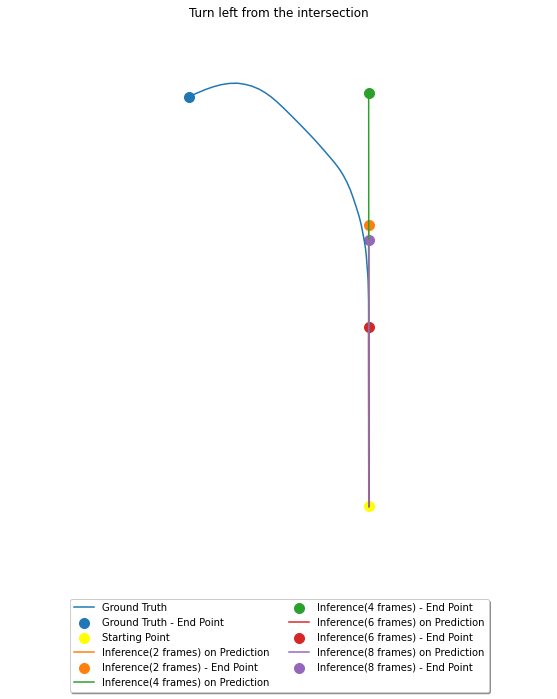

In [27]:
val_data_path = '/ssd_scratch/cvit/varunc/carla_data/val/'
val_run_paths = ['/ssd_scratch/cvit/varunc/ablation_runs/val_clip2/',
                '/ssd_scratch/cvit/varunc/ablation_runs/val_clip4/','/ssd_scratch/cvit/varunc/ablation_runs/val_clip6_1/',
                '/ssd_scratch/cvit/varunc/ablation_runs/val_clip8/']
names = ['2 frames',
        '4 frames','6 frames',
        '8 frames']
save_loc = '../trajectories_temp/'

frechet_temp,fde_temp,ade_temp, ade_matched_temp, ndtw_temp, tc_val_temp = get_scores_comp(val_data_path, val_run_paths,names, save_loc,episodes=list(range(19,20)))

Episode 0: Turn left and stop next to the bus stop.
(393, 3) (393, 3)
1 frame
Frechet Distance: 43.48833991087854
FDE Distance: 43.48833991087854
ADE Distance: 5.161023197925364
ADE Matched Distance: 2.789286829324822
nDTW Distance: 0.5724342680006477
TC Distance: False
(427, 3) (427, 3)
2 frames
Frechet Distance: 47.46580571648844
FDE Distance: 47.46580571648844
ADE Distance: 5.8649699417462395
ADE Matched Distance: 3.4377091199324634
nDTW Distance: 0.5028105479895977
TC Distance: False
(504, 3) (504, 3)
4 frames
Frechet Distance: 43.46868608799014
FDE Distance: 43.46868608799014
ADE Distance: 5.6017948111942095
ADE Matched Distance: 2.871017396899241
nDTW Distance: 0.5631532533880962
TC Distance: False
(531, 3) (531, 3)
6 frames
Frechet Distance: 43.50776725025104
FDE Distance: 43.50776725025104
ADE Distance: 5.369700335591413
ADE Matched Distance: 2.790839379234531
nDTW Distance: 0.5722565490396115
TC Distance: False
(516, 3) (516, 3)
8 frames
Frechet Distance: 43.59922070949818
FDE

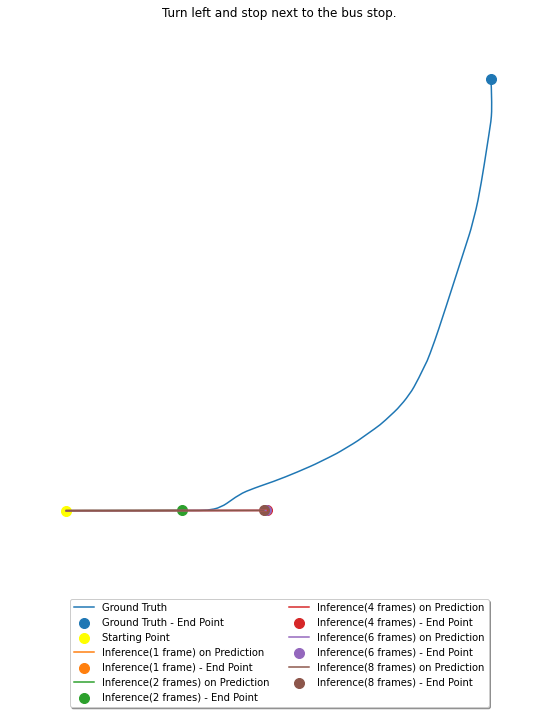

Episode 1: Take a left from the interection.
(94, 3) (94, 3)
1 frame
Frechet Distance: 106.29091110134033
FDE Distance: 17.406330291360916
ADE Distance: 51.478268404009405
ADE Matched Distance: 43.95331323958361
nDTW Distance: 6.549146867757378e-50
TC Distance: False
(94, 3) (94, 3)
2 frames
Frechet Distance: 119.24282603079256
FDE Distance: 119.24282603079256
ADE Distance: 57.41082834668387
ADE Matched Distance: 55.94638948039797
nDTW Distance: 1.1181852491611096e-26
TC Distance: False
(94, 3) (94, 3)
4 frames
Frechet Distance: 183.282468148366
FDE Distance: 183.282468148366
ADE Distance: 104.53387181869348
ADE Matched Distance: 99.95603968992297
nDTW Distance: 6.194946075387888e-118
TC Distance: False
(94, 3) (94, 3)
6 frames
Frechet Distance: 39.817343617314584
FDE Distance: 39.817343617314584
ADE Distance: 16.327832854082455
ADE Matched Distance: 15.063930220529205
nDTW Distance: 7.582587631402106e-05
TC Distance: False
(94, 3) (94, 3)
8 frames
Frechet Distance: 90.3286430671132
FD

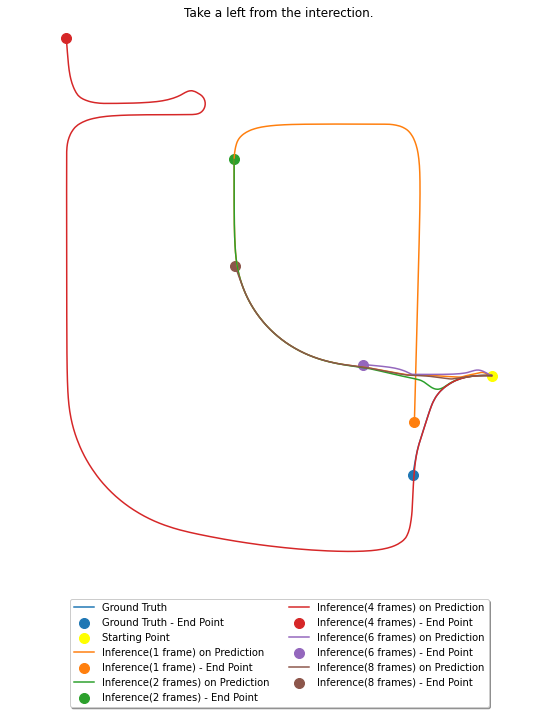

Episode 2: Drive straight till you see a red coloured board
(55, 3) (55, 3)
1 frame
Frechet Distance: 12.925125201716645
FDE Distance: 12.925125201716645
ADE Distance: 5.497867078457033
ADE Matched Distance: 1.5664254227896799
nDTW Distance: 0.6023285443920693
TC Distance: False
(55, 3) (55, 3)
2 frames
Frechet Distance: 12.90295412801413
FDE Distance: 12.90295412801413
ADE Distance: 3.9008302513806106
ADE Matched Distance: 0.762568453658488
nDTW Distance: 0.5937365807784403
TC Distance: False
(55, 3) (55, 3)
4 frames
Frechet Distance: 12.966949495382922
FDE Distance: 12.966949495382922
ADE Distance: 3.9820003697812476
ADE Matched Distance: 0.7553032777009434
nDTW Distance: 0.5950562479210171
TC Distance: False
(55, 3) (55, 3)
6 frames
Frechet Distance: 12.892044134315803
FDE Distance: 12.892044134315803
ADE Distance: 3.6269044677618503
ADE Matched Distance: 0.7758406359297363
nDTW Distance: 0.5933747312193731
TC Distance: False
(55, 3) (55, 3)
8 frames
Frechet Distance: 6.636810318619

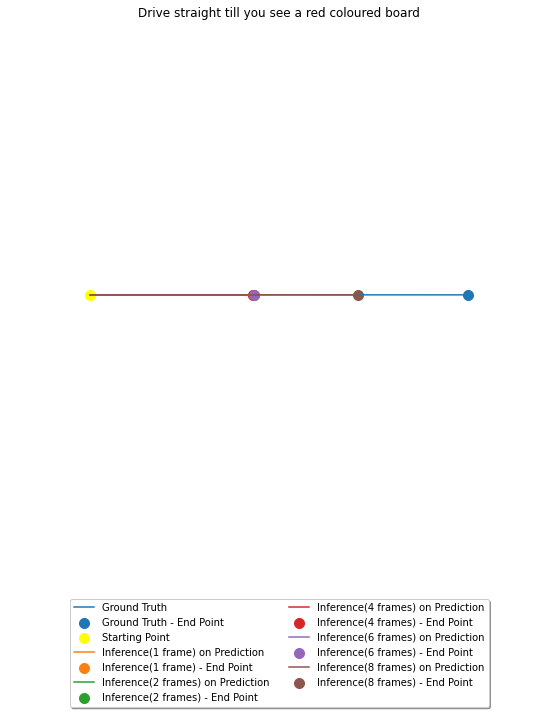

Episode 3: Park just ahead of the speed signboard
(38, 3) (38, 3)
1 frame
Frechet Distance: 7.1529090444940495
FDE Distance: 7.1529090444940495
ADE Distance: 1.849875033613097
ADE Matched Distance: 1.2280507179964184
nDTW Distance: 0.42882402045841683
TC Distance: False
(38, 3) (38, 3)
2 frames
Frechet Distance: 35.653911070333514
FDE Distance: 35.653911070333514
ADE Distance: 16.766331589329784
ADE Matched Distance: 18.600860178597244
nDTW Distance: 6.274648156891729e-13
TC Distance: False
(38, 3) (38, 3)
4 frames
Frechet Distance: 9.809695581651255
FDE Distance: 9.809695581651255
ADE Distance: 7.920431031981653
ADE Matched Distance: 5.729645758544496
nDTW Distance: 0.0012754162308265986
TC Distance: False
(38, 3) (38, 3)
6 frames
Frechet Distance: 6.88822201233072
FDE Distance: 6.88822201233072
ADE Distance: 8.066566795769553
ADE Matched Distance: 3.5603528331766325
nDTW Distance: 0.014211771190537495
TC Distance: False
(38, 3) (38, 3)
8 frames
Frechet Distance: 8.606243838110478
FDE

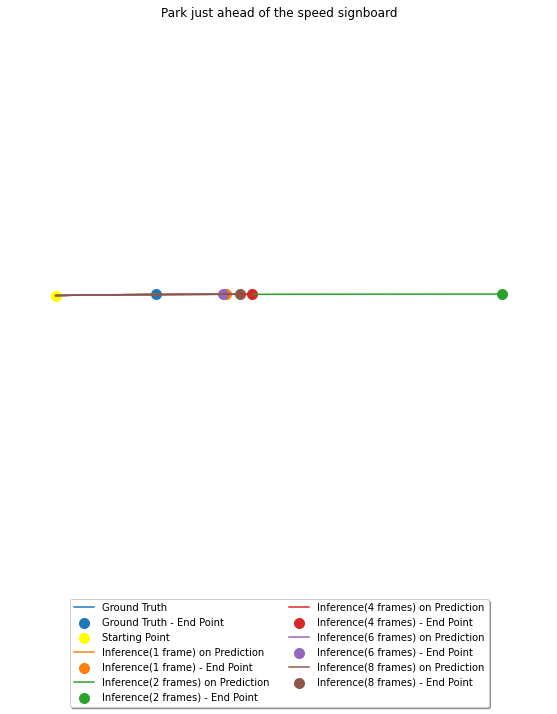

Episode 4: Take the next right turn.
(167, 3) (167, 3)
1 frame
Frechet Distance: 36.53316553604864
FDE Distance: 36.53316553604864
ADE Distance: 23.585452749346835
ADE Matched Distance: 8.05561985439974
nDTW Distance: 0.19966307243043555
TC Distance: False
(332, 3) (332, 3)
2 frames
Frechet Distance: 82.46973132942482
FDE Distance: 82.46973132942482
ADE Distance: 28.872197704421968
ADE Matched Distance: 23.124894778633283
nDTW Distance: 2.8605107035476302e-05
TC Distance: False
(332, 3) (332, 3)
4 frames
Frechet Distance: 35.86338462767889
FDE Distance: 35.86338462767889
ADE Distance: 9.805971456000488
ADE Matched Distance: 3.821337558320613
nDTW Distance: 0.29862832080396756
TC Distance: False
(332, 3) (332, 3)
6 frames
Frechet Distance: 121.01596249041299
FDE Distance: 43.529377741994786
ADE Distance: 56.16696598880432
ADE Matched Distance: 49.02228772256505
nDTW Distance: 5.631690250185641e-16
TC Distance: False
(332, 3) (332, 3)
8 frames
Frechet Distance: 141.59123526790412
FDE Dis

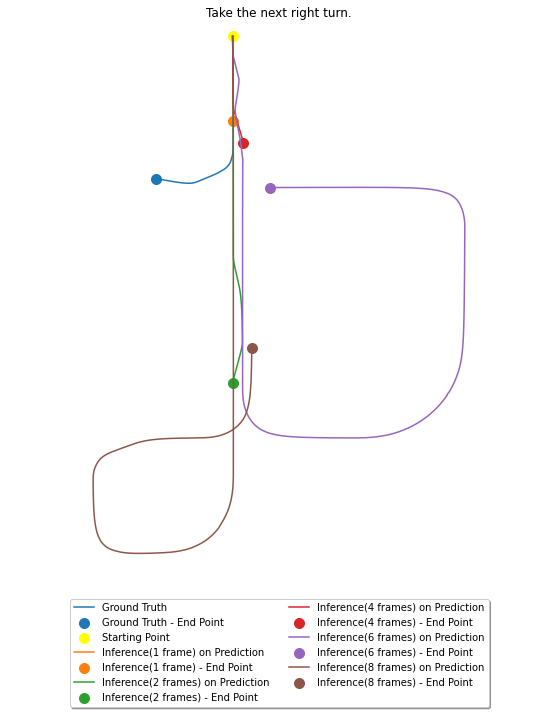

Episode 5: Drive straight from the next crossroads.
(150, 3) (150, 3)
1 frame
Frechet Distance: 45.22705139400174
FDE Distance: 45.22705139400174
ADE Distance: 16.031533817024016
ADE Matched Distance: 7.328353177890771
nDTW Distance: 0.022568472306247124
TC Distance: False
(150, 3) (150, 3)
2 frames
Frechet Distance: 41.66849915247387
FDE Distance: 41.66849915247387
ADE Distance: 21.053370035646964
ADE Matched Distance: 8.908916069056856
nDTW Distance: 0.15126981133132933
TC Distance: False
(150, 3) (150, 3)
4 frames
Frechet Distance: 51.6266819424152
FDE Distance: 51.6266819424152
ADE Distance: 15.670981587468331
ADE Matched Distance: 9.34112397084518
nDTW Distance: 0.05700528186974419
TC Distance: False
(150, 3) (150, 3)
6 frames
Frechet Distance: 68.45545005535746
FDE Distance: 68.45545005535746
ADE Distance: 26.29844927954328
ADE Matched Distance: 19.054628102900228
nDTW Distance: 0.00687674755743542
TC Distance: False
(150, 3) (150, 3)
8 frames
Frechet Distance: 50.261441355822654

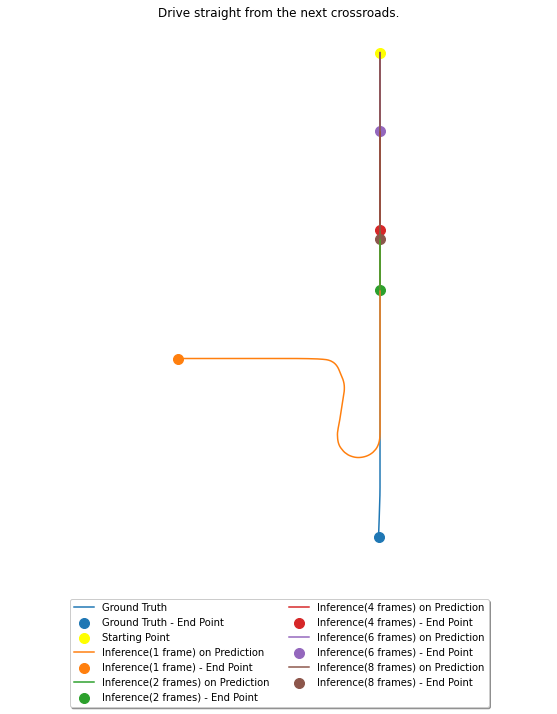

Episode 6: change to left lane
(70, 3) (70, 3)
1 frame
Frechet Distance: 3.8295713611459132
FDE Distance: 3.818593707256924
ADE Distance: 7.677587718053485
ADE Matched Distance: 1.9089098860371339
nDTW Distance: 0.41331197828602634
TC Distance: True
(70, 3) (70, 3)
2 frames
Frechet Distance: 18.913566257866222
FDE Distance: 18.913566257866222
ADE Distance: 9.040094902109466
ADE Matched Distance: 3.350838120401866
nDTW Distance: 0.14737651500730745
TC Distance: False
(70, 3) (70, 3)
4 frames
Frechet Distance: 19.08003482703489
FDE Distance: 19.08003482703489
ADE Distance: 8.663462096763434
ADE Matched Distance: 3.323213856094595
nDTW Distance: 0.1469050029114626
TC Distance: False
(70, 3) (70, 3)
6 frames
Frechet Distance: 17.017066812286984
FDE Distance: 17.017066812286984
ADE Distance: 8.16664109584809
ADE Matched Distance: 3.0090228456775843
nDTW Distance: 0.152165188684201
TC Distance: False
(70, 3) (70, 3)
8 frames
Frechet Distance: 10.330408449407981
FDE Distance: 10.3304084494079

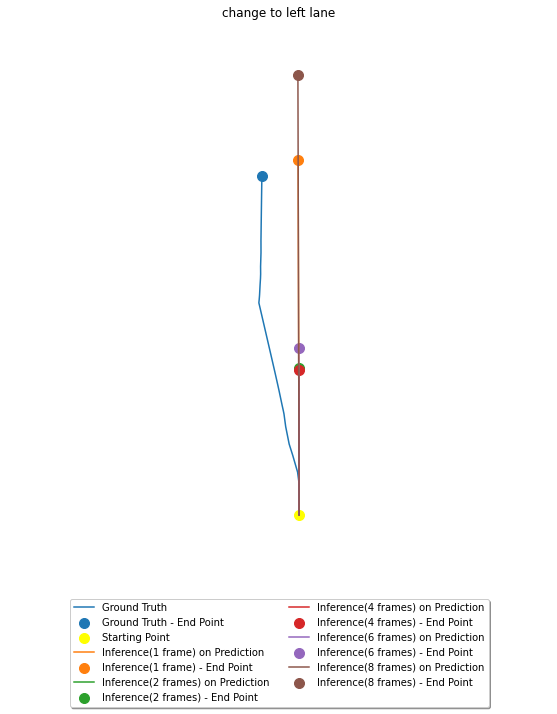

Episode 7: Stop near the scooty
(42, 3) (42, 3)
1 frame
Frechet Distance: 4.113144715211904
FDE Distance: 4.113144715211904
ADE Distance: 2.594281349485533
ADE Matched Distance: 0.7527167224612503
nDTW Distance: 0.6411695792826678
TC Distance: True
(42, 3) (42, 3)
2 frames
Frechet Distance: 48.10275022091086
FDE Distance: 48.10275022091086
ADE Distance: 20.371963626010807
ADE Matched Distance: 13.860533759509956
nDTW Distance: 2.727849579335696e-07
TC Distance: False
(42, 3) (42, 3)
4 frames
Frechet Distance: 44.937059213924115
FDE Distance: 44.937059213924115
ADE Distance: 22.287000917576506
ADE Matched Distance: 13.579169710004097
nDTW Distance: 3.9550652874978454e-07
TC Distance: False
(42, 3) (42, 3)
6 frames
Frechet Distance: 6.280537858518701
FDE Distance: 6.2805378585187
ADE Distance: 3.6154743430465883
ADE Matched Distance: 0.37477214538777553
nDTW Distance: 0.6998243858644173
TC Distance: False
(42, 3) (42, 3)
8 frames
Frechet Distance: 48.064641957435846
FDE Distance: 48.0646

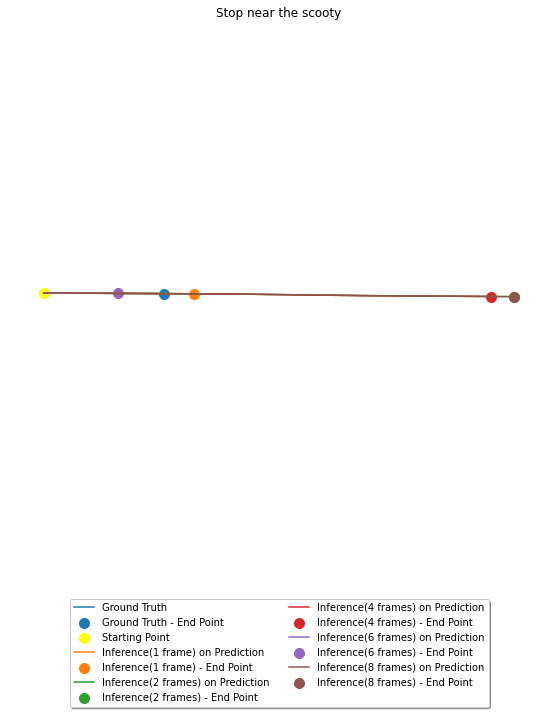

Episode 8: take right and stop near the speed limit sign
(142, 3) (142, 3)
1 frame
Frechet Distance: 10.336369096539602
FDE Distance: 10.336369096539602
ADE Distance: 6.818130052811995
ADE Matched Distance: 1.1747275139459668
nDTW Distance: 0.7535745475117428
TC Distance: False
(142, 3) (142, 3)
2 frames
Frechet Distance: 12.627638396868733
FDE Distance: 12.627638396868733
ADE Distance: 2.5517917629127567
ADE Matched Distance: 1.1363899292154245
nDTW Distance: 0.6756132020349183
TC Distance: False
(142, 3) (142, 3)
4 frames
Frechet Distance: 8.690156610600413
FDE Distance: 8.690156610600413
ADE Distance: 9.528028086862701
ADE Matched Distance: 3.764740144775191
nDTW Distance: 0.17015957541276724
TC Distance: False
(142, 3) (142, 3)
6 frames
Frechet Distance: 8.34504336527151
FDE Distance: 8.345043365271511
ADE Distance: 11.429592367303687
ADE Matched Distance: 3.635579699097003
nDTW Distance: 0.17004281231995017
TC Distance: False
(142, 3) (142, 3)
8 frames
Frechet Distance: 2.08735081

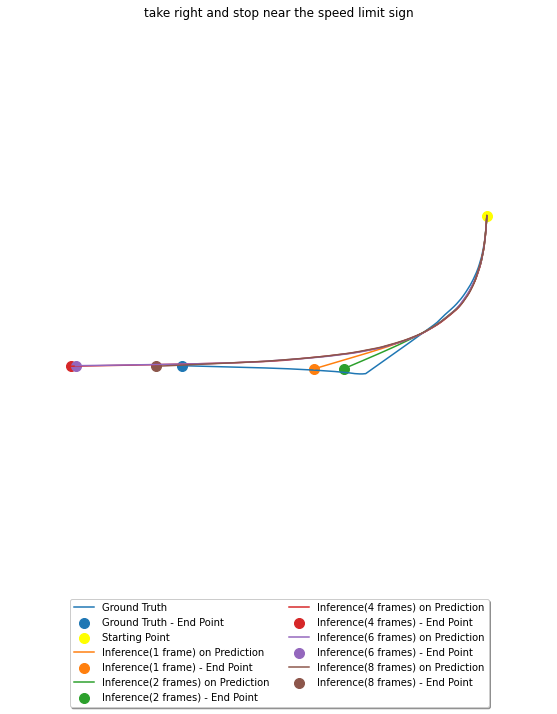

Episode 9: Turn right and stop near the bus stop.
(59, 3) (59, 3)
1 frame
Frechet Distance: 1.2081550409656479
FDE Distance: 1.2081550409656479
ADE Distance: 1.4099157731890968
ADE Matched Distance: 0.1425757796983531
nDTW Distance: 0.9413752264823723
TC Distance: True
(59, 3) (59, 3)
2 frames
Frechet Distance: 202.92588754004086
FDE Distance: 202.92588754004086
ADE Distance: 97.95140386110633
ADE Matched Distance: 88.06370133875252
nDTW Distance: 9.273151104905313e-260
TC Distance: False
(59, 3) (59, 3)
4 frames
Frechet Distance: 18.646016502107994
FDE Distance: 18.646016502107994
ADE Distance: 16.220770226684824
ADE Matched Distance: 9.66643422408704
nDTW Distance: 7.225103328704906e-05
TC Distance: False
(59, 3) (59, 3)
6 frames
Frechet Distance: 29.477872626978066
FDE Distance: 29.477872626978066
ADE Distance: 8.108610879231795
ADE Matched Distance: 5.731245283903344
nDTW Distance: 0.10917684141663622
TC Distance: False
(59, 3) (59, 3)
8 frames
Frechet Distance: 18.74963688519676
F

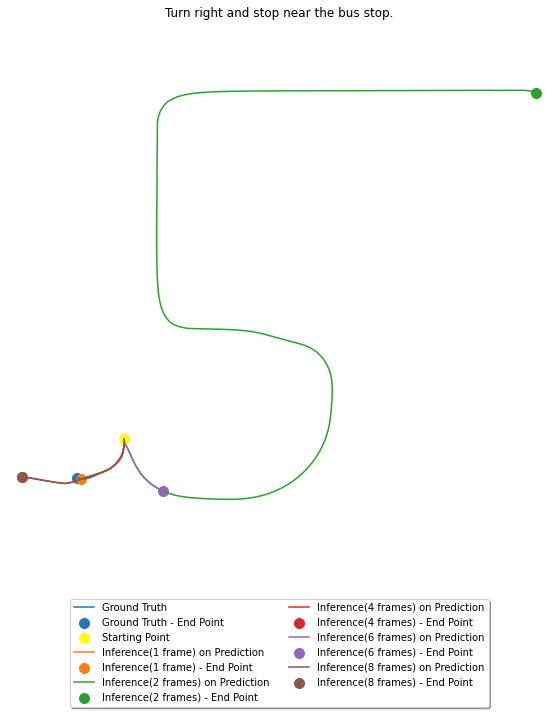

Episode 10: Shift to the left lane and stop at the intersection.
(66, 3) (66, 3)
1 frame
Frechet Distance: 5.656893371437456
FDE Distance: 5.656893371437456
ADE Distance: 3.9506591469327828
ADE Matched Distance: 1.5842517803004275
nDTW Distance: 0.5982888362636092
TC Distance: False
(66, 3) (66, 3)
2 frames
Frechet Distance: 3.172430095609752
FDE Distance: 3.172430095609752
ADE Distance: 9.051058615557725
ADE Matched Distance: 2.0449877406795935
nDTW Distance: 0.2345510034280181
TC Distance: True
(66, 3) (66, 3)
4 frames
Frechet Distance: 40.51786451580367
FDE Distance: 40.51786451580367
ADE Distance: 16.617895496797104
ADE Matched Distance: 11.861189704115773
nDTW Distance: 0.00019268886147942154
TC Distance: False
(66, 3) (66, 3)
6 frames
Frechet Distance: 28.19016090564713
FDE Distance: 28.19016090564713
ADE Distance: 25.406659752235683
ADE Matched Distance: 15.350297006682677
nDTW Distance: 4.978295542514907e-07
TC Distance: False
(66, 3) (66, 3)
8 frames
Frechet Distance: 12.26983

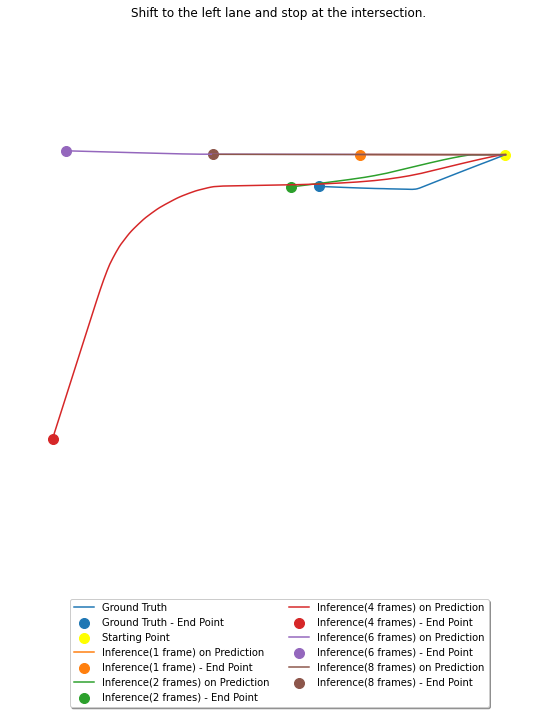

Episode 11: Stop after crossing the stop signboard
(45, 3) (45, 3)
1 frame
Frechet Distance: 12.415475987568623
FDE Distance: 12.415475987568623
ADE Distance: 5.09384209344204
ADE Matched Distance: 2.8486461951282784
nDTW Distance: 0.16357676058361637
TC Distance: False
(45, 3) (45, 3)
2 frames
Frechet Distance: 38.34484918063236
FDE Distance: 38.34484918063236
ADE Distance: 17.49390576374436
ADE Matched Distance: 10.579760716024923
nDTW Distance: 5.39516557531422e-05
TC Distance: False
(45, 3) (45, 3)
4 frames
Frechet Distance: 26.675132434233014
FDE Distance: 26.675132434233014
ADE Distance: 23.793584677673906
ADE Matched Distance: 14.850608013436775
nDTW Distance: 4.265147527519299e-09
TC Distance: False
(45, 3) (45, 3)
6 frames
Frechet Distance: 1.2624204708155122
FDE Distance: 1.2624204708155122
ADE Distance: 4.611495824947239
ADE Matched Distance: 0.17915135795038573
nDTW Distance: 0.8440052037203921
TC Distance: True
(45, 3) (45, 3)
8 frames
Frechet Distance: 0.9109973698678219


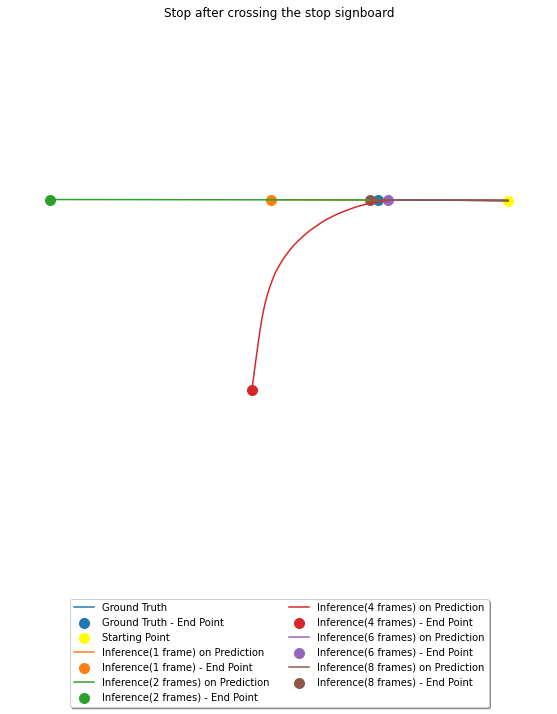

Episode 12: Park near the red signboard
(45, 3) (45, 3)
1 frame
Frechet Distance: 7.531891462953148
FDE Distance: 7.531891462953148
ADE Distance: 4.39965835515901
ADE Matched Distance: 1.1135951484773283
nDTW Distance: 0.13742540472550266
TC Distance: False
(45, 3) (45, 3)
2 frames
Frechet Distance: 1.2811380701653543
FDE Distance: 1.2811380701653543
ADE Distance: 2.0066142222266143
ADE Matched Distance: 0.47803466194660327
nDTW Distance: 0.4229664609964223
TC Distance: True
(45, 3) (45, 3)
4 frames
Frechet Distance: 17.529059449316424
FDE Distance: 17.529059449316424
ADE Distance: 7.444688716671295
ADE Matched Distance: 3.4483535920823627
nDTW Distance: 0.00018734308549449074
TC Distance: False
(45, 3) (45, 3)
6 frames
Frechet Distance: 4.51618076079961
FDE Distance: 4.51618076079961
ADE Distance: 2.045286765956971
ADE Matched Distance: 0.1686204202798367
nDTW Distance: 0.7589737666944011
TC Distance: True
(45, 3) (45, 3)
8 frames
Frechet Distance: 7.247315997361679
FDE Distance: 7.24

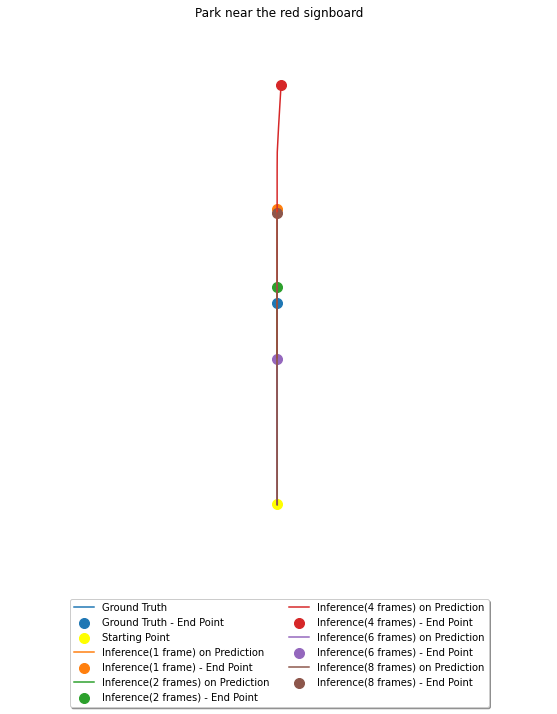

Episode 13: Wait at the traffic light then go straight.
(340, 3) (340, 3)
1 frame
Frechet Distance: 81.84562289542433
FDE Distance: 81.84562289542433
ADE Distance: 18.27416205981435
ADE Matched Distance: 11.133067865650947
nDTW Distance: 0.02521134319097931
TC Distance: False
(340, 3) (340, 3)
2 frames
Frechet Distance: 81.16752197880061
FDE Distance: 81.16752197880061
ADE Distance: 17.116184081076337
ADE Matched Distance: 9.485192668334118
nDTW Distance: 0.02488112946716583
TC Distance: False
(340, 3) (340, 3)
4 frames
Frechet Distance: 75.23119454879443
FDE Distance: 75.23119454879443
ADE Distance: 14.29148833811487
ADE Matched Distance: 10.267932320148926
nDTW Distance: 0.0036349389065462702
TC Distance: False
(340, 3) (340, 3)
6 frames
Frechet Distance: 182.376807508145
FDE Distance: 182.37680750814502
ADE Distance: 67.15277133818668
ADE Matched Distance: 63.90625871798445
nDTW Distance: 8.226761834037193e-28
TC Distance: False
(340, 3) (340, 3)
8 frames
Frechet Distance: 72.460852

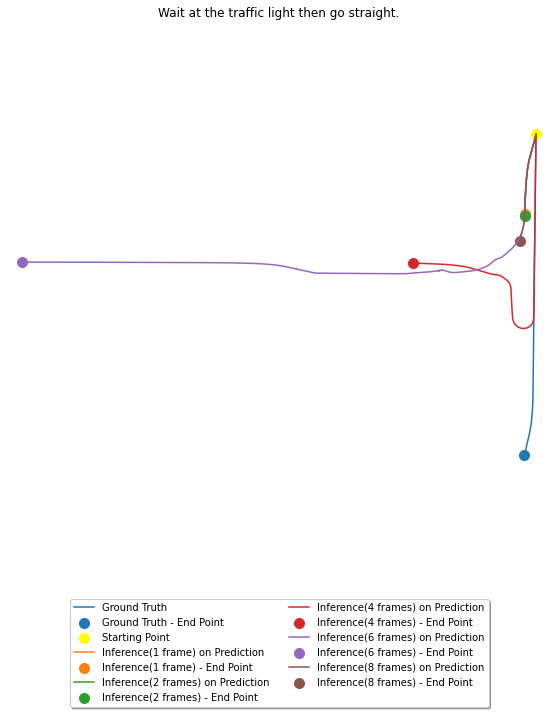

Episode 14: Drive straight till the intersection and then turn left
(73, 3) (73, 3)
1 frame
Frechet Distance: 9.703459892512779
FDE Distance: 9.703459892512779
ADE Distance: 8.189948563951791
ADE Matched Distance: 0.2142846836086852
nDTW Distance: 0.7084918396167156
TC Distance: False
(73, 3) (73, 3)
2 frames
Frechet Distance: 9.66421858185865
FDE Distance: 9.66421858185865
ADE Distance: 4.446288497542772
ADE Matched Distance: 0.5358391377676263
nDTW Distance: 0.4330985899953153
TC Distance: False
(73, 3) (73, 3)
4 frames
Frechet Distance: 6.350518446928318
FDE Distance: 6.3505184469283185
ADE Distance: 5.916472436245883
ADE Matched Distance: 1.1570157596854656
nDTW Distance: 0.09608128999038527
TC Distance: False
(73, 3) (73, 3)
6 frames
Frechet Distance: 9.657749344733089
FDE Distance: 9.657749344733089
ADE Distance: 5.734984236074581
ADE Matched Distance: 0.45958524549070967
nDTW Distance: 0.4136829172900162
TC Distance: False
(73, 3) (73, 3)
8 frames
Frechet Distance: 10.6384045357

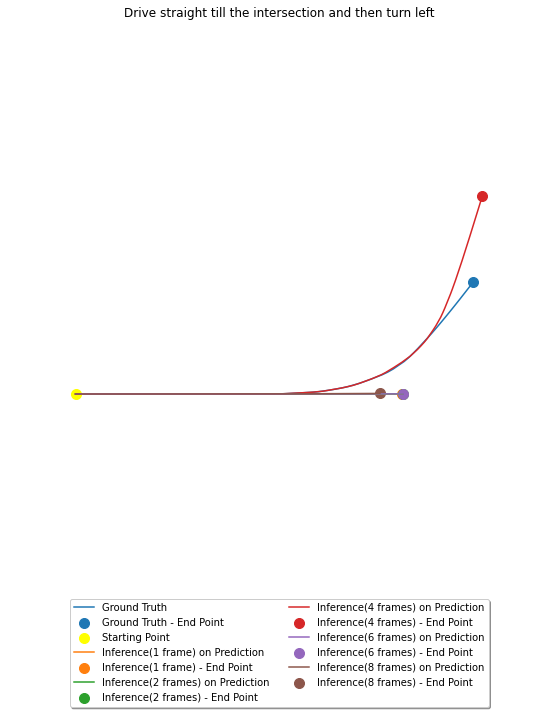

Episode 15: go straight and take a left
(157, 3) (157, 3)
1 frame
Frechet Distance: 43.43848256239939
FDE Distance: 43.43848256239939
ADE Distance: 25.417683637265498
ADE Matched Distance: 13.972125278620052
nDTW Distance: 0.0611500220827944
TC Distance: False
(239, 3) (239, 3)
2 frames
Frechet Distance: 34.30876845117658
FDE Distance: 34.30876845117658
ADE Distance: 10.385125570739783
ADE Matched Distance: 6.292225249737302
nDTW Distance: 0.20604964625117997
TC Distance: False
(239, 3) (239, 3)
4 frames
Frechet Distance: 17.803722393710128
FDE Distance: 17.803722393710128
ADE Distance: 6.557896548711525
ADE Matched Distance: 1.6754485732466282
nDTW Distance: 0.6011301617873249
TC Distance: False
(239, 3) (239, 3)
6 frames
Frechet Distance: 59.69643979551292
FDE Distance: 3.912125258638247
ADE Distance: 49.21447372764732
ADE Matched Distance: 24.497496918784517
nDTW Distance: 3.1172504937738705e-17
TC Distance: True
(239, 3) (239, 3)
8 frames
Frechet Distance: 43.32029416559261
FDE Dis

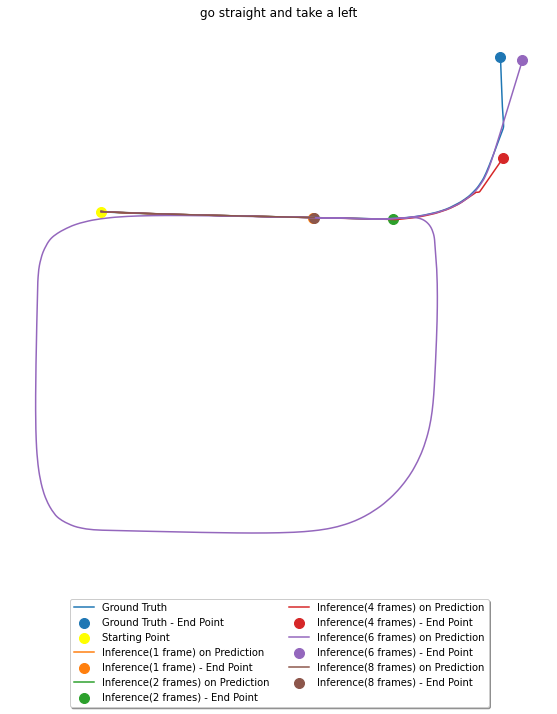

Episode 16: Stop as soon as you encounter a white car
(47, 3) (47, 3)
1 frame
Frechet Distance: 2.9037953506488314
FDE Distance: 2.9037953506488314
ADE Distance: 1.9718674394538418
ADE Matched Distance: 0.450663764401555
nDTW Distance: 0.777850387580948
TC Distance: True
(47, 3) (47, 3)
2 frames
Frechet Distance: 20.426239389129123
FDE Distance: 20.426239389129123
ADE Distance: 20.118555012178422
ADE Matched Distance: 10.725336885156116
nDTW Distance: 1.706336565360091e-06
TC Distance: False
(47, 3) (47, 3)
4 frames
Frechet Distance: 24.59998262622042
FDE Distance: 24.59998262622042
ADE Distance: 17.335073429154434
ADE Matched Distance: 12.845022235343176
nDTW Distance: 7.157210777750854e-08
TC Distance: False
(47, 3) (47, 3)
6 frames
Frechet Distance: 6.1272685687115835
FDE Distance: 6.1272685687115835
ADE Distance: 4.710141631813737
ADE Matched Distance: 0.3913174792356006
nDTW Distance: 0.6955798906563287
TC Distance: False
(47, 3) (47, 3)
8 frames
Frechet Distance: 6.12726856871158

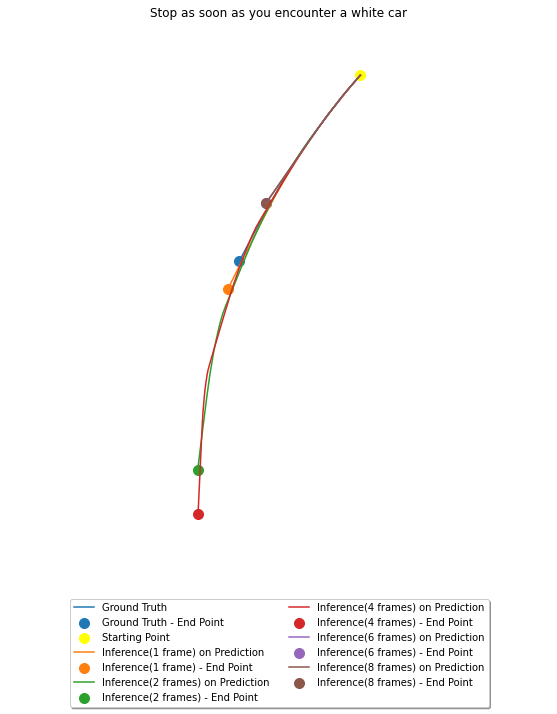

Episode 17: take a right at the intersection
(105, 3) (105, 3)
1 frame
Frechet Distance: 18.41672405991541
FDE Distance: 18.41672405991541
ADE Distance: 8.196723478742765
ADE Matched Distance: 2.6320482905540703
nDTW Distance: 0.5107888455615511
TC Distance: False
(105, 3) (105, 3)
2 frames
Frechet Distance: 25.66786027149127
FDE Distance: 25.66786027149127
ADE Distance: 7.023721672907017
ADE Matched Distance: 3.1085617033983572
nDTW Distance: 0.2702098362893891
TC Distance: False
(105, 3) (105, 3)
4 frames
Frechet Distance: 27.876973576113173
FDE Distance: 27.876973576113176
ADE Distance: 8.226597247639132
ADE Matched Distance: 3.7457610192020767
nDTW Distance: 0.2172202334843738
TC Distance: False
(105, 3) (105, 3)
6 frames
Frechet Distance: 33.1431530448927
FDE Distance: 33.1431530448927
ADE Distance: 10.644541707002428
ADE Matched Distance: 5.8344033352516735
nDTW Distance: 0.12377720646426162
TC Distance: False
(105, 3) (105, 3)
8 frames
Frechet Distance: 29.960852515217397
FDE Di

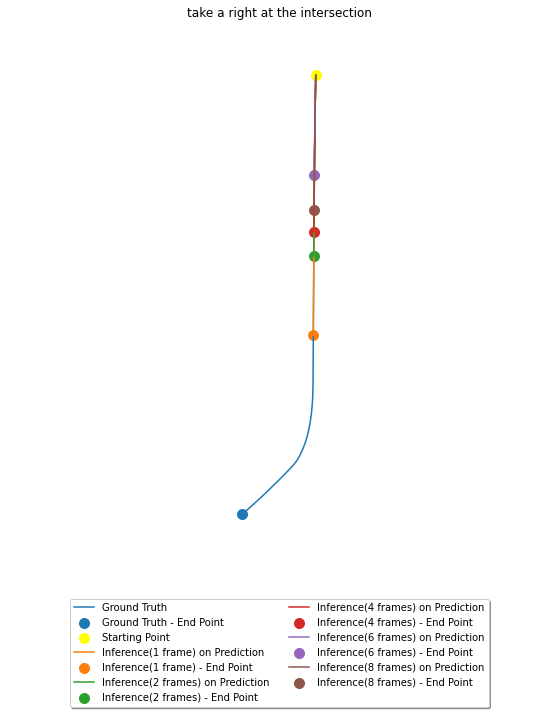

Episode 18: Stop near the red shelters
(44, 3) (44, 3)
1 frame
Frechet Distance: 11.032272904165058
FDE Distance: 11.032272904165058
ADE Distance: 7.613050386998534
ADE Matched Distance: 2.423625823870728
nDTW Distance: 0.1894768105611365
TC Distance: False
(44, 3) (44, 3)
2 frames
Frechet Distance: 103.33918713211021
FDE Distance: 25.533245935326235
ADE Distance: 53.14784638300323
ADE Matched Distance: 54.40465546812693
nDTW Distance: 6.518545956928967e-169
TC Distance: False
(44, 3) (44, 3)
4 frames
Frechet Distance: 2.685933144203246
FDE Distance: 2.685933144203246
ADE Distance: 5.276441799049247
ADE Matched Distance: 0.18094351401444536
nDTW Distance: 0.8358562980327362
TC Distance: True
(44, 3) (44, 3)
6 frames
Frechet Distance: 1.134910472954632
FDE Distance: 1.134910472954632
ADE Distance: 5.870252868172783
ADE Matched Distance: 0.6506453108694632
nDTW Distance: 0.5080056959119601
TC Distance: True
(44, 3) (44, 3)
8 frames
Frechet Distance: 5.216857988769478
FDE Distance: 5.2168

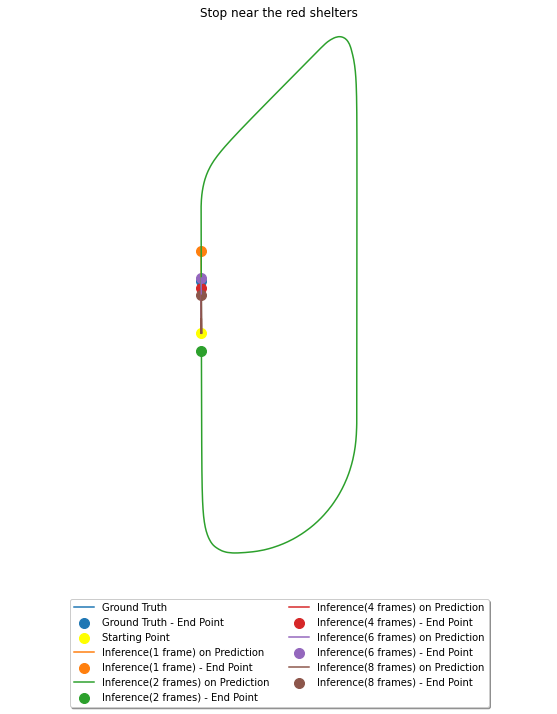

Episode 19: Turn left from the intersection
(127, 3) (127, 3)
1 frame
Frechet Distance: 257.80952505892054
FDE Distance: 257.80952505892054
ADE Distance: 144.45377026916853
ADE Matched Distance: 125.87068699756463
nDTW Distance: 5.0489573094459485e-294
TC Distance: False
(127, 3) (127, 3)
2 frames
Frechet Distance: 18.331809144225375
FDE Distance: 18.331809144225375
ADE Distance: 7.484962493048138
ADE Matched Distance: 0.7259444796786655
nDTW Distance: 0.5059290114012279
TC Distance: False
(127, 3) (127, 3)
4 frames
Frechet Distance: 14.916772736632765
FDE Distance: 14.916772736632767
ADE Distance: 9.628399715542301
ADE Matched Distance: 0.5089257890411374
nDTW Distance: 0.6192341258442475
TC Distance: False
(127, 3) (127, 3)
6 frames
Frechet Distance: 24.242030081862197
FDE Distance: 24.242030081862197
ADE Distance: 9.544677382424165
ADE Matched Distance: 1.0843842884982282
nDTW Distance: 0.3179499835383651
TC Distance: False
(127, 3) (127, 3)
8 frames
Frechet Distance: 19.09675351070

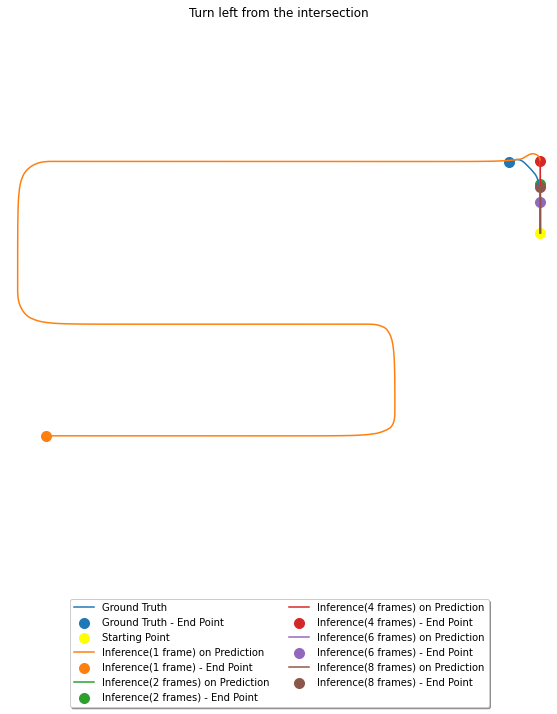

Episode 20: Drive straight then turn right
(111, 3) (111, 3)
1 frame
Frechet Distance: 37.796498353662855
FDE Distance: 37.796498353662855
ADE Distance: 16.533015672224757
ADE Matched Distance: 13.023996344533524
nDTW Distance: 0.0739179733440717
TC Distance: False
(127, 3) (127, 3)
2 frames
Frechet Distance: 43.682583088491626
FDE Distance: 43.68258308849162
ADE Distance: 15.854039267922984
ADE Matched Distance: 11.944420055119249
nDTW Distance: 0.0001367737875257422
TC Distance: False
(127, 3) (127, 3)
4 frames
Frechet Distance: 125.29301182415516
FDE Distance: 125.29301182415516
ADE Distance: 68.60043303007396
ADE Matched Distance: 61.68190181168172
nDTW Distance: 4.062796855684e-73
TC Distance: False
(127, 3) (127, 3)
6 frames
Frechet Distance: 47.86998422600768
FDE Distance: 47.86998422600768
ADE Distance: 11.51012891624078
ADE Matched Distance: 6.103364216187586
nDTW Distance: 0.015282532369028354
TC Distance: False
(127, 3) (127, 3)
8 frames
Frechet Distance: 36.30163996600647
F

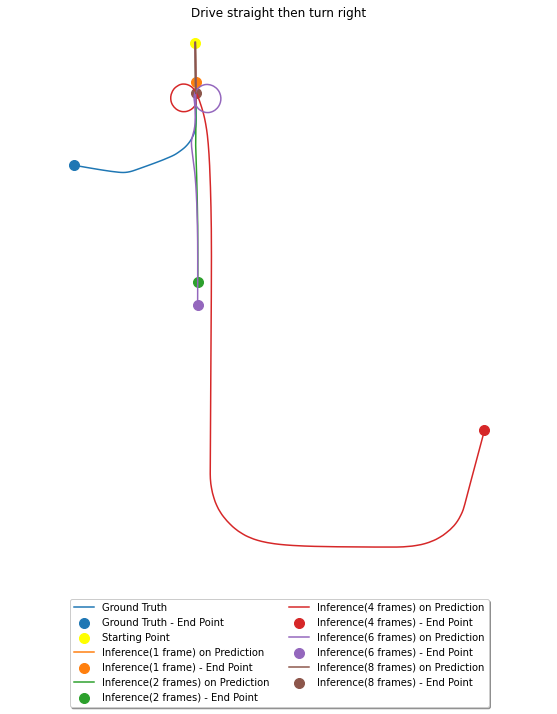

Episode 21: Park near the hut visible on the right
(36, 3) (36, 3)
1 frame
Frechet Distance: 19.692774907384177
FDE Distance: 19.692774907384177
ADE Distance: 6.806468798076072
ADE Matched Distance: 4.916907140222407
nDTW Distance: 0.020116607497758805
TC Distance: False
(36, 3) (36, 3)
2 frames
Frechet Distance: 14.13472994287188
FDE Distance: 14.13472994287188
ADE Distance: 13.053435944567076
ADE Matched Distance: 7.996747481845202
nDTW Distance: 2.2393129818169503e-05
TC Distance: False
(36, 3) (36, 3)
4 frames
Frechet Distance: 43.61936342191302
FDE Distance: 43.61936342191302
ADE Distance: 33.23327270463383
ADE Matched Distance: 24.87137907475551
nDTW Distance: 3.1425833893728376e-20
TC Distance: False
(36, 3) (36, 3)
6 frames
Frechet Distance: 29.92985491833193
FDE Distance: 29.92985491833193
ADE Distance: 22.437487245825192
ADE Matched Distance: 17.052223375069484
nDTW Distance: 1.55612427391769e-12
TC Distance: False
(36, 3) (36, 3)
8 frames
Frechet Distance: 5.641395440499691


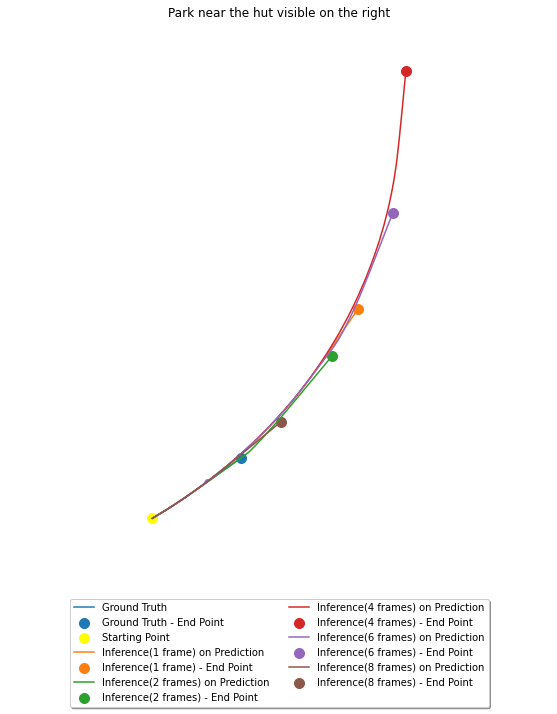

Episode 22: Go straight and stop before the traffic light.
(170, 3) (170, 3)
1 frame
Frechet Distance: 76.42999812464583
FDE Distance: 76.42999812464583
ADE Distance: 34.5360275130977
ADE Matched Distance: 19.450375040348487
nDTW Distance: 0.006662024096832506
TC Distance: False
(170, 3) (170, 3)
2 frames
Frechet Distance: 78.3792028259615
FDE Distance: 78.3792028259615
ADE Distance: 30.63193572031861
ADE Matched Distance: 13.69621862821737
nDTW Distance: 0.004750136786473779
TC Distance: False
(170, 3) (170, 3)
4 frames
Frechet Distance: 30.988460278054816
FDE Distance: 30.988460278054813
ADE Distance: 7.397231383839031
ADE Matched Distance: 1.8424928972165255
nDTW Distance: 0.4138594100997429
TC Distance: False
(170, 3) (170, 3)
6 frames
Frechet Distance: 78.57307530435686
FDE Distance: 78.57307530435686
ADE Distance: 30.24707705536311
ADE Matched Distance: 13.813001925720926
nDTW Distance: 0.004612683644968584
TC Distance: False
(170, 3) (170, 3)
8 frames
Frechet Distance: 50.339206

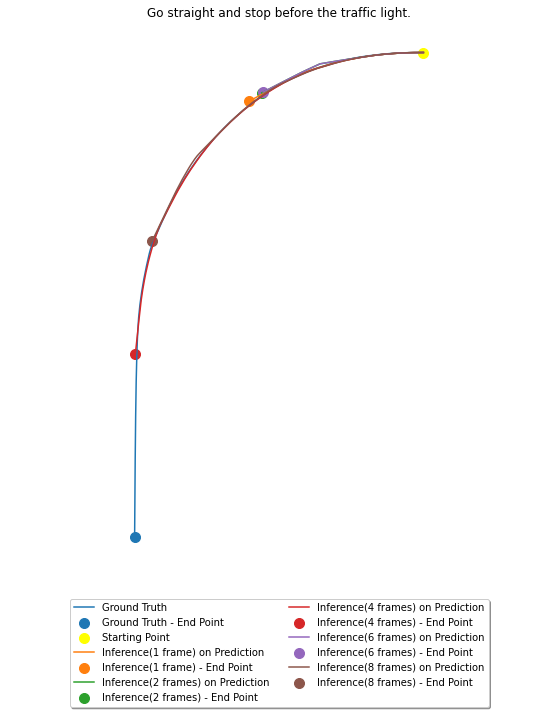

Episode 23: stop at the bus stand in front
(136, 3) (136, 3)
1 frame
Frechet Distance: 28.39617283777976
FDE Distance: 28.39617283777976
ADE Distance: 7.73904858099479
ADE Matched Distance: 2.225117012510375
nDTW Distance: 0.4650073668762607
TC Distance: False
(136, 3) (136, 3)
2 frames
Frechet Distance: 33.01252173654443
FDE Distance: 33.01252173654443
ADE Distance: 7.012526826519297
ADE Matched Distance: 2.946017725805487
nDTW Distance: 0.3474618243203222
TC Distance: False
(136, 3) (136, 3)
4 frames
Frechet Distance: 4.578247239405164
FDE Distance: 4.578247239405164
ADE Distance: 10.70754471434868
ADE Matched Distance: 0.1781359497953316
nDTW Distance: 0.8770035132268733
TC Distance: True
(136, 3) (136, 3)
6 frames
Frechet Distance: 10.704908349789953
FDE Distance: 10.704908349789953
ADE Distance: 14.635829811448078
ADE Matched Distance: 0.24539684377874096
nDTW Distance: 0.7883458323673106
TC Distance: False
(136, 3) (136, 3)
8 frames
Frechet Distance: 22.518014029637847
FDE Distan

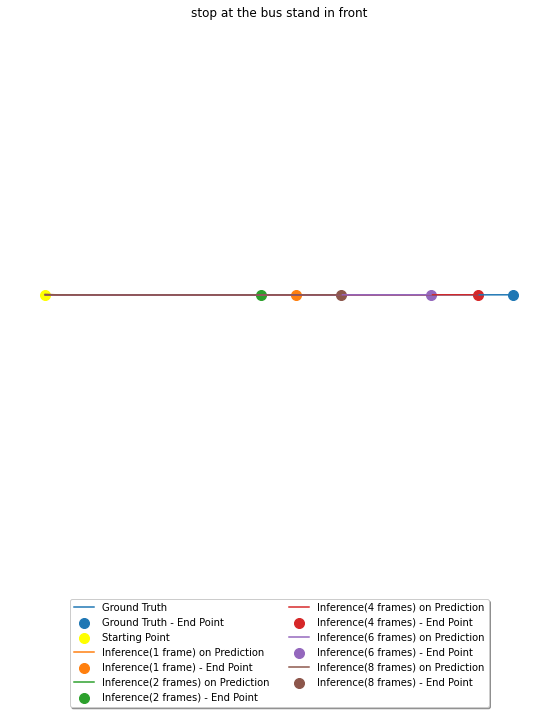

Episode 24: Turn right from the intersection.
(66, 3) (66, 3)
1 frame
Frechet Distance: 5.375264725821875
FDE Distance: 5.375264725821875
ADE Distance: 4.239350676915514
ADE Matched Distance: 0.6427872466029156
nDTW Distance: 0.7869549008363725
TC Distance: False
(66, 3) (66, 3)
2 frames
Frechet Distance: 27.3741612885438
FDE Distance: 27.3741612885438
ADE Distance: 13.629801577627413
ADE Matched Distance: 14.49615509691831
nDTW Distance: 8.059110996835042e-06
TC Distance: False
(66, 3) (66, 3)
4 frames
Frechet Distance: 33.59332918751105
FDE Distance: 33.593329187511046
ADE Distance: 21.65958068048312
ADE Matched Distance: 18.391904290627096
nDTW Distance: 8.555994076618842e-08
TC Distance: False
(66, 3) (66, 3)
6 frames
Frechet Distance: 27.08433394729942
FDE Distance: 27.08433394729942
ADE Distance: 14.615549306288159
ADE Matched Distance: 14.446920237238563
nDTW Distance: 5.181397055514267e-06
TC Distance: False
(66, 3) (66, 3)
8 frames
Frechet Distance: 21.107360437032327
FDE Dist

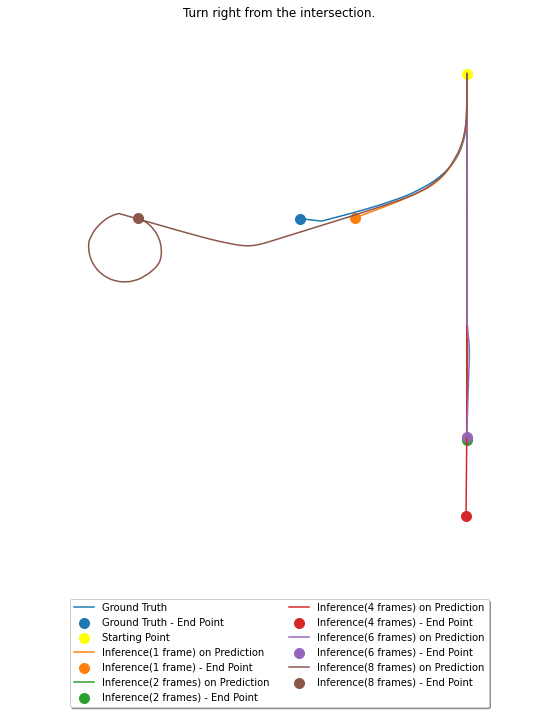

In [25]:
val_data_path = '/ssd_scratch/cvit/varunc/carla_data/val/'
val_run_paths = ['/ssd_scratch/cvit/varunc/ablation_runs/val_clip1/','/ssd_scratch/cvit/varunc/ablation_runs/val_clip2/',
                '/ssd_scratch/cvit/varunc/ablation_runs/val_clip4/','/ssd_scratch/cvit/varunc/ablation_runs/val_clip6_1/',
                '/ssd_scratch/cvit/varunc/ablation_runs/val_clip8/']
names = ['1 frame','2 frames',
        '4 frames','6 frames',
        '8 frames']

save_loc = '../trajectories_val/'

frechet_val_all,fde_val_all,ade_val_all, ade_matched_val_all, ndtw_val_all, tc_val_clip_all = get_scores_comp(val_data_path, val_run_paths,names, save_loc,episodes=list(range(0,25)))

1 frame     12.925125
2 frames    34.308768
4 frames    26.675132
6 frames    27.084334
8 frames    19.096754
dtype: float64
1 frame     35.581984
2 frames    46.170432
4 frames    36.825228
6 frames    35.928264
8 frames    30.536507
dtype: float64


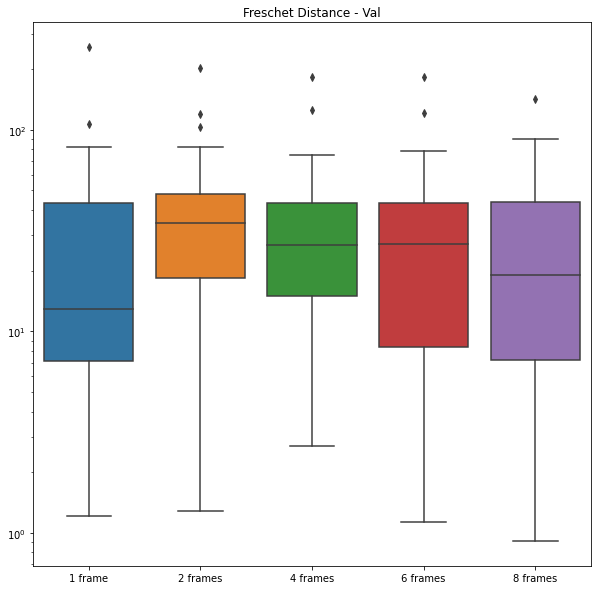

In [21]:
plt.figure(figsize=(10,10))
names = ['1 frame','2 frames',
        '4 frames','6 frames',
        '8 frames']
f_df = deinterlace(frechet_val_all,names)

# g = sns.boxplot(data=f_df[['CLIP-con','CLIP-nocon','CLIP-single-nocon','RNR-con','RNR']])
g = sns.boxplot(data=f_df)

g.set_yscale("log")

plt.title('Freschet Distance - Val')
print(f_df.median())
print(f_df.mean())

1 frame     0.413312
2 frames    0.024881
4 frames    0.057005
6 frames    0.123777
8 frames    0.102334
dtype: float64
1 frame     0.364007
2 frames    0.180838
4 frames    0.219866
6 frames    0.271529
8 frames    0.264280
dtype: float64


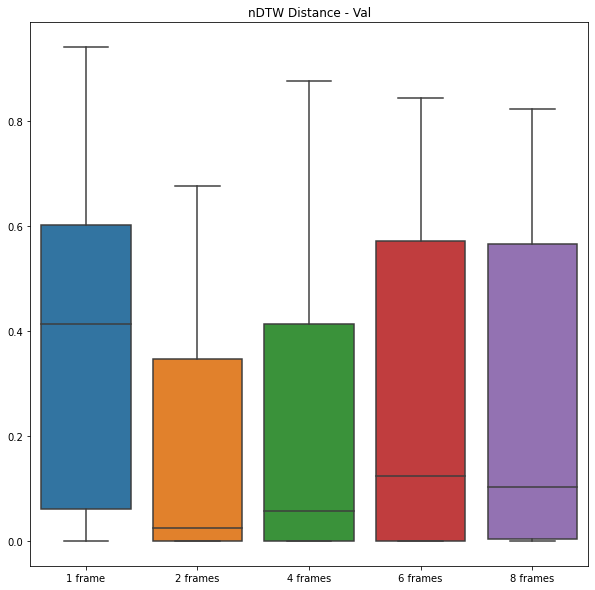

In [22]:
plt.figure(figsize=(10,10))
names = ['1 frame','2 frames',
        '4 frames','6 frames',
        '8 frames']
n_df = deinterlace(ndtw_val_all,names)

# g = sns.boxplot(data=f_df[['CLIP-con','CLIP-nocon','CLIP-single-nocon','RNR-con','RNR']])
g = sns.boxplot(data=n_df)

# g.set_yscale("log")

plt.title('nDTW Distance - Val')
print(n_df.median())
print(n_df.mean())

In [20]:
np.log(n_df).median()

CLIP-con            -0.520787
CLIP-nocon          -0.666876
CLIP-single-nocon   -2.879688
CLIP-single-con     -0.883553
RNR-con             -0.624771
RNR                 -3.131943
dtype: float64

In [21]:
print(f_df.median(),n_df.median())

CLIP-con              8.523169
CLIP-nocon           15.992774
CLIP-single-nocon    29.240288
CLIP-single-con      12.925125
RNR-con              12.294415
RNR                  14.640022
dtype: float64 CLIP-con             0.594053
CLIP-nocon           0.513309
CLIP-single-nocon    0.056152
CLIP-single-con      0.413312
RNR-con              0.535384
RNR                  0.043633
dtype: float64


Episode 0: Stop before the next right turn.
(58, 3) (58, 3)
1 frame
Frechet Distance: 20.874221413745367
FDE Distance: 20.874110254114317
ADE Distance: 9.747656769583159
ADE Matched Distance: 5.129124500731857
nDTW Distance: 0.03178076454182035
TC Distance: False
(58, 3) (58, 3)
2 frames
Frechet Distance: 6.340651501898583
FDE Distance: 6.340651501898583
ADE Distance: 5.510016219598252
ADE Matched Distance: 0.2736998082205621
nDTW Distance: 0.8217584135080246
TC Distance: False
(58, 3) (58, 3)
4 frames
Frechet Distance: 14.498190693867432
FDE Distance: 14.49819069386743
ADE Distance: 3.9954232760429247
ADE Matched Distance: 1.05716671384438
nDTW Distance: 0.5076084695273586
TC Distance: False
(58, 3) (58, 3)
6 frames
Frechet Distance: 9.352273425947534
FDE Distance: 9.352273425947535
ADE Distance: 2.9529848033242714
ADE Matched Distance: 0.8037949566762956
nDTW Distance: 0.6897619753816066
TC Distance: False
(58, 3) (58, 3)
8 frames
Frechet Distance: 14.920134568567054
FDE Distance: 14

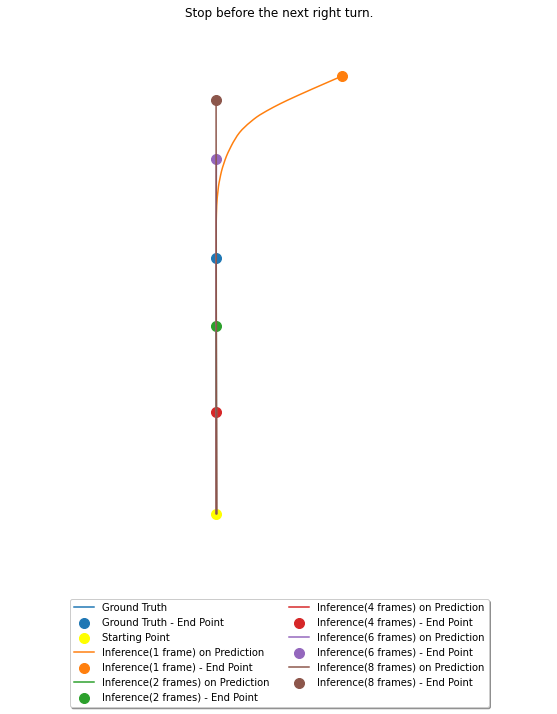

Episode 1: After crossing the blue car come to a stop
(45, 3) (45, 3)
1 frame
Frechet Distance: 6.344630066029439
FDE Distance: 6.344630066029439
ADE Distance: 3.3806566490339676
ADE Matched Distance: 0.9269166278773803
nDTW Distance: 0.6175491327145475
TC Distance: False
(45, 3) (45, 3)
2 frames
Frechet Distance: 247.9560095463517
FDE Distance: 124.29542664800807
ADE Distance: 111.13005813972393
ADE Matched Distance: 129.34006721364872
nDTW Distance: 0.0
TC Distance: False
(45, 3) (45, 3)
4 frames
Frechet Distance: 12.857265204626003
FDE Distance: 12.857265204626003
ADE Distance: 14.74639378493925
ADE Matched Distance: 6.982485475175942
nDTW Distance: 0.00045452817408466205
TC Distance: False
(45, 3) (45, 3)
6 frames
Frechet Distance: 6.052745304516535
FDE Distance: 6.052745304516535
ADE Distance: 10.613683337577113
ADE Matched Distance: 3.9362879097158845
nDTW Distance: 0.03242115507997238
TC Distance: False
(45, 3) (45, 3)
8 frames
Frechet Distance: 9.33142090556375
FDE Distance: 9.

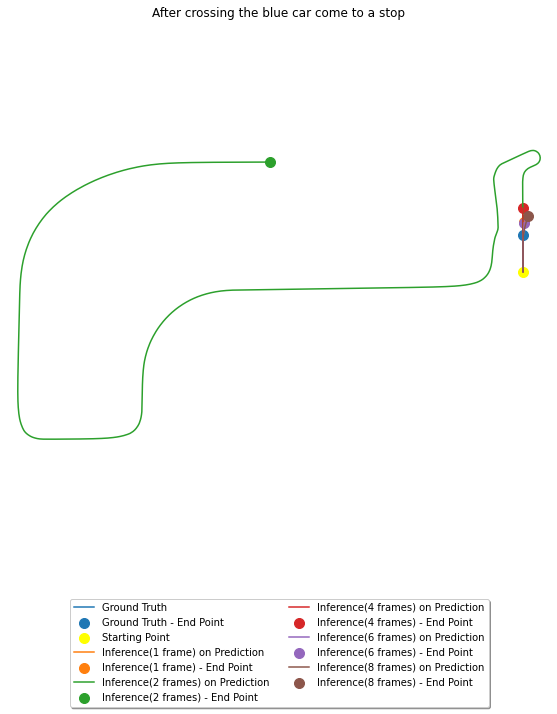

Episode 2: stop beside the black suv
(109, 3) (109, 3)
1 frame
Frechet Distance: 0.3035168663985452
FDE Distance: 0.07802785851386931
ADE Distance: 9.356644014889598
ADE Matched Distance: 0.06742487590888913
nDTW Distance: 0.9359551482186568
TC Distance: True
(109, 3) (109, 3)
2 frames
Frechet Distance: 14.571426392655038
FDE Distance: 14.571426392655038
ADE Distance: 5.452027629435085
ADE Matched Distance: 2.616121664184493
nDTW Distance: 0.3737957463178891
TC Distance: False
(109, 3) (109, 3)
4 frames
Frechet Distance: 11.012972634377057
FDE Distance: 11.012972634377057
ADE Distance: 7.271545020014913
ADE Matched Distance: 0.8080975789738409
nDTW Distance: 0.4659787981452133
TC Distance: False
(109, 3) (109, 3)
6 frames
Frechet Distance: 18.428143984548306
FDE Distance: 18.428143984548306
ADE Distance: 14.68533301215185
ADE Matched Distance: 4.173968521337086
nDTW Distance: 0.004029013819113299
TC Distance: False
(109, 3) (109, 3)
8 frames
Frechet Distance: 0.23631046649714513
FDE Di

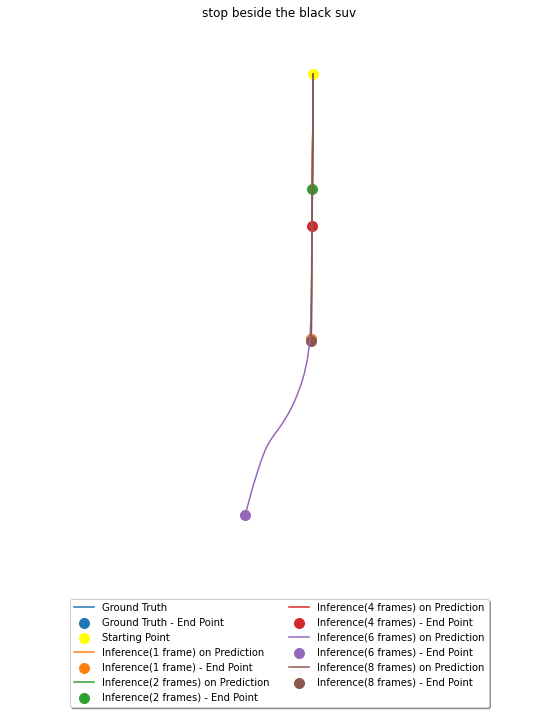

Episode 3: Stop near the signboard
(38, 3) (38, 3)
1 frame
Frechet Distance: 16.174752347390545
FDE Distance: 16.174752347390545
ADE Distance: 6.423294019174243
ADE Matched Distance: 3.6074148591151656
nDTW Distance: 0.08157731913822376
TC Distance: False
(38, 3) (38, 3)
2 frames
Frechet Distance: 72.11469729467635
FDE Distance: 72.11469729467635
ADE Distance: 24.20997530705707
ADE Matched Distance: 19.25786062356173
nDTW Distance: 3.104038842038694e-10
TC Distance: False
(38, 3) (38, 3)
4 frames
Frechet Distance: 21.782263417751185
FDE Distance: 21.782263417751185
ADE Distance: 16.27665707073094
ADE Matched Distance: 12.054431434325762
nDTW Distance: 1.1389569716925287e-07
TC Distance: False
(38, 3) (38, 3)
6 frames
Frechet Distance: 7.196554230376918
FDE Distance: 7.196554230376918
ADE Distance: 7.664093914254325
ADE Matched Distance: 3.9815779160594125
nDTW Distance: 0.01362412698888858
TC Distance: False
(38, 3) (38, 3)
8 frames
Frechet Distance: 38.21331289102413
FDE Distance: 38.

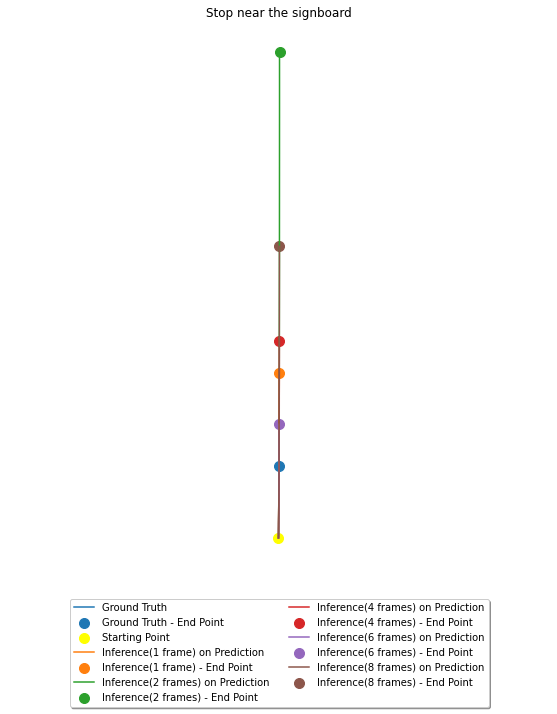

Episode 4: Take a left at the traffic light
(82, 3) (82, 3)
1 frame
Frechet Distance: 73.0845571576141
FDE Distance: 73.0845571576141
ADE Distance: 54.81750868168356
ADE Matched Distance: 46.48342833733129
nDTW Distance: 1.102926089813542e-90
TC Distance: False
(82, 3) (82, 3)
2 frames
Frechet Distance: 49.92085867562531
FDE Distance: 49.92085867562531
ADE Distance: 22.81554597265249
ADE Matched Distance: 18.484279633103647
nDTW Distance: 1.394018338256488e-05
TC Distance: False
(82, 3) (82, 3)
4 frames
Frechet Distance: 215.68424897975441
FDE Distance: 193.62452398808125
ADE Distance: 128.09125146076707
ADE Matched Distance: 122.8075171458825
nDTW Distance: 0.0
TC Distance: False
(82, 3) (82, 3)
6 frames
Frechet Distance: 115.12465786413074
FDE Distance: 115.12465786413074
ADE Distance: 81.10064133663678
ADE Matched Distance: 72.34428303213713
nDTW Distance: 4.995427195998022e-184
TC Distance: False
(82, 3) (82, 3)
8 frames
Frechet Distance: 62.222788343804424
FDE Distance: 62.2227883

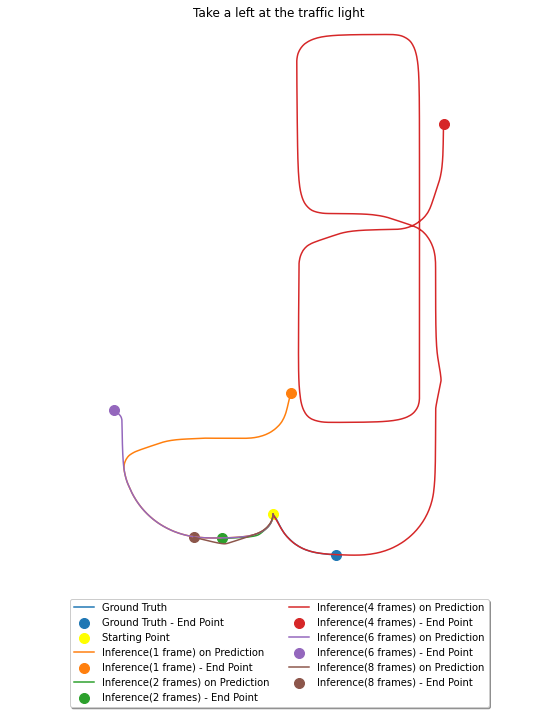

Episode 5: Turn right from the intersection
(57, 3) (57, 3)
1 frame
Frechet Distance: 1.1536910853311761
FDE Distance: 1.1536910853311764
ADE Distance: 1.728162209456303
ADE Matched Distance: 0.2480533235229474
nDTW Distance: 0.8883679130833375
TC Distance: True
(57, 3) (57, 3)
2 frames
Frechet Distance: 6.802951733481146
FDE Distance: 6.802951733481145
ADE Distance: 9.689841931962562
ADE Matched Distance: 3.539982196084534
nDTW Distance: 0.04371388377799237
TC Distance: False
(57, 3) (57, 3)
4 frames
Frechet Distance: 8.98129487976431
FDE Distance: 8.98129487976431
ADE Distance: 10.89687543272559
ADE Matched Distance: 4.497425975887437
nDTW Distance: 0.01996949097980064
TC Distance: False
(57, 3) (57, 3)
6 frames
Frechet Distance: 22.71675696413467
FDE Distance: 22.71675696413467
ADE Distance: 18.986482177093784
ADE Matched Distance: 11.305373814522637
nDTW Distance: 1.1827990101799537e-05
TC Distance: False
(57, 3) (57, 3)
8 frames
Frechet Distance: 19.122166938179785
FDE Distance: 1

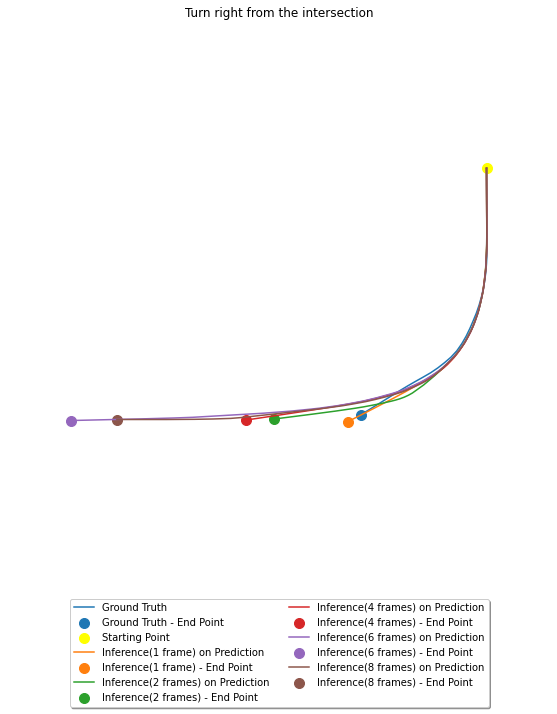

Episode 6: Take a left from the intersection ahead
(91, 3) (91, 3)
1 frame
Frechet Distance: 2.3540163915434107
FDE Distance: 2.3540163915434107
ADE Distance: 4.444662002376648
ADE Matched Distance: 0.3342549997292683
nDTW Distance: 0.9016018010912876
TC Distance: True
(91, 3) (91, 3)
2 frames
Frechet Distance: 3.7941500389977967
FDE Distance: 3.7941500389977967
ADE Distance: 2.702615875075841
ADE Matched Distance: 0.2793078030591757
nDTW Distance: 0.8598387798122638
TC Distance: True
(91, 3) (91, 3)
4 frames
Frechet Distance: 4.612682293829516
FDE Distance: 4.612682293829516
ADE Distance: 1.7294203143889217
ADE Matched Distance: 0.27614085856825865
nDTW Distance: 0.8739496944139674
TC Distance: True
(91, 3) (91, 3)
6 frames
Frechet Distance: 6.680357897079284
FDE Distance: 6.680357897079284
ADE Distance: 1.727459217993388
ADE Matched Distance: 0.43201585656864017
nDTW Distance: 0.8114871006900858
TC Distance: False
(91, 3) (91, 3)
8 frames
Frechet Distance: 50.57176455017831
FDE Dista

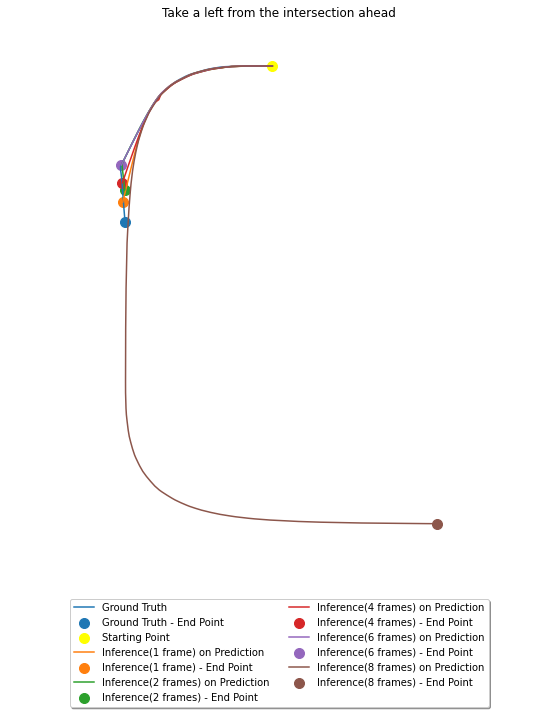

Episode 7: Drive to the corner and go right
(61, 3) (61, 3)
1 frame
Frechet Distance: 128.11745391079916
FDE Distance: 5.497154779719815
ADE Distance: 80.79990649248103
ADE Matched Distance: 72.41010305549231
nDTW Distance: 1.1329108784821624e-141
TC Distance: False
(61, 3) (61, 3)
2 frames
Frechet Distance: 24.17035086989168
FDE Distance: 24.17035086989168
ADE Distance: 7.88560619023901
ADE Matched Distance: 4.153177072999491
nDTW Distance: 0.06302361862762794
TC Distance: False
(61, 3) (61, 3)
4 frames
Frechet Distance: 22.04711880375374
FDE Distance: 22.04711880375374
ADE Distance: 6.469953329171582
ADE Matched Distance: 1.9224948226056564
nDTW Distance: 0.272948563681204
TC Distance: False
(61, 3) (61, 3)
6 frames
Frechet Distance: 28.433672497040813
FDE Distance: 28.43367249704081
ADE Distance: 11.286147634355249
ADE Matched Distance: 5.156914892243405
nDTW Distance: 0.027751134741194526
TC Distance: False
(61, 3) (61, 3)
8 frames
Frechet Distance: 19.57732084708526
FDE Distance: 

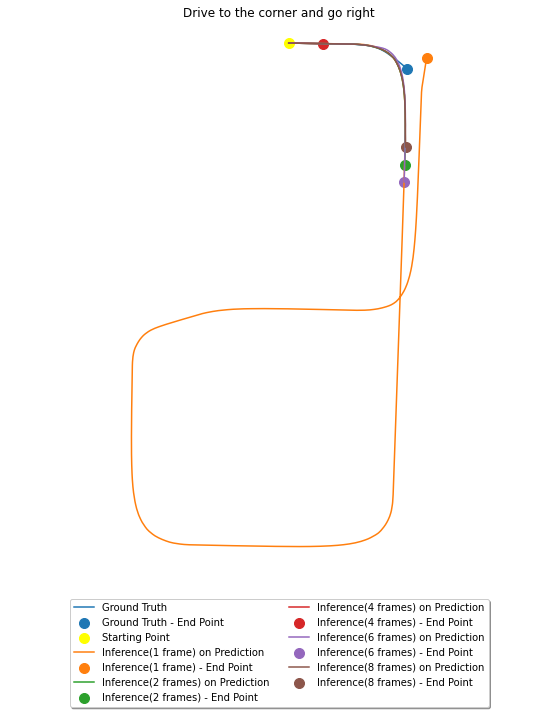

Episode 8: Drive to the intersection and turn left
(83, 3) (83, 3)
1 frame
Frechet Distance: 8.39652352307283
FDE Distance: 8.39652352307283
ADE Distance: 4.490477402806849
ADE Matched Distance: 1.2316923908624384
nDTW Distance: 0.5639378886317885
TC Distance: False
(83, 3) (83, 3)
2 frames
Frechet Distance: 29.85964954004538
FDE Distance: 29.859649540045375
ADE Distance: 16.602557945086918
ADE Matched Distance: 13.576761346387004
nDTW Distance: 5.834738013788759e-05
TC Distance: False
(83, 3) (83, 3)
4 frames
Frechet Distance: 8.493132282538179
FDE Distance: 8.493132282538179
ADE Distance: 12.743785101601903
ADE Matched Distance: 4.011343963664222
nDTW Distance: 0.060038232035198466
TC Distance: False
(83, 3) (83, 3)
6 frames
Frechet Distance: 15.5578694582314
FDE Distance: 15.5578694582314
ADE Distance: 17.198653360296028
ADE Matched Distance: 7.121627297022158
nDTW Distance: 0.0035933885107066856
TC Distance: False
(83, 3) (83, 3)
8 frames
Frechet Distance: 20.22470139997638
FDE Dis

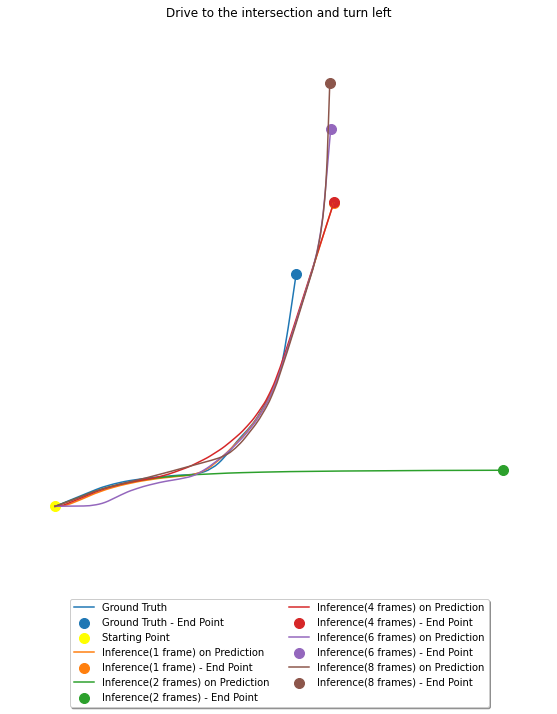

Episode 9: Go straight and stop a few metres ahead of the bus stop
(143, 3) (143, 3)
1 frame
Frechet Distance: 13.29644081174537
FDE Distance: 13.29644081174537
ADE Distance: 9.705339811648052
ADE Matched Distance: 0.7956689344334344
nDTW Distance: 0.8528822468754309
TC Distance: False
(190, 3) (190, 3)
2 frames
Frechet Distance: 25.77402670005138
FDE Distance: 25.77402670005138
ADE Distance: 10.194078744999242
ADE Matched Distance: 7.071317906204381
nDTW Distance: 0.20333357905239927
TC Distance: False
(120, 3) (120, 3)
4 frames
Frechet Distance: 18.82502088613594
FDE Distance: 18.82502088613594
ADE Distance: 13.546725319399282
ADE Matched Distance: 2.8359425038228316
nDTW Distance: 0.5671176502400169
TC Distance: False
(190, 3) (190, 3)
6 frames
Frechet Distance: 29.99150957458776
FDE Distance: 29.991509574587756
ADE Distance: 12.932580656807499
ADE Matched Distance: 10.434152202041922
nDTW Distance: 0.10523280296569186
TC Distance: False
(190, 3) (190, 3)
8 frames
Frechet Distance: 

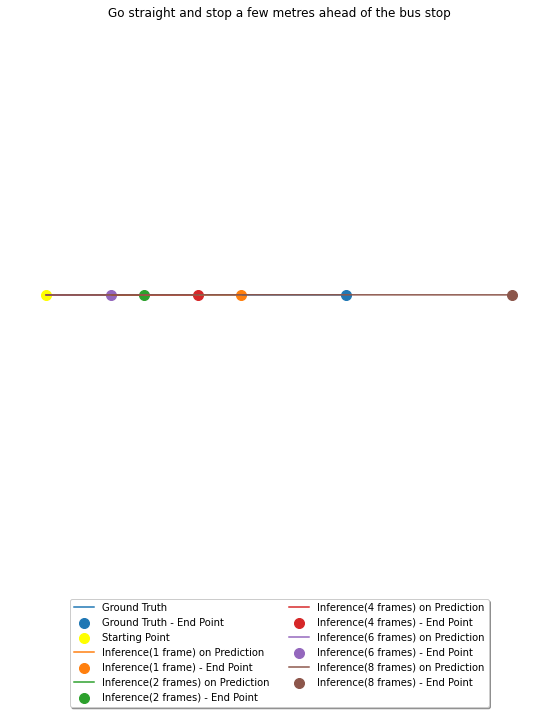

Episode 10: Stop in front of the garbage dumpsters.
(80, 3) (80, 3)
1 frame
Frechet Distance: 12.032764649807218
FDE Distance: 12.032764649807218
ADE Distance: 6.698969558120877
ADE Matched Distance: 0.9199361084301334
nDTW Distance: 0.726383041674874
TC Distance: False
(80, 3) (80, 3)
2 frames
Frechet Distance: 11.234759573296346
FDE Distance: 11.234759573296346
ADE Distance: 17.305681748558374
ADE Matched Distance: 4.880702258261195
nDTW Distance: 0.022215883755837388
TC Distance: False
(80, 3) (80, 3)
4 frames
Frechet Distance: 48.531515734069075
FDE Distance: 48.531515734069075
ADE Distance: 35.3062249160046
ADE Matched Distance: 21.496436323415715
nDTW Distance: 3.168400767567106e-10
TC Distance: False
(80, 3) (80, 3)
6 frames
Frechet Distance: 29.750043722911244
FDE Distance: 29.750043722911244
ADE Distance: 14.58765737824319
ADE Matched Distance: 5.024588143866556
nDTW Distance: 0.044367651309329445
TC Distance: False
(80, 3) (80, 3)
8 frames
Frechet Distance: 31.12113919995733


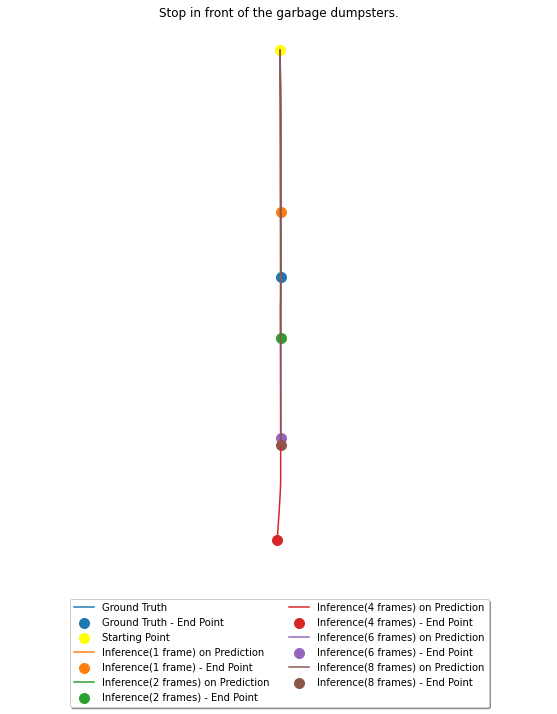

Episode 11: Go straight and stop next to the grey arch.
(107, 3) (107, 3)
1 frame
Frechet Distance: 82.48054615784011
FDE Distance: 19.790364013482474
ADE Distance: 66.90785100314802
ADE Matched Distance: 51.866035193734724
nDTW Distance: 2.2497216675235818e-91
TC Distance: False
(107, 3) (107, 3)
2 frames
Frechet Distance: 9.167236621510623
FDE Distance: 9.167236621510623
ADE Distance: 18.762404620963544
ADE Matched Distance: 3.72222100245137
nDTW Distance: 0.10066577545795692
TC Distance: False
(107, 3) (107, 3)
4 frames
Frechet Distance: 41.375889887625476
FDE Distance: 41.375889887625476
ADE Distance: 36.64628035484313
ADE Matched Distance: 20.27546789810655
nDTW Distance: 3.4365229790969464e-10
TC Distance: False
(107, 3) (107, 3)
6 frames
Frechet Distance: 74.40491325875722
FDE Distance: 69.7647996262257
ADE Distance: 53.889116628235875
ADE Matched Distance: 48.138106306929984
nDTW Distance: 4.717716981298727e-102
TC Distance: False
(107, 3) (107, 3)
8 frames
Frechet Distance: 25

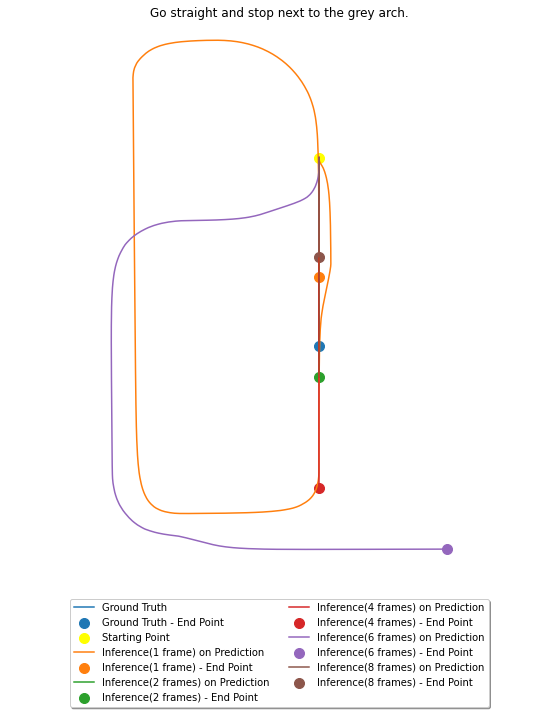

Episode 12: Change lanes and stop at the junction.
(66, 3) (66, 3)
1 frame
Frechet Distance: 8.10835331473003
FDE Distance: 8.10835331473003
ADE Distance: 4.7769575618530125
ADE Matched Distance: 2.621770895904027
nDTW Distance: 0.33407928962059263
TC Distance: False
(66, 3) (66, 3)
2 frames
Frechet Distance: 48.45785488551461
FDE Distance: 48.45785488551461
ADE Distance: 21.990786936677903
ADE Matched Distance: 14.017446097454394
nDTW Distance: 4.0689030044521825e-05
TC Distance: False
(66, 3) (66, 3)
4 frames
Frechet Distance: 12.473473706901364
FDE Distance: 12.473473706901364
ADE Distance: 14.117192796013102
ADE Matched Distance: 7.126699275279864
nDTW Distance: 0.005490971523144419
TC Distance: False
(66, 3) (66, 3)
6 frames
Frechet Distance: 5.509988965578974
FDE Distance: 5.509988965578974
ADE Distance: 4.648796999055095
ADE Matched Distance: 2.6467445789204356
nDTW Distance: 0.17127302026876007
TC Distance: False
(66, 3) (66, 3)
8 frames
Frechet Distance: 12.567851478114004
FDE

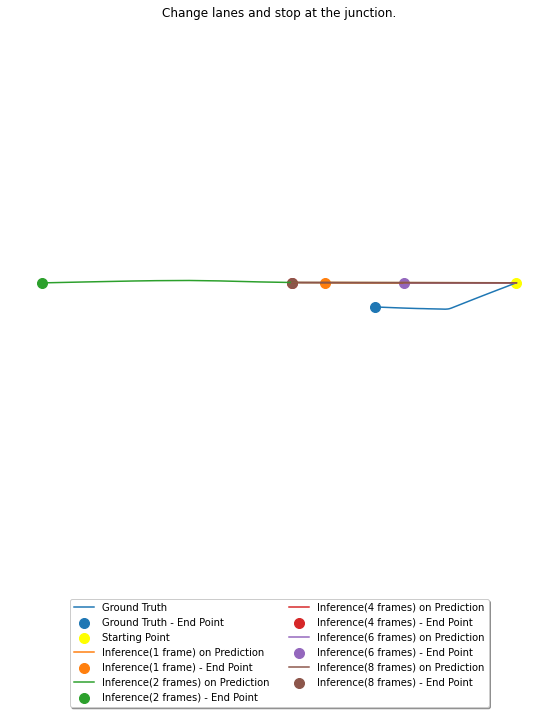

Episode 13: Park on the roadside after you have crossed the bus stop
(60, 3) (60, 3)
1 frame
Frechet Distance: 6.191238700173398
FDE Distance: 6.191238700173399
ADE Distance: 4.857959925492664
ADE Matched Distance: 0.28499616161742275
nDTW Distance: 0.8589900392099372
TC Distance: False
(60, 3) (60, 3)
2 frames
Frechet Distance: 6.392349843041509
FDE Distance: 6.392349843041509
ADE Distance: 4.666917514471719
ADE Matched Distance: 0.2394647982143131
nDTW Distance: 0.8236855083461601
TC Distance: False
(60, 3) (60, 3)
4 frames
Frechet Distance: 8.673508621547523
FDE Distance: 8.673508621547523
ADE Distance: 3.863344221345534
ADE Matched Distance: 0.553455642759258
nDTW Distance: 0.6446325529146809
TC Distance: False
(60, 3) (60, 3)
6 frames
Frechet Distance: 6.351822628676438
FDE Distance: 6.351822628676439
ADE Distance: 2.9358284617155643
ADE Matched Distance: 0.25417017689261395
nDTW Distance: 0.8139324975320544
TC Distance: False
(60, 3) (60, 3)
8 frames
Frechet Distance: 6.351700487

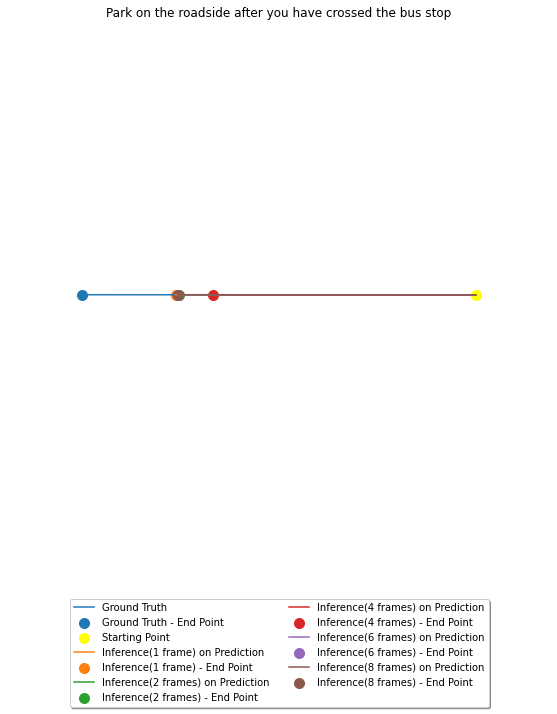

Episode 14: Wait for the signal to turn green and continue straight
(452, 3) (452, 3)
1 frame
Frechet Distance: 22.059989796320068
FDE Distance: 22.059989796320068
ADE Distance: 10.035172670918989
ADE Matched Distance: 2.256109210742668
nDTW Distance: 0.31254889758146814
TC Distance: False
(452, 3) (452, 3)
2 frames
Frechet Distance: 5.937517292189341
FDE Distance: 5.937517292189341
ADE Distance: 12.979491585946011
ADE Matched Distance: 0.8846826831463954
nDTW Distance: 0.6593469024622233
TC Distance: False
(452, 3) (452, 3)
4 frames
Frechet Distance: 255.6826337862504
FDE Distance: 255.6826337862504
ADE Distance: 109.7542536254443
ADE Matched Distance: 101.29642343229754
nDTW Distance: 1.3622294547662134e-40
TC Distance: False
(452, 3) (452, 3)
6 frames
Frechet Distance: 24.18656555699258
FDE Distance: 24.186565556992583
ADE Distance: 3.6838468664786332
ADE Matched Distance: 1.0726303039338003
nDTW Distance: 0.7608048880046506
TC Distance: False
(452, 3) (452, 3)
8 frames
Frechet Dist

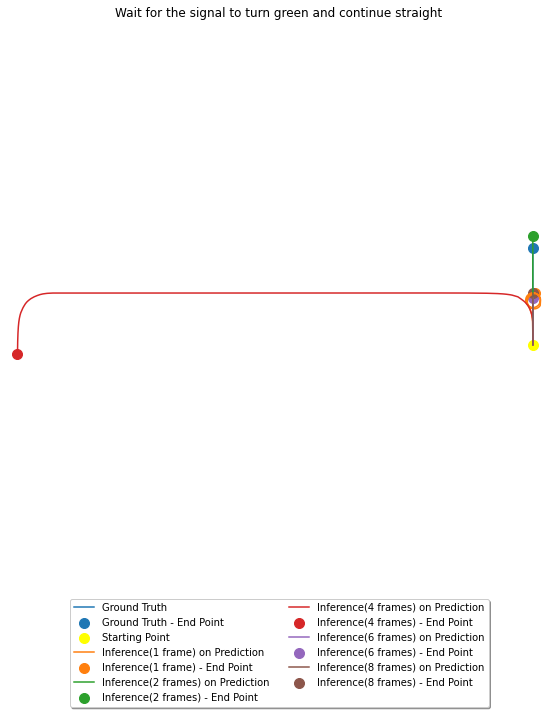

Episode 15: Drive towards the bus stop and park after crossing it
(63, 3) (63, 3)
1 frame
Frechet Distance: 2.7385432281048123
FDE Distance: 2.7385432281048123
ADE Distance: 1.7770939199759077
ADE Matched Distance: 0.1619604369450523
nDTW Distance: 0.929113013588811
TC Distance: True
(63, 3) (63, 3)
2 frames
Frechet Distance: 3.05847374922398
FDE Distance: 3.05847374922398
ADE Distance: 6.450112013956303
ADE Matched Distance: 0.10170829875838612
nDTW Distance: 0.921855641240566
TC Distance: True
(63, 3) (63, 3)
4 frames
Frechet Distance: 14.244627652108072
FDE Distance: 14.244627652108072
ADE Distance: 16.940595694992766
ADE Matched Distance: 6.73410067312858
nDTW Distance: 0.0017110072996868557
TC Distance: False
(63, 3) (63, 3)
6 frames
Frechet Distance: 12.265511845715494
FDE Distance: 12.265511845715492
ADE Distance: 13.714486635050893
ADE Matched Distance: 5.810297987781323
nDTW Distance: 0.004414128813662713
TC Distance: False
(63, 3) (63, 3)
8 frames
Frechet Distance: 26.3165910

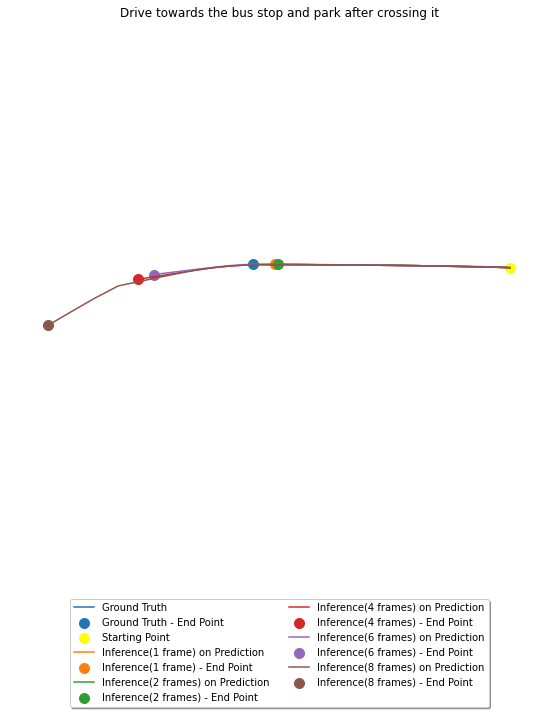

Episode 16: take a right turn and stop across the bench on left
(81, 3) (81, 3)
1 frame
Frechet Distance: 10.561318704828304
FDE Distance: 10.561318704828304
ADE Distance: 4.363446175073526
ADE Matched Distance: 0.9307774576996419
nDTW Distance: 0.6627346109044394
TC Distance: False
(81, 3) (81, 3)
2 frames
Frechet Distance: 2.6337092137350555
FDE Distance: 2.6337092137350555
ADE Distance: 5.120706823887994
ADE Matched Distance: 0.25067974791970965
nDTW Distance: 0.8259183475209521
TC Distance: True
(81, 3) (81, 3)
4 frames
Frechet Distance: 15.231370478673936
FDE Distance: 15.231370478673936
ADE Distance: 13.835328422174758
ADE Matched Distance: 6.045746487271568
nDTW Distance: 0.004113755048796145
TC Distance: False
(81, 3) (81, 3)
6 frames
Frechet Distance: 17.673473443523463
FDE Distance: 17.673473443523463
ADE Distance: 12.474840560634915
ADE Matched Distance: 6.978416328864154
nDTW Distance: 0.0016172383840535173
TC Distance: False
(81, 3) (81, 3)
8 frames
Frechet Distance: 7.533

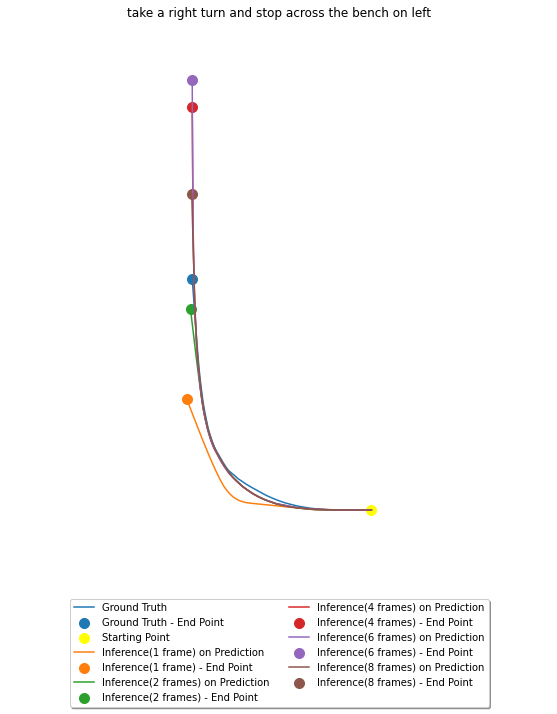

Episode 17: Turn right from the crossroads ahead
(61, 3) (61, 3)
1 frame
Frechet Distance: 0.8232687762726997
FDE Distance: 0.339647384208668
ADE Distance: 1.9892658718631373
ADE Matched Distance: 0.19663945966303692
nDTW Distance: 0.9213830877805498
TC Distance: True
(61, 3) (61, 3)
2 frames
Frechet Distance: 17.520203565136686
FDE Distance: 17.520203565136686
ADE Distance: 16.472431129396277
ADE Matched Distance: 8.848960308153801
nDTW Distance: 0.0002797367258437217
TC Distance: False
(61, 3) (61, 3)
4 frames
Frechet Distance: 30.126614559789854
FDE Distance: 30.126614559789854
ADE Distance: 20.56789499624462
ADE Matched Distance: 16.59612060992989
nDTW Distance: 1.9438270871729728e-07
TC Distance: False
(61, 3) (61, 3)
6 frames
Frechet Distance: 28.597727507566383
FDE Distance: 28.597727507566383
ADE Distance: 17.930359773168647
ADE Matched Distance: 15.8029636471156
nDTW Distance: 3.3067073250530194e-07
TC Distance: False
(61, 3) (61, 3)
8 frames
Frechet Distance: 17.3180139622797

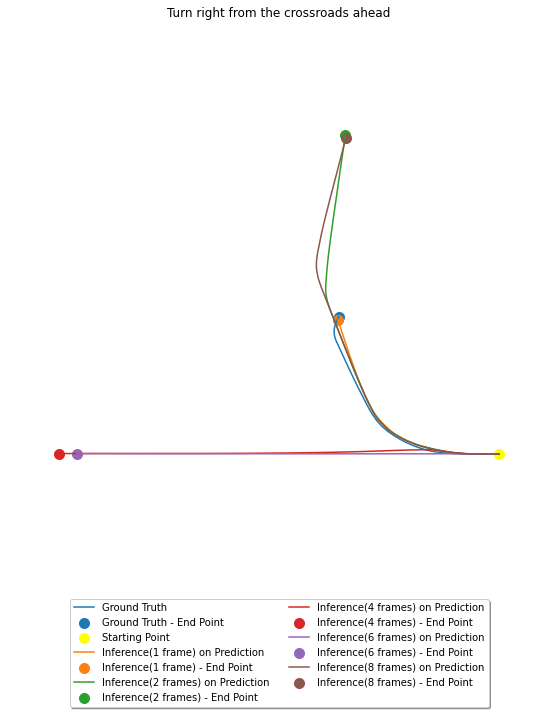

Episode 18: Turn right and park near the sidewalk.
(135, 3) (135, 3)
1 frame
Frechet Distance: 17.235377942891084
FDE Distance: 17.235377942891084
ADE Distance: 4.518552040650586
ADE Matched Distance: 2.62862520572659
nDTW Distance: 0.5911266178361355
TC Distance: False
(156, 3) (156, 3)
2 frames
Frechet Distance: 3.2008465024287878
FDE Distance: 3.2008465024287878
ADE Distance: 14.79986754612275
ADE Matched Distance: 1.68637878511875
nDTW Distance: 0.5353551288116869
TC Distance: True
(156, 3) (156, 3)
4 frames
Frechet Distance: 30.65805541293706
FDE Distance: 30.65805541293706
ADE Distance: 8.865213905688421
ADE Matched Distance: 6.555144798273313
nDTW Distance: 0.22030865850988227
TC Distance: False
(156, 3) (156, 3)
6 frames
Frechet Distance: 28.571771139098487
FDE Distance: 28.571771139098487
ADE Distance: 8.987569701968928
ADE Matched Distance: 4.955574456403801
nDTW Distance: 0.2718712636983641
TC Distance: False
(156, 3) (156, 3)
8 frames
Frechet Distance: 27.91668680945243
FDE

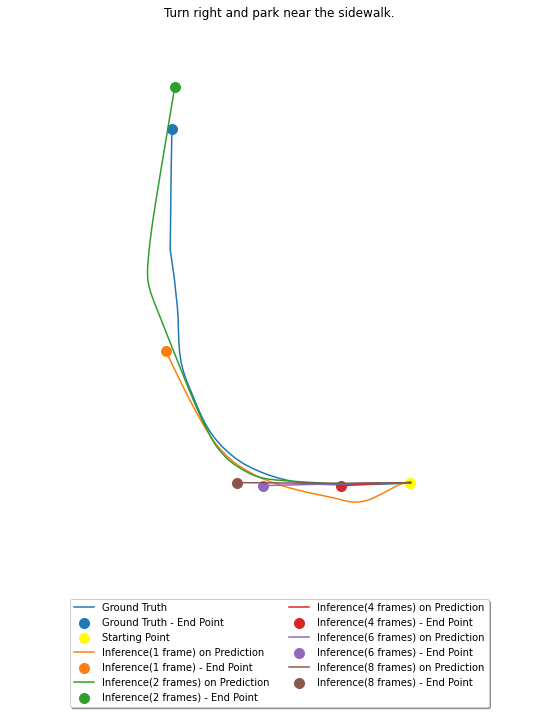

Episode 19: go straight and take a right
(136, 3) (136, 3)
1 frame
Frechet Distance: 12.451849479540398
FDE Distance: 12.451849479540398
ADE Distance: 3.840797515626982
ADE Matched Distance: 1.0754727995951057
nDTW Distance: 0.7288294468432934
TC Distance: False
(136, 3) (136, 3)
2 frames
Frechet Distance: 15.194959690438301
FDE Distance: 15.194959690438301
ADE Distance: 17.38239506070309
ADE Matched Distance: 6.116761330919879
nDTW Distance: 0.049124151598412095
TC Distance: False
(136, 3) (136, 3)
4 frames
Frechet Distance: 30.534036035819927
FDE Distance: 30.534036035819927
ADE Distance: 11.325074900801702
ADE Matched Distance: 8.008202477246012
nDTW Distance: 0.11725879785052958
TC Distance: False
(136, 3) (136, 3)
6 frames
Frechet Distance: 22.189434598855843
FDE Distance: 22.189434598855843
ADE Distance: 5.7080263561659885
ADE Matched Distance: 3.2874379321222076
nDTW Distance: 0.36407196771956285
TC Distance: False
(136, 3) (136, 3)
8 frames
Frechet Distance: 5.877959049993043
F

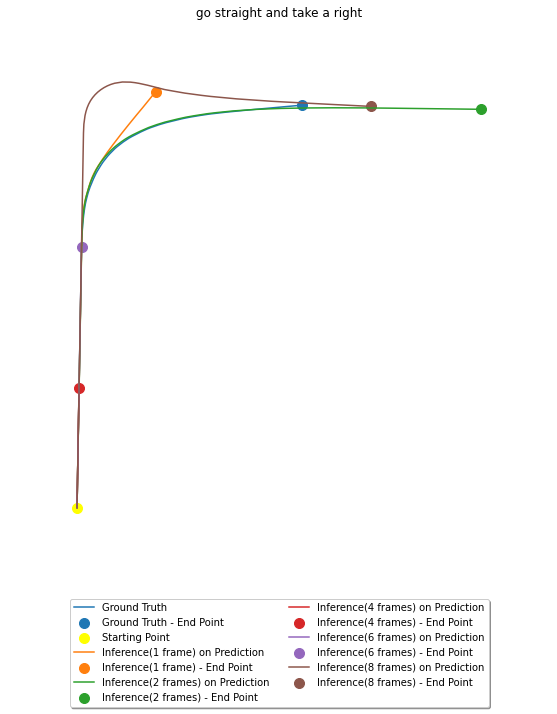

Episode 20: park beside the red volkswagen
(42, 3) (42, 3)
1 frame
Frechet Distance: 20.655712980765216
FDE Distance: 20.655712980765216
ADE Distance: 9.197268955183135
ADE Matched Distance: 6.315987993314371
nDTW Distance: 0.007208561505107662
TC Distance: False
(42, 3) (42, 3)
2 frames
Frechet Distance: 13.432136522668543
FDE Distance: 13.432136522668543
ADE Distance: 14.722462110554265
ADE Matched Distance: 7.846076046701072
nDTW Distance: 0.00012287950458609657
TC Distance: False
(42, 3) (42, 3)
4 frames
Frechet Distance: 1.3260211141906006
FDE Distance: 1.3260211141906004
ADE Distance: 5.621868026648327
ADE Matched Distance: 0.8348558527562719
nDTW Distance: 0.46427776067064824
TC Distance: True
(42, 3) (42, 3)
6 frames
Frechet Distance: 5.89198236190434
FDE Distance: 5.891982361904341
ADE Distance: 8.531739001476987
ADE Matched Distance: 3.406921997234325
nDTW Distance: 0.03314305796057142
TC Distance: False
(42, 3) (42, 3)
8 frames
Frechet Distance: 10.737687763380622
FDE Distan

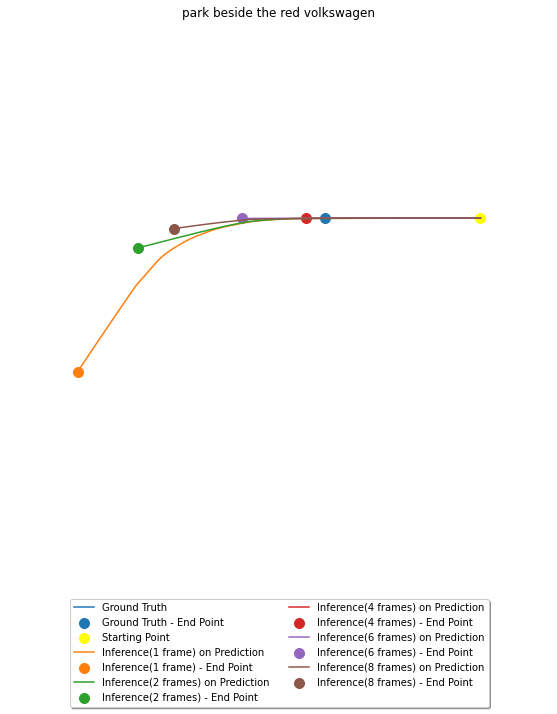

Episode 21: Turn left from the next crossroads
(147, 3) (147, 3)
1 frame
Frechet Distance: 216.76374970234275
FDE Distance: 19.93742059109319
ADE Distance: 75.2470882945231
ADE Matched Distance: 67.62430592537757
nDTW Distance: 2.5873820333276415e-88
TC Distance: False
(147, 3) (147, 3)
2 frames
Frechet Distance: 35.956231260419685
FDE Distance: 35.956231260419685
ADE Distance: 12.0369963430273
ADE Matched Distance: 3.8235234156617657
nDTW Distance: 0.01082601519869344
TC Distance: False
(147, 3) (147, 3)
4 frames
Frechet Distance: 31.574258560374325
FDE Distance: 31.574258560374325
ADE Distance: 9.434711108825006
ADE Matched Distance: 1.9373962744866822
nDTW Distance: 0.19254106725101905
TC Distance: False
(147, 3) (147, 3)
6 frames
Frechet Distance: 5.881346752307017
FDE Distance: 5.881346752307017
ADE Distance: 4.211716847978357
ADE Matched Distance: 0.37063523658545267
nDTW Distance: 0.6540368007930779
TC Distance: False
(147, 3) (147, 3)
8 frames
Frechet Distance: 30.6532341078732

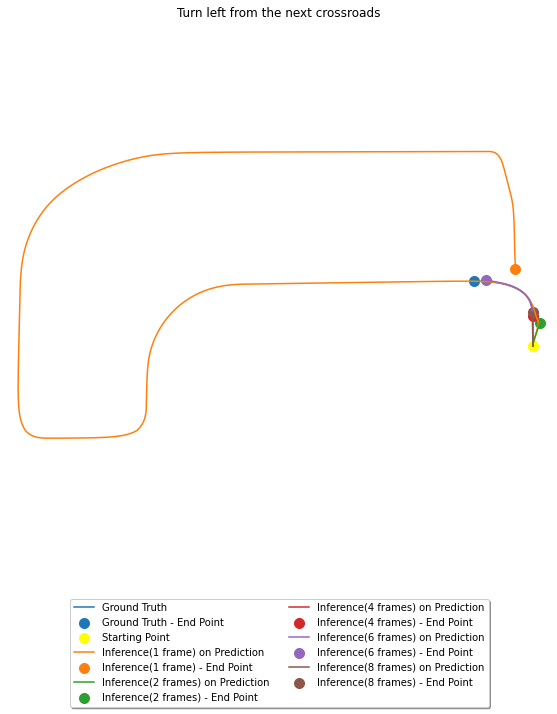

Episode 22: Turn right from the crossroads.
(66, 3) (66, 3)
1 frame
Frechet Distance: 3.128151981904482
FDE Distance: 3.1281519819044816
ADE Distance: 1.5140040598030988
ADE Matched Distance: 0.47142048990104546
nDTW Distance: 0.7590333529698833
TC Distance: True
(66, 3) (66, 3)
2 frames
Frechet Distance: 4.022753791791499
FDE Distance: 4.022753791791499
ADE Distance: 3.809569089587176
ADE Matched Distance: 0.2888177658655067
nDTW Distance: 0.7923083569204833
TC Distance: True
(66, 3) (66, 3)
4 frames
Frechet Distance: 8.793032369400612
FDE Distance: 8.793032369400612
ADE Distance: 11.413606903950585
ADE Matched Distance: 4.150226908245946
nDTW Distance: 0.02541738242593524
TC Distance: False
(66, 3) (66, 3)
6 frames
Frechet Distance: 30.50765832522495
FDE Distance: 30.50765832522495
ADE Distance: 16.852373171426596
ADE Matched Distance: 16.62808996943333
nDTW Distance: 5.241963766332787e-07
TC Distance: False
(66, 3) (66, 3)
8 frames
Frechet Distance: 17.62333456805363
FDE Distance: 1

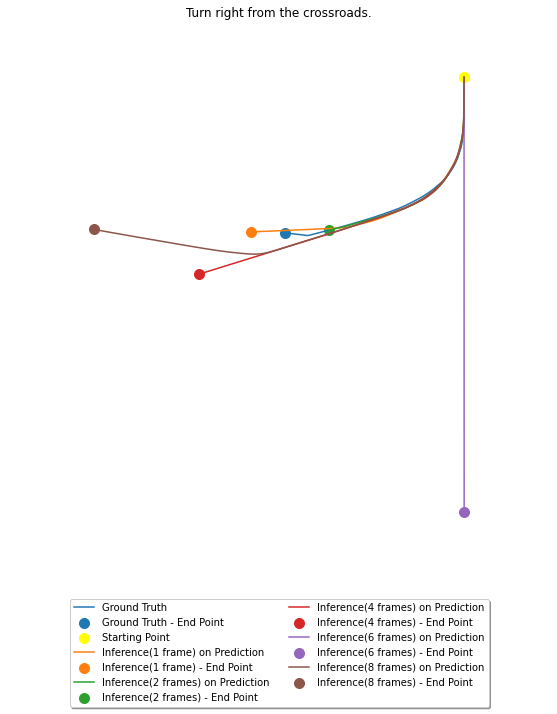

Episode 23: stop by the lamp post
(71, 3) (71, 3)
1 frame
Frechet Distance: 3.395626179829482
FDE Distance: 3.395626179829482
ADE Distance: 2.2123765891913387
ADE Matched Distance: 0.39761397811224497
nDTW Distance: 0.8615990662585112
TC Distance: True
(71, 3) (71, 3)
2 frames
Frechet Distance: 5.738932894529038
FDE Distance: 5.738932894529038
ADE Distance: 9.55450938552202
ADE Matched Distance: 2.901527988671304
nDTW Distance: 0.13173236757946644
TC Distance: False
(71, 3) (71, 3)
4 frames
Frechet Distance: 9.573617422332811
FDE Distance: 9.573617422332811
ADE Distance: 14.04796225700217
ADE Matched Distance: 4.8117391434846875
nDTW Distance: 0.03197613384851451
TC Distance: False
(71, 3) (71, 3)
6 frames
Frechet Distance: 21.841074858959306
FDE Distance: 21.841074858959306
ADE Distance: 16.208507408556176
ADE Matched Distance: 11.062040230446835
nDTW Distance: 9.27241447414038e-05
TC Distance: False
(71, 3) (71, 3)
8 frames
Frechet Distance: 5.766491435465946
FDE Distance: 5.76649143

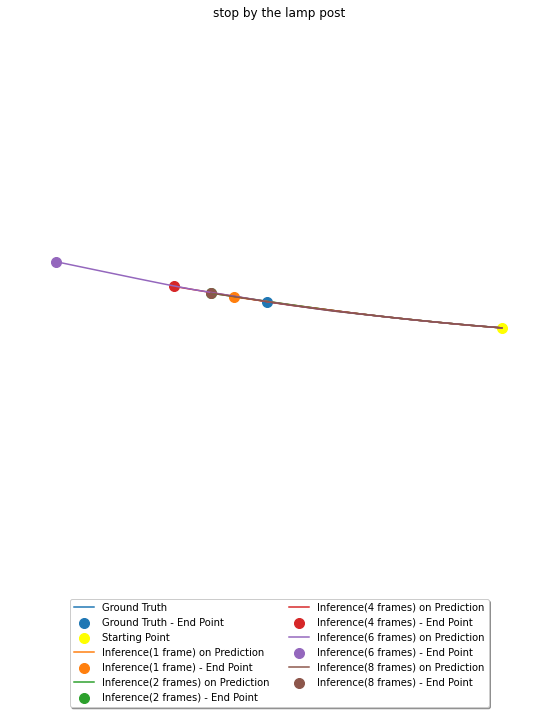

Episode 24: park immediately after the signboard
(50, 3) (50, 3)
1 frame
Frechet Distance: 107.66529276989893
FDE Distance: 107.66529276989891
ADE Distance: 47.06180768579796
ADE Matched Distance: 45.46409924863881
nDTW Distance: 7.64529454752957e-29
TC Distance: False
(50, 3) (50, 3)
2 frames
Frechet Distance: 7.242481258541442
FDE Distance: 7.242481258541442
ADE Distance: 7.089378805489037
ADE Matched Distance: 4.0530411288504515
nDTW Distance: 0.021795084295746343
TC Distance: False
(50, 3) (50, 3)
4 frames
Frechet Distance: 1.8779292833790167
FDE Distance: 1.8779292833790167
ADE Distance: 8.235990306020891
ADE Matched Distance: 1.0460203839716467
nDTW Distance: 0.4067414594246192
TC Distance: True
(50, 3) (50, 3)
6 frames
Frechet Distance: 7.554308086873363
FDE Distance: 7.5543080868733625
ADE Distance: 9.946080861633233
ADE Matched Distance: 4.157281990162814
nDTW Distance: 0.018176607050848097
TC Distance: False
(50, 3) (50, 3)
8 frames
Frechet Distance: 18.75389043815197
FDE Dis

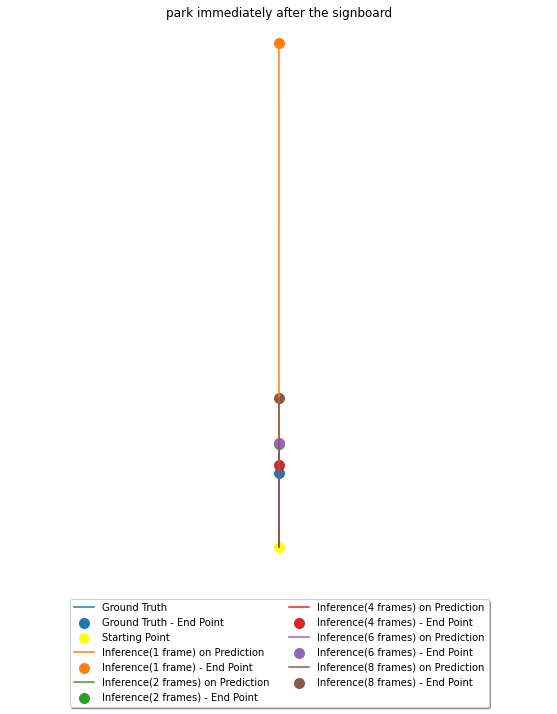

Episode 25: Turn right and stop beside the traffic signal
(152, 3) (152, 3)
1 frame
Frechet Distance: 37.45301536122004
FDE Distance: 37.45301536122004
ADE Distance: 20.325493692376927
ADE Matched Distance: 16.50681097323746
nDTW Distance: 0.03683295955221878
TC Distance: False
(176, 3) (176, 3)
2 frames
Frechet Distance: 57.95692637027725
FDE Distance: 57.95692637027725
ADE Distance: 37.713261496476896
ADE Matched Distance: 36.83678434590785
nDTW Distance: 1.961608332634894e-14
TC Distance: False
(176, 3) (176, 3)
4 frames
Frechet Distance: 4.9600488037808255
FDE Distance: 4.9600488037808255
ADE Distance: 8.942418302538425
ADE Matched Distance: 0.1680064859329788
nDTW Distance: 0.9001490032726539
TC Distance: True
(176, 3) (176, 3)
6 frames
Frechet Distance: 18.792091120681075
FDE Distance: 18.792091120681075
ADE Distance: 10.734101019423479
ADE Matched Distance: 1.1476733769800085
nDTW Distance: 0.5866028373919345
TC Distance: False
(176, 3) (176, 3)
8 frames
Frechet Distance: 36.598

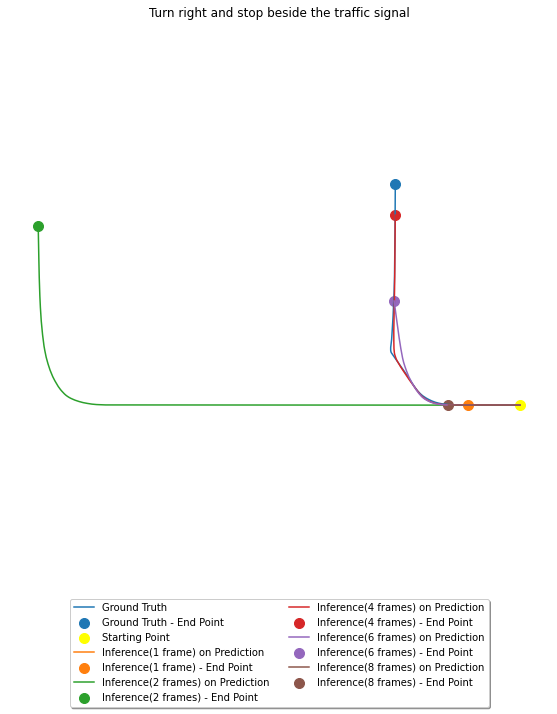

Episode 26: Turn left and stop near the traffic signal
(161, 3) (161, 3)
1 frame
Frechet Distance: 34.88811936802611
FDE Distance: 34.88811936802611
ADE Distance: 32.28272437108441
ADE Matched Distance: 18.80766904536754
nDTW Distance: 0.023248054936965065
TC Distance: False
(406, 3) (406, 3)
2 frames
Frechet Distance: 42.86394324877267
FDE Distance: 42.86394324877267
ADE Distance: 14.264752461475341
ADE Matched Distance: 10.1402259498699
nDTW Distance: 0.01793279564470798
TC Distance: False
(406, 3) (406, 3)
4 frames
Frechet Distance: 255.1290635689402
FDE Distance: 255.1290635689402
ADE Distance: 181.1055086729174
ADE Matched Distance: 149.98296920300075
nDTW Distance: 1.2706307169986296e-62
TC Distance: False
(406, 3) (406, 3)
6 frames
Frechet Distance: 232.65413297754918
FDE Distance: 232.65413297754918
ADE Distance: 155.1963513109697
ADE Matched Distance: 131.05201380268653
nDTW Distance: 2.172204137771083e-36
TC Distance: False
(217, 3) (217, 3)
8 frames
Frechet Distance: 61.8775

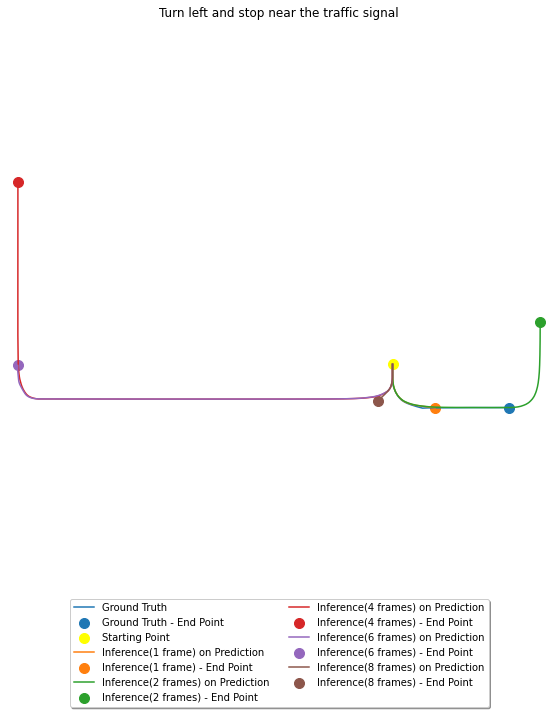

Episode 27: Turn left and stop near the intersection
(358, 3) (358, 3)
1 frame
Frechet Distance: 10.244109782134549
FDE Distance: 10.244109782134549
ADE Distance: 8.183918199652044
ADE Matched Distance: 1.6057632686554932
nDTW Distance: 0.439674676199242
TC Distance: False
(358, 3) (358, 3)
2 frames
Frechet Distance: 50.26564460169776
FDE Distance: 50.26564460169776
ADE Distance: 36.44896981693655
ADE Matched Distance: 21.100742159244263
nDTW Distance: 0.0003848415825529533
TC Distance: False
(358, 3) (358, 3)
4 frames
Frechet Distance: 112.15469985772698
FDE Distance: 35.83792043540663
ADE Distance: 48.637223595726
ADE Matched Distance: 40.93463231101036
nDTW Distance: 2.860140937607091e-29
TC Distance: False
(358, 3) (358, 3)
6 frames
Frechet Distance: 46.44827389343058
FDE Distance: 46.44827389343058
ADE Distance: 37.20195177589567
ADE Matched Distance: 26.144705641838076
nDTW Distance: 0.001571313294415269
TC Distance: False
(358, 3) (358, 3)
8 frames
Frechet Distance: 49.343800137

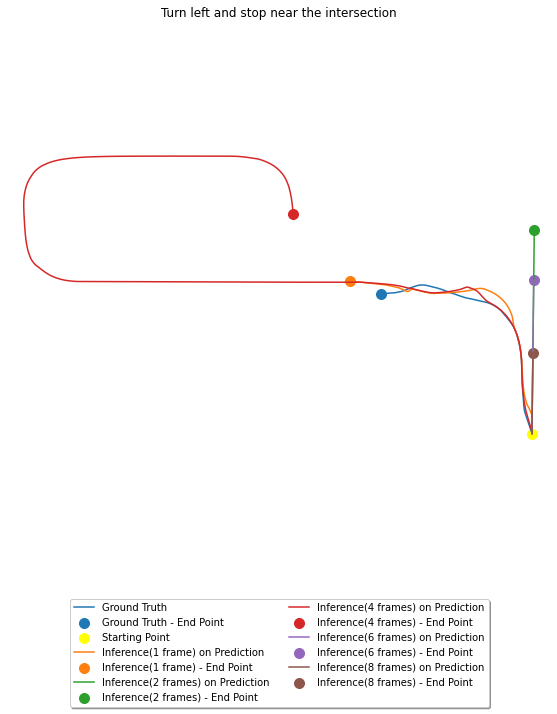

Episode 28: Turn left and come to a halt at the intersection
(153, 3) (153, 3)
1 frame
Frechet Distance: 58.28782966162631
FDE Distance: 58.28782966162631
ADE Distance: 47.325465920594596
ADE Matched Distance: 30.96819759007295
nDTW Distance: 0.0020423799315219676
TC Distance: False
(243, 3) (243, 3)
2 frames
Frechet Distance: 61.72876619506577
FDE Distance: 61.72876619506577
ADE Distance: 41.8803613828283
ADE Matched Distance: 33.953971305578314
nDTW Distance: 0.0011240756099709288
TC Distance: False
(275, 3) (275, 3)
4 frames
Frechet Distance: 56.16408213392697
FDE Distance: 56.16408213392697
ADE Distance: 37.418087039870485
ADE Matched Distance: 29.147687555457612
nDTW Distance: 0.0029394361225090477
TC Distance: False
(651, 3) (651, 3)
6 frames
Frechet Distance: 1.1568098456576317
FDE Distance: 0.07355157061962017
ADE Distance: 8.35590524190157
ADE Matched Distance: 0.21291063543699182
nDTW Distance: 0.9583117589354389
TC Distance: True
(430, 3) (430, 3)
8 frames
Frechet Distance: 

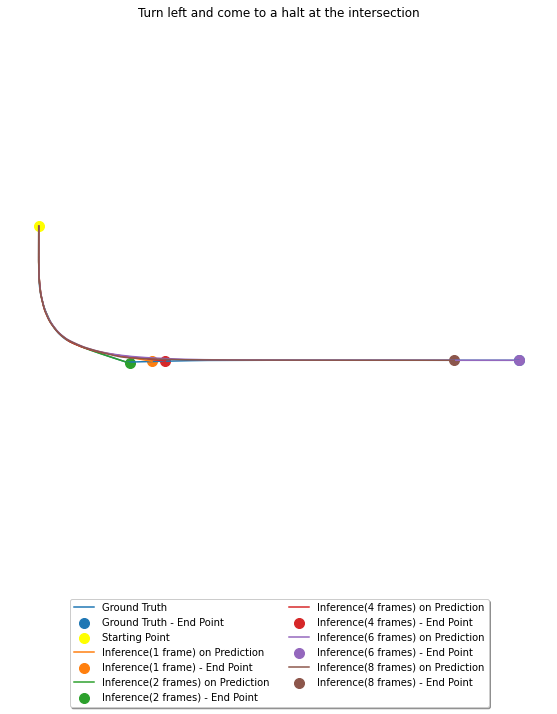

Episode 29: Turn right and stop before the traffic signal
(194, 3) (194, 3)
1 frame
Frechet Distance: 159.88685544019245
FDE Distance: 100.83138052179918
ADE Distance: 105.86387799772004
ADE Matched Distance: 80.54084113531876
nDTW Distance: 7.786985166805357e-109
TC Distance: False
(194, 3) (194, 3)
2 frames
Frechet Distance: 18.613057292086133
FDE Distance: 18.613057292086133
ADE Distance: 13.629842103462298
ADE Matched Distance: 6.1557863007845794
nDTW Distance: 0.17684090290891089
TC Distance: False
(194, 3) (194, 3)
4 frames
Frechet Distance: 2.0836645667909606
FDE Distance: 2.0836645667909606
ADE Distance: 9.82169737782958
ADE Matched Distance: 0.1362583280974405
nDTW Distance: 0.8944599348986954
TC Distance: True
(194, 3) (194, 3)
6 frames
Frechet Distance: 10.243637139619787
FDE Distance: 10.243637139619787
ADE Distance: 8.552267896285539
ADE Matched Distance: 0.35959956241209945
nDTW Distance: 0.7270062310393396
TC Distance: False
(170, 3) (170, 3)
8 frames
Frechet Distance: 1

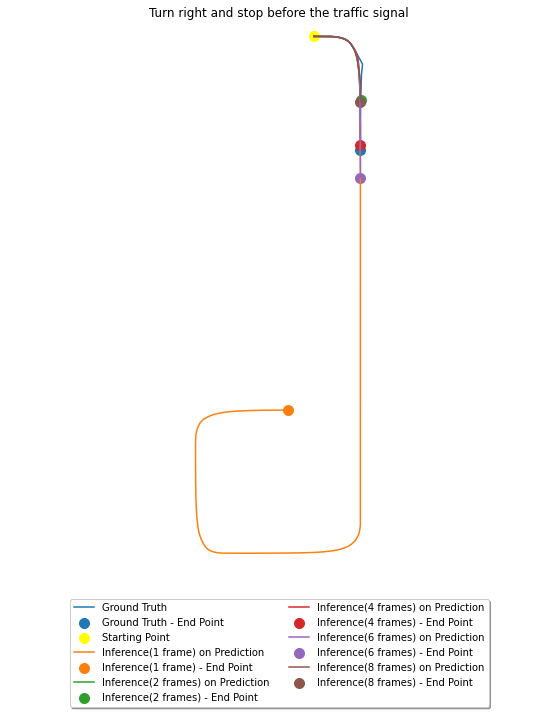

Episode 30: Turn right and stop just before the traffic signal
(153, 3) (153, 3)
1 frame
Frechet Distance: 73.49516262605972
FDE Distance: 73.49516262605972
ADE Distance: 30.298873009164772
ADE Matched Distance: 22.103657184453976
nDTW Distance: 1.7046009672629064e-05
TC Distance: False
(153, 3) (153, 3)
2 frames
Frechet Distance: 20.82794206594085
FDE Distance: 20.82794206594085
ADE Distance: 11.136356461573559
ADE Matched Distance: 4.267234248422934
nDTW Distance: 0.013864960949583761
TC Distance: False
(153, 3) (153, 3)
4 frames
Frechet Distance: 26.5522999691967
FDE Distance: 26.5522999691967
ADE Distance: 12.515911694137108
ADE Matched Distance: 3.899353968162491
nDTW Distance: 0.19974503822658538
TC Distance: False
(153, 3) (153, 3)
6 frames
Frechet Distance: 16.73428829732003
FDE Distance: 16.73428829732003
ADE Distance: 6.891627040652832
ADE Matched Distance: 1.8556719428855069
nDTW Distance: 0.44477408673665886
TC Distance: False
(153, 3) (153, 3)
8 frames
Frechet Distance: 31

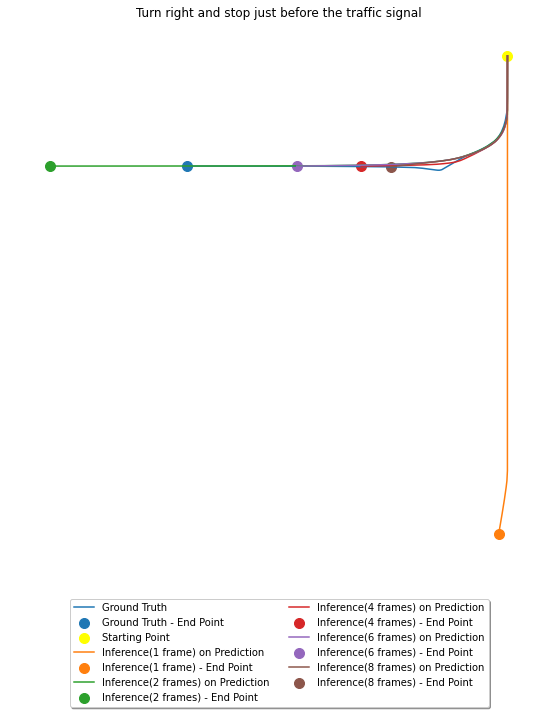

In [23]:
val_data_path = '/ssd_scratch/cvit/varunc/carla_data/test'
val_run_paths = ['/ssd_scratch/cvit/varunc/ablation_runs/test_clip1/','/ssd_scratch/cvit/varunc/ablation_runs/test_clip2/',
                '/ssd_scratch/cvit/varunc/ablation_runs/test_clip4/','/ssd_scratch/cvit/varunc/ablation_runs/test_clip6_1/',
                '/ssd_scratch/cvit/varunc/ablation_runs/test_clip8/',]
names = ['1 frame','2 frames',
        '4 frames','6 frames',
        '8 frames']
save_loc = '../trajectories_test/'

frechet_test_all,fde_test_all,ade_test_all, ade_matched_test_all, ndtw_test_all, tc_test_clip_all = get_scores_comp(val_data_path, val_run_paths,names, save_loc,episodes=list(range(0,31)))

Median:
CLIP-VC     8.764641
CLIP-V     22.057594
CLIP       26.325710
CLIP-C     16.705065
RNR-C      27.943809
RNR        32.086222
dtype: float64
CLIP-VC    15.067422
CLIP-V     53.104420
CLIP       42.530106
CLIP-C     38.489281
RNR-C      44.653170
RNR        42.455355
dtype: float64


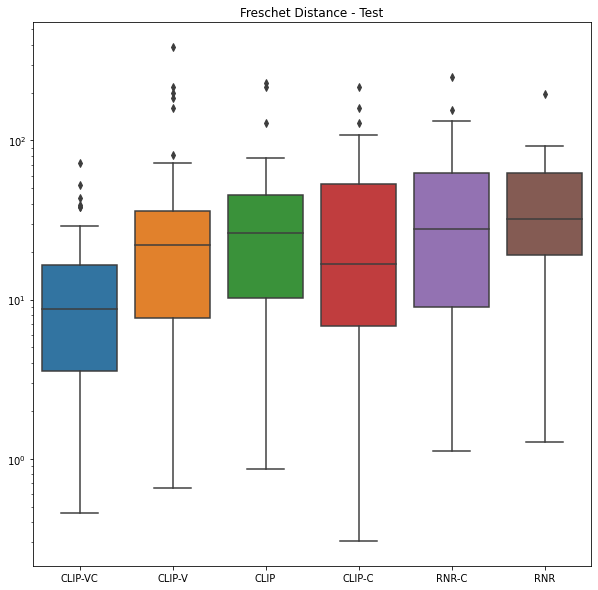

In [24]:
plt.figure(figsize=(10,10))
names = ['1 frame','2 frames',
        '4 frames','6 frames (1)',
        '6 frames (2)','8 frames']

f_df = deinterlace(frechet_test_all,names)
g = sns.boxplot(data=f_df)
g.set_yscale("log")
# g.set_ylim([-5,60])
plt.title('Freschet Distance - Test')
print('Median:')
print(f_df.median())
print(f_df.mean())

Median:
CLIP-VC    0.686614
CLIP-V     0.034882
CLIP       0.093973
CLIP-C     0.323314
RNR-C      0.224645
RNR        0.000362
dtype: float64
CLIP-VC    0.590258
CLIP-V     0.264605
CLIP       0.242909
CLIP-C     0.396044
RNR-C      0.333578
RNR        0.162495
dtype: float64


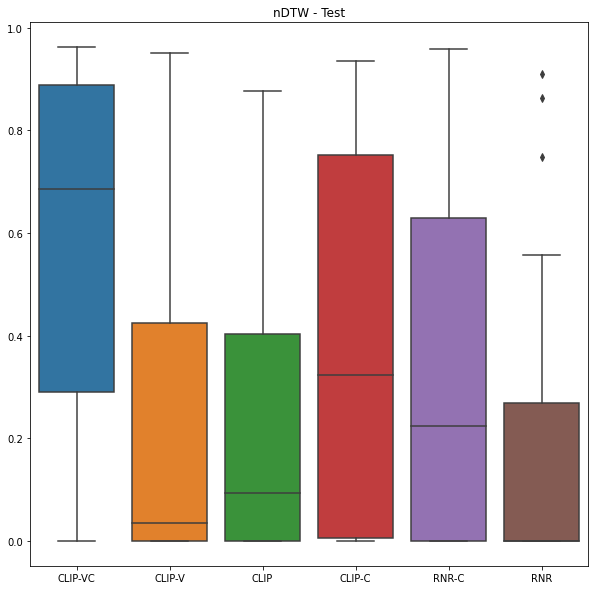

In [25]:
plt.figure(figsize=(10,10))
names = ['CLIP-VC','CLIP-V',
         'CLIP','CLIP-C',
         'RNR-C','RNR']

f_df = deinterlace(ndtw_test_all,names)
g = sns.boxplot(data=f_df)
# g.set_yscale("log")
# g.set_ylim([-5,60])
plt.title('nDTW - Test')
print('Median:')
print(f_df.median())
print(f_df.mean())

In [27]:
tc_val = pd.read_csv('task_completion_val.csv',header=None)

tc_val_interlaced = tc_val.values.flatten()

In [28]:
tc_test = pd.read_csv('task_completion_test.csv',header=None)

tc_test_interlaced = tc_test.values.flatten()

In [29]:
names = ['CLIP-VC','CLIP-V',
         'CLIP','CLIP-C',
         'RNR-C','RNR']
results = {
    'val':{
        'frechet': deinterlace(frechet_val_all,names,df=False),
        'fde': deinterlace(fde_val_all,names,df=False),
        'ade':deinterlace(ade_val_all,names,df=False),
        'ade_match':deinterlace(ade_matched_val_all,names,df=False),
        'tc':deinterlace(tc_val_interlaced,names,df=False),
        'nDTW':deinterlace(ndtw_val_all,names,df=False),
    },
    'test':
    {
        'frechet': deinterlace(frechet_test_all,names,df=False),
        'fde': deinterlace(fde_test_all,names,df=False),
        'ade':deinterlace(ade_test_all,names,df=False),
        'ade_match':deinterlace(ade_matched_test_all,names,df=False),
        'tc':deinterlace(tc_test_interlaced,names,df=False),
        'nDTW':deinterlace(ndtw_test_all,names,df=False),
    },
}

In [196]:
names = ['CLIP-VC','CLIP-V',
         'CLIP','CLIP-C',
         'RNR-C','RNR']
results = {
    'val':{
        'frechet': deinterlace(frechet_val_all,names,df=False,tc_scores=tc_val_interlaced),
        'fde': deinterlace(fde_val_all,names,df=False,tc_scores=tc_val_interlaced),
        'ade':deinterlace(ade_val_all,names,df=False,tc_scores=tc_val_interlaced),
        'ade_match':deinterlace(ade_matched_val_all,names,df=False,tc_scores=tc_val_interlaced),
        'tc':deinterlace(tc_val_interlaced,names,df=False,tc_scores=tc_val_interlaced),
        'nDTW':deinterlace(ndtw_val_all,names,df=False,tc_scores=tc_val_interlaced),
    },
    'test':
    {
        'frechet': deinterlace(frechet_test_all,names,df=False,tc_scores=tc_test_interlaced),
        'fde': deinterlace(fde_test_all,names,df=False,tc_scores=tc_test_interlaced),
        'ade':deinterlace(ade_test_all,names,df=False,tc_scores=tc_test_interlaced),
        'ade_match':deinterlace(ade_matched_test_all,names,df=False,tc_scores=tc_test_interlaced),
        'tc':deinterlace(tc_test_interlaced,names,df=False,tc_scores=tc_test_interlaced),
        'nDTW':deinterlace(ndtw_test_all,names,df=False,tc_scores=tc_test_interlaced),
    },
}

Median:
CLIP-VC    0.594053
CLIP-V     0.513309
CLIP       0.056152
CLIP-C     0.413312
RNR-C      0.535384
RNR        0.043633
dtype: float64
CLIP-VC    0.544586
CLIP-V     0.391472
CLIP       0.234323
CLIP-C     0.364007
RNR-C      0.456151
RNR        0.354813
dtype: float64


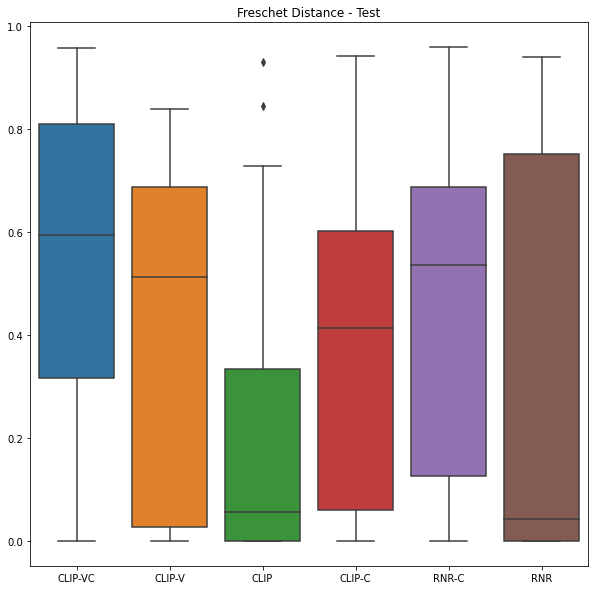

In [30]:
plt.figure(figsize=(10,10))
f_df = pd.DataFrame(results['val']['nDTW'])
g = sns.boxplot(data=f_df)
# g.set_yscale("log")
# g.set_ylim([-5,60])
plt.title('Freschet Distance - Test')
print('Median:')
print(f_df.median())
print(f_df.mean())


In [49]:
results_val_df = pd.DataFrame.from_dict({(i,j): results['val'][i][j] 
                           for i in results['val'].keys() 
                           for j in results['val'][i].keys()},
                       orient='index')
results_val_df.index = pd.MultiIndex.from_tuples(results_val_df.index)
results_val_df.index.names = ['Meteric', 'Model']

results_test_df = pd.DataFrame.from_dict({(i,j): results['test'][i][j] 
                           for i in results['test'].keys() 
                           for j in results['test'][i].keys()},
                       orient='index')
results_test_df.index = pd.MultiIndex.from_tuples(results_test_df.index)
results_test_df.index.names = ['Meteric', 'Model']

In [50]:
results_val_df.quantile(q=0.75,axis=1)-results_val_df.quantile(q=0.25,axis=1)

Meteric    Model  
frechet    CLIP-VC    14.197309
           CLIP-V     33.593829
           CLIP       27.657398
           CLIP-C     36.285574
           RNR-C      32.685383
           RNR        41.805231
fde        CLIP-VC    14.197309
           CLIP-V     33.593829
           CLIP       27.232069
           CLIP-C     30.643589
           RNR-C      32.685383
           RNR        41.805231
ade        CLIP-VC     5.271020
           CLIP-V     10.155182
           CLIP       14.221720
           CLIP-C     13.267404
           RNR-C       7.606991
           RNR        13.704834
ade_match  CLIP-VC     2.229447
           CLIP-V      8.721920
           CLIP        7.923658
           CLIP-C      6.880892
           RNR-C       2.950179
           RNR        12.413291
tc         CLIP-VC     0.000000
           CLIP-V      1.000000
           CLIP        1.000000
           CLIP-C      1.000000
           RNR-C       1.000000
           RNR         1.000000
nDTW       CLIP-VC   

In [205]:
val_summary = pd.DataFrame({
    'mean':results_val_df.mean(axis=1),
    'median':results_val_df.median(axis=1),
    'std':results_val_df.std(axis=1),
    'IQR':results_val_df.quantile(q=0.75,axis=1)-results_val_df.quantile(q=0.25,axis=1),
}).T
test_summary = pd.DataFrame({
    'mean':results_test_df.mean(axis=1),
    'median':results_test_df.median(axis=1),
    'std':results_test_df.std(axis=1),
    'IQR':results_test_df.quantile(q=0.75,axis=1)-results_val_df.quantile(q=0.25,axis=1),
}).T


In [212]:
val_summary.to_csv('val_results.csv')
test_summary.to_csv('test_results.csv')


In [211]:
test_summary['tc']

Model    CLIP-VC    CLIP-V      CLIP    CLIP-C     RNR-C       RNR
mean    0.735294  0.529412  0.470588  0.500000  0.323529  0.294118
median  1.000000  1.000000  0.000000  0.500000  0.000000  0.000000
std     0.447811  0.506640  0.506640  0.507519  0.474858  0.462497
IQR     0.000000  1.000000  1.000000  1.000000  1.000000  1.000000

CLIP-context         0.276173
CLIP no context      0.062172
CLIP-single-nocon    0.515694
CLIP-single-con      0.040471
RNR-Context          0.150810
RNR                  0.517124
dtype: float64
CLIP-context         0.363549
CLIP no context      0.204092
CLIP-single-nocon    0.431974
CLIP-single-con      0.334550
RNR-Context          0.372392
RNR                  0.456953
dtype: float64


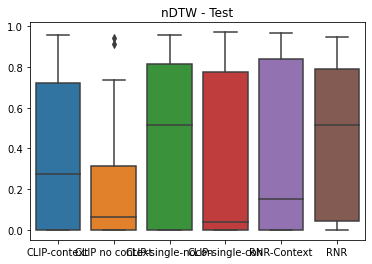

In [128]:
names = ['CLIP-context','CLIP no context',
         'CLIP-single-nocon','CLIP-single-con',
         'RNR-Context','RNR']
n_df = deinterlace(ndtw_test_all,names)
g = sns.boxplot(data=n_df)
# g.set_yscale("log")
# g.set_ylim([-5,60])
plt.title('nDTW - Test')
print(n_df.median())
print(n_df.mean())

CLIP-context         0.654810
CLIP no context      0.138249
CLIP-single-nocon    0.093973
RNR-Context          0.224645
RNR                  0.000362
dtype: float64
CLIP-context         0.562131
CLIP no context      0.318528
CLIP-single-nocon    0.242909
RNR-Context          0.333578
RNR                  0.162495
dtype: float64


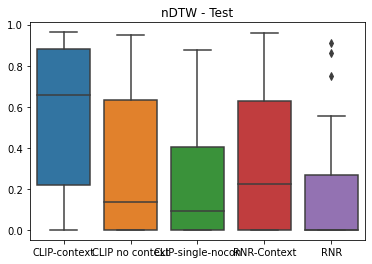

In [36]:
names = ['CLIP-context','CLIP no context',
         'CLIP-single-nocon',
         'RNR-Context','RNR']
n_df = deinterlace(ndtw_test_all,names)
g = sns.boxplot(data=n_df)
# g.set_yscale("log")
# g.set_ylim([-5,60])
plt.title('nDTW - Test')
print(n_df.median())
print(n_df.mean())

In [104]:
print(f_df.median(),n_df.median())

CLIP-con              8.523169
CLIP-nocon           13.971223
CLIP-single-nocon    29.240288
Conv3D               37.757654
RNR-con              12.294415
RNR                  14.640022
dtype: float64 CLIP-con             0.654810
CLIP-nocon           0.138249
CLIP-single-nocon    0.093973
Conv3D               0.000216
RNR-con              0.224645
RNR                  0.000362
dtype: float64


In [105]:
np.log(n_df).median()

CLIP-con            -0.424346
CLIP-nocon          -1.978710
CLIP-single-nocon   -2.367700
Conv3D              -8.534804
RNR-con             -1.521231
RNR                 -7.996281
dtype: float64

subplotting
(45, 3) (45, 3)
Episode 11: Stop after crossing the stop signboard
Frechet Distance: 4.292999998566482
FDE Distance: 4.292999998566482
ADE Distance: 1.41057447310484
ADE Matched Distance: 0.32901731512846294
nDTW Distance: 0.8564119977013522
TC Distance: True
subplotting
(73, 3) (73, 3)
Episode 14: Drive straight till the intersection and then turn left
Frechet Distance: 10.80607305872367
FDE Distance: 10.80607305872367
ADE Distance: 8.74487304027145
ADE Matched Distance: 0.3058122732603196
nDTW Distance: 0.6297145243847043
TC Distance: False
[<matplotlib.lines.Line2D object at 0x7f93d24d2a50>, <matplotlib.lines.Line2D object at 0x7f93d24d2650>, <matplotlib.collections.PathCollection object at 0x7f93d24d2590>, <matplotlib.collections.PathCollection object at 0x7f93b57ae0d0>, <matplotlib.collections.PathCollection object at 0x7f93d24d2f50>] ['Ground Truth', 'Inference on Prediction', 'Ground Truth - End Point', 'Inference - End Point', 'Starting Point']


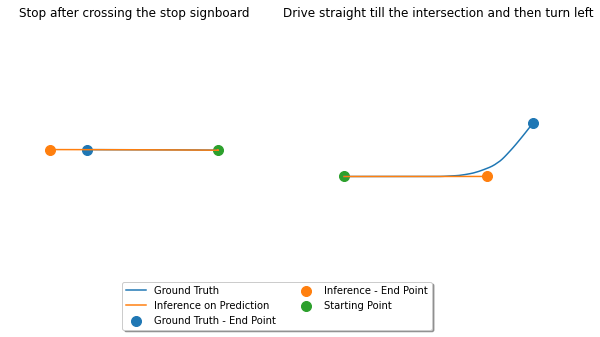

([4.292999998566482, 10.80607305872367],
 [4.292999998566482, 10.80607305872367],
 [1.41057447310484, 8.74487304027145],
 [0.32901731512846294, 0.3058122732603196],
 [0.8564119977013522, 0.6297145243847043],
 [True, False])

In [220]:
val_data_path = '/ssd_scratch/cvit/varunc/carla_data/val/'
val_run_path = '/ssd_scratch/cvit/varunc/new_vals/val_clip_6frames/'
save_loc = '../trajectories_temp'

get_scores(val_data_path, val_run_path, save_loc,episodes = [11,14],subplots=[121,122])

subplotting
Episode 6: change to left lane
(70, 3) (70, 3)
CLIP-MC
Frechet Distance: 26.44121240187925
FDE Distance: 26.44121240187925
ADE Distance: 10.708122562952058
ADE Matched Distance: 7.227682048008699
nDTW Distance: 0.0004706748834911383
TC Distance: False
(70, 3) (70, 3)
RNR-S
Frechet Distance: 61.756485375176524
FDE Distance: 61.756485375176524
ADE Distance: 52.60483600902114
ADE Matched Distance: 40.09098402708359
nDTW Distance: 1.2684268900275567e-40
TC Distance: False
[<matplotlib.lines.Line2D object at 0x7f93ab4c4790>, <matplotlib.collections.PathCollection object at 0x7f93aaafa150>, <matplotlib.collections.PathCollection object at 0x7f93aaafad50>, <matplotlib.lines.Line2D object at 0x7f93abe51e10>, <matplotlib.collections.PathCollection object at 0x7f93ab4c4910>, <matplotlib.lines.Line2D object at 0x7f93abe514d0>, <matplotlib.collections.PathCollection object at 0x7f93abe51850>] ['Ground Truth', 'Ground Truth - End Point', 'Starting Point', 'Inference(CLIP-MC) on Predicti

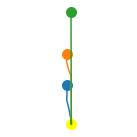

([26.44121240187925, 61.756485375176524],
 [26.44121240187925, 61.756485375176524],
 [10.708122562952058, 52.60483600902114],
 [7.227682048008699, 40.09098402708359],
 [0.0004706748834911383, 1.2684268900275567e-40],
 [False, False])

<Figure size 432x288 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

In [242]:
val_data_path = '/ssd_scratch/cvit/varunc/graphs/gt/'
val_run_path = ['/ssd_scratch/cvit/varunc/graphs/clip/','/ssd_scratch/cvit/varunc/graphs/iros/']
save_loc = '../trajectories_temp'

get_scores_comp(val_data_path, val_run_path, ['CLIP-MC','RNR-S'],save_loc,episodes = [6],subplots=[221,222,223,224])

Episode 22: Turn right from the crossroads.
(66, 3) (66, 3)
CLIP-MC
Frechet Distance: 5.369668918853363
FDE Distance: 5.369668918853363
ADE Distance: 2.749501788949054
ADE Matched Distance: 0.5624979669774022
nDTW Distance: 0.7704392193935654
TC Distance: False
(66, 3) (66, 3)
RNR-S
Frechet Distance: 18.959550090816215
FDE Distance: 18.95955009081621
ADE Distance: 21.63796384720802
ADE Matched Distance: 14.282628979282208
nDTW Distance: 1.8184856205732666e-14
TC Distance: False


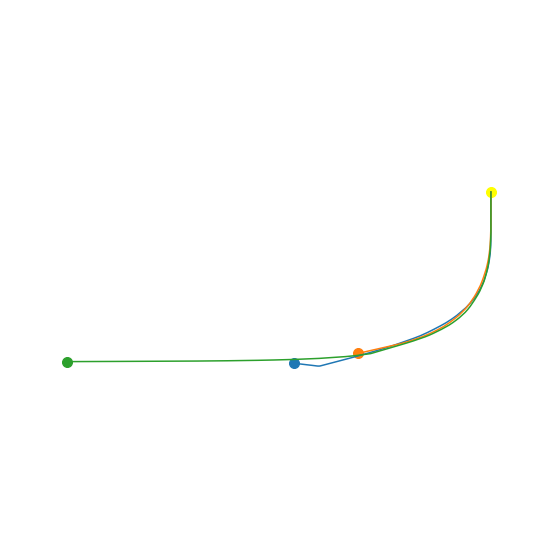

Episode 27: Turn left and stop near the intersection
(358, 3) (358, 3)
CLIP-MC
Frechet Distance: 8.325129479407924
FDE Distance: 8.325129479407924
ADE Distance: 30.88707620566361
ADE Matched Distance: 2.658515517855259
nDTW Distance: 0.5423172425770337
TC Distance: False
(358, 3) (358, 3)
RNR-S
Frechet Distance: 73.35725192977698
FDE Distance: 73.35725192977698
ADE Distance: 38.58528912648359
ADE Matched Distance: 17.58786631032158
nDTW Distance: 0.00022912176693153108
TC Distance: False


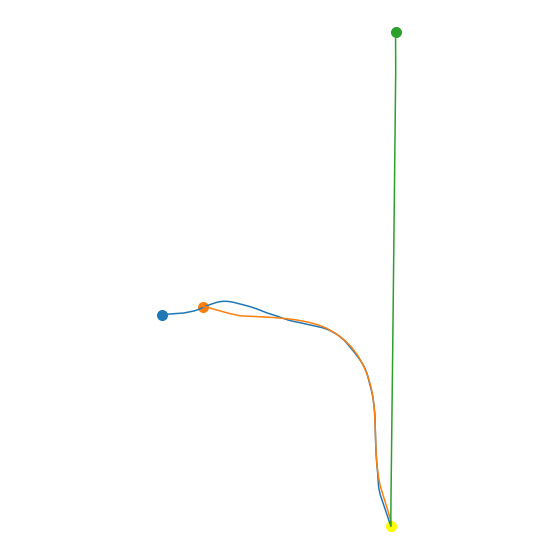

Episode 28: Turn left and come to a halt at the intersection
(501, 3) (501, 3)
CLIP-MC
Frechet Distance: 38.42952985929697
FDE Distance: 38.42952985929696
ADE Distance: 14.135117610423386
ADE Matched Distance: 2.822385533498976
nDTW Distance: 0.5686574161837058
TC Distance: False
(580, 3) (580, 3)
RNR-S
Frechet Distance: 23.797816447195597
FDE Distance: 23.797816447195597
ADE Distance: 15.035628404121178
ADE Matched Distance: 6.32898772206734
nDTW Distance: 0.2820142875057421
TC Distance: False


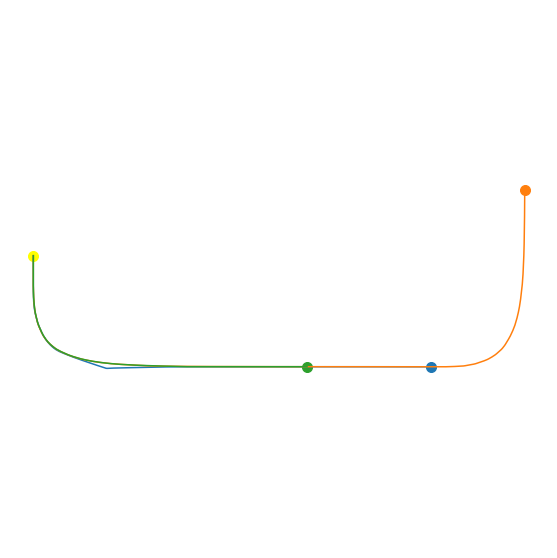

Episode 6: change to left lane
(70, 3) (70, 3)
CLIP-MC
Frechet Distance: 26.44121240187925
FDE Distance: 26.44121240187925
ADE Distance: 12.26191106015331
ADE Matched Distance: 7.227682048008699
nDTW Distance: 0.0004706748834911383
TC Distance: False
(70, 3) (70, 3)
RNR-S
Frechet Distance: 61.756485375176524
FDE Distance: 61.756485375176524
ADE Distance: 49.27043339098114
ADE Matched Distance: 40.09098402708359
nDTW Distance: 1.2684268900275567e-40
TC Distance: False


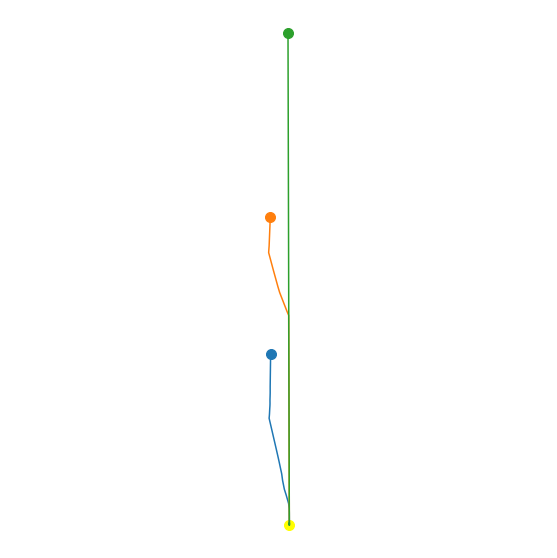

([5.369668918853363,
  18.959550090816215,
  8.325129479407924,
  73.35725192977698,
  38.42952985929697,
  23.797816447195597,
  26.44121240187925,
  61.756485375176524],
 [5.369668918853363,
  18.95955009081621,
  8.325129479407924,
  73.35725192977698,
  38.42952985929696,
  23.797816447195597,
  26.44121240187925,
  61.756485375176524],
 [2.749501788949054,
  21.63796384720802,
  30.88707620566361,
  38.58528912648359,
  14.135117610423386,
  15.035628404121178,
  12.26191106015331,
  49.27043339098114],
 [0.5624979669774022,
  14.282628979282208,
  2.658515517855259,
  17.58786631032158,
  2.822385533498976,
  6.32898772206734,
  7.227682048008699,
  40.09098402708359],
 [0.7704392193935654,
  1.8184856205732666e-14,
  0.5423172425770337,
  0.00022912176693153108,
  0.5686574161837058,
  0.2820142875057421,
  0.0004706748834911383,
  1.2684268900275567e-40],
 [False, False, False, False, False, False, False, False])

In [237]:
val_data_path = '/ssd_scratch/cvit/varunc/graphs/gt/'
val_run_path = ['/ssd_scratch/cvit/varunc/graphs/clip/','/ssd_scratch/cvit/varunc/graphs/iros/']
save_loc = '../trajectories_temp'

get_scores_comp(val_data_path, val_run_path, ['CLIP-MC','RNR-S'],save_loc,episodes = [22,27,28,6])

In [71]:
import math
trunc = lambda x: math.trunc(1000 * x) / 1000;

In [49]:
frechet_df = pd.DataFrame({'Val-Map':pd.Series(frechet_val_clip_6),'Test-Map':pd.Series(frechet_test_clip_6),'Val-NoMap':pd.Series(frechet_val_clip_6nomap),'Test-NoMap':pd.Series(frechet_test_clip_6nomap)})
fde_df = pd.DataFrame({'Val-Map':pd.Series(fde_val_clip_6),'Test-Map':pd.Series(fde_test_clip_6),'Val-NoMap':pd.Series(fde_val_clip_6nomap),'Test-NoMap':pd.Series(fde_test_clip_6nomap)})
ade_df = pd.DataFrame({'Val-Map':pd.Series(ade_val_clip_6),'Test-Map':pd.Series(ade_test_clip_6),'Val-NoMap':pd.Series(ade_val_clip_6nomap),'Test-NoMap':pd.Series(ade_test_clip_6nomap)})
ade_match_df = pd.DataFrame({'Val-Map':pd.Series(ade_matched_val_clip_6),'Test-Map':pd.Series(ade_matched_test_clip_6),'Val-NoMap':pd.Series(ade_matched_val_clip_6nomap),'Test-NoMap':pd.Series(ade_matched_test_clip_6nomap)})
ndtw_df = pd.DataFrame({'Val-Map':pd.Series(ndtw_val_clip_6),'Test-Map':pd.Series(ndtw_test_clip_6),'Val-NoMap':pd.Series(ndtw_val_clip_6nomap),'Test-NoMap':pd.Series(ndtw_test_clip_6nomap)})
tc_df = pd.DataFrame({'Val-Map':pd.Series(tc_val_clip_6),'Test-Map':pd.Series(tc_test_clip_6),'Val-NoMap':pd.Series(tc_val_clip_6nomap),'Test-NoMap':pd.Series(tc_test_clip_6nomap)})


In [63]:
frechet_metric = pd.DataFrame([frechet_df.mean(),frechet_df.std(),frechet_df.median()],index=['Mean','STD','Median'])
frechet_metric['Metric'] = 'Frechet'

fde_metric = pd.DataFrame([fde_df.mean(),fde_df.std(),fde_df.median()],index=['Mean','STD','Median'])
fde_metric['Metric'] = 'FDE'

ade_metric = pd.DataFrame([ade_df.mean(),ade_df.std(),ade_df.median()],index=['Mean','STD','Median'])
ade_metric['Metric'] = 'ADE'

ade_match_metric = pd.DataFrame([ade_match_df.mean(),ade_match_df.std(),ade_match_df.median()],index=['Mean','STD','Median'])
ade_match_metric['Metric'] = 'ADE Match'

ndtw_metric = pd.DataFrame([ndtw_df.mean(),ndtw_df.std(),ndtw_df.median()],index=['Mean','STD','Median'])
ndtw_metric['Metric'] = 'nDTW'

tc_metric = pd.DataFrame([tc_df.mean(),tc_df.std(),tc_df.median()],index=['Mean','STD','Median'])
tc_metric['Metric'] = 'Task Completion'

joined = pd.concat([frechet_metric,fde_metric,ade_metric,ade_match_metric,ndtw_metric,tc_metric])

joined['Measure'] = joined.index

joined = joined.set_index(['Metric','Measure'])

In [64]:
joined.T

Metric        Frechet                              FDE                        \
Measure          Mean        STD     Median       Mean        STD     Median   
Val-Map     13.537746  13.130894   8.523169  13.536816  13.131824   8.523169   
Test-Map    23.569764  49.973291   9.260606  22.144784  49.824289   8.764641   
Val-NoMap   54.144742  77.431001  13.971223  51.431637  69.332212  13.971223   
Test-NoMap  50.898006  60.703003  29.531908  27.876552  25.619447  23.171399   

Metric            ADE                        ADE Match                       \
Measure          Mean        STD     Median       Mean        STD    Median   
Val-Map      6.315672   4.663375   5.018031   1.812250   2.016621  0.662795   
Test-Map    17.416428  47.310492   5.079331  11.469604  46.840572  1.041967   
Val-NoMap   26.304151  44.601289   7.909633  19.372088  38.478973  2.945470   
Test-NoMap  25.414810  26.429363  14.214218  18.406841  25.002322  6.524667   

Metric          nDTW                     Task Completion                   
Measure         Mean       STD    Median            Mean       STD Median  
Val-Map     0.544586  0.312208  0.594053        0.280000  0.458258    0.0  
Test-Map    0.562131  0.346011  0.654810        0.323529  0.474858    0.0  
Val-NoMap   0.366596  0.326749  0.409812        0.200000  0.408248    0.0  
Test-NoMap  0.318528  0.335840  0.138249        0.088235  0.287902    0.0

In [52]:
# joined.applymap(trunc).to_csv('joined.csv')

Text(0.5, 1.0, 'Freschet Distance')

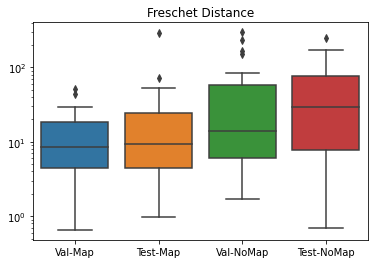

In [53]:
g = sns.boxplot(data=frechet_df)
g.set_yscale("log")
# g.set_ylim([-5,60])
plt.title('Freschet Distance')

Text(0.5, 1.0, 'FDE Distance')

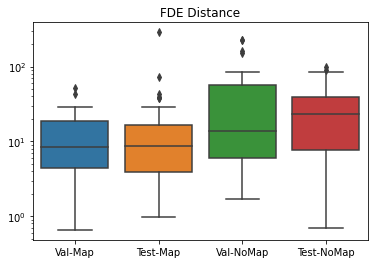

In [54]:
g = sns.boxplot(data=fde_df)
g.set_yscale("log")
plt.title('FDE Distance')

Text(0.5, 1.0, 'ADE Distance')

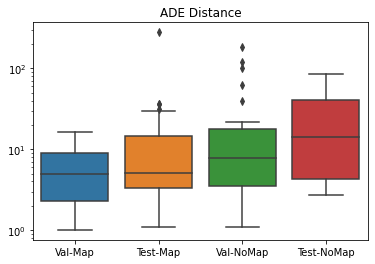

In [55]:
g = sns.boxplot(data=ade_df)
g.set_yscale("log")
plt.title('ADE Distance')

Text(0.5, 1.0, 'ADE Match Distance')

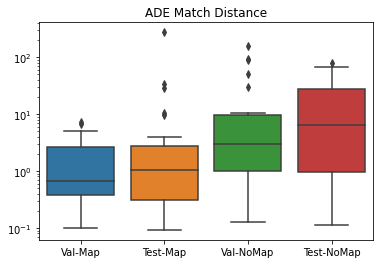

In [56]:
g = sns.boxplot(data=ade_match_df)
g.set_yscale("log")
plt.title('ADE Match Distance')

Text(0.5, 1.0, 'nDTW Distance')

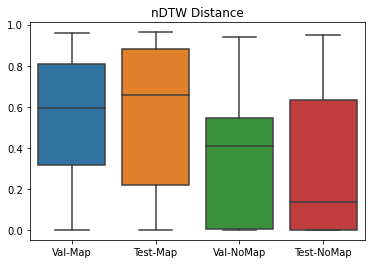

In [61]:
g = sns.boxplot(data=ndtw_df)
# g.set_yscale("log")
plt.title('nDTW Distance')

Text(0.5, 1.0, 'TC Distance')

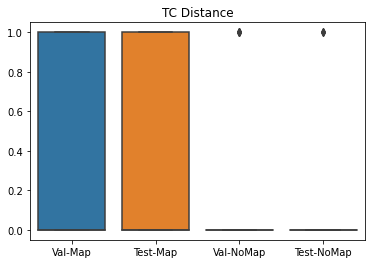

In [62]:
g = sns.boxplot(data=tc_df)
# g.set_yscale("log")
plt.title('TC Distance')

In [31]:
def get_ablations(commands):
    out = dict()
    for i,command in enumerate(commands):
        print(command)
        c_types = input('Type:')
        c_types = [ c.strip() for c in c_types.split(',')]
        for c_type in c_types:
            if c_type in out:
                out[c_type].append(i)
            else:
                out[c_type] = [i]
    return out

In [45]:
import re

In [82]:
def get_ablations_from_wordlist(commands,wordlist):
    out = dict()
    for word in wordlist:
        out[word.lower()] = []
    for i,command in enumerate(commands):
        print(command)
        command = re.sub(r'[^a-zA-Z]', ' ', command)
        command = command.lower().strip().split()
        for c in command:
            if c not in out.keys():
                continue
            out[c].append(i)
            print(c,end=' ')
        print('')
    for word in wordlist:
        out[word.lower()] = list(set(out[word.lower()]))
    return out

In [103]:
commands = get_commands('/ssd_scratch/cvit/varunc/carla_data/test/')

In [106]:
stop_turn = get_ablations_from_wordlist(commands,['stop','left','park','right','straight'])

Stop in front of the garbage dumpsters.
stop 
Turn left and stop near the traffic signal
left stop 
take a right turn and stop across the bench on left
right stop left 
stop by the lamp post
stop 
Turn left and stop near the traffic signal
left stop 
Go straight and stop next to the grey arch.
straight stop 
Turn right and park near the sidewalk.
right park 
Turn right and stop just before the traffic signal
right stop 
park immediately after the signboard
park 
Stop near the signboard
stop 
Wait for the signal to turn green and continue straight
straight 
Drive towards the bus stop and park after crossing it
stop park 
Turn left and stop beside the traffic signal
left stop 
Turn right from the intersection
right 
Turn right and stop before the traffic signal
right stop 
Take a left from the intersection ahead
left 
Turn right from the crossroads.
right 
After crossing the blue car come to a stop
stop 
Take a left at the traffic light
left 
Park on the roadside after you have crossed t

In [105]:
stop_turn

{'stop': [0,
  1,
  2,
  3,
  4,
  5,
  7,
  9,
  11,
  12,
  14,
  17,
  19,
  22,
  23,
  24,
  25,
  26,
  27,
  30],
 'left': [1, 2, 33, 4, 12, 15, 18, 25, 29, 31],
 'park': [32, 6, 8, 11, 19],
 'right': [2, 6, 7, 13, 14, 16, 20, 21, 23, 24, 28, 30],
 'straight': [27, 10, 21, 5]}

In [51]:
stop_turn = get_ablations(commands)

Shift to the left lane and stop at the intersection.


KeyboardInterrupt: Interrupted by user

In [18]:
stop_turn = {'stop': [0, 2, 4, 6, 9, 11, 12, 13, 15, 17, 18, 22, 24, 25, 29, 30, 31, 32, 33, 35, 36, 38, 39, 40, 41, 43, 44, 46, 47], 'left': [1, 3, 8, 10, 14, 15, 19, 26, 34, 42], 'right': [5, 7, 19, 21, 24, 27, 28, 32, 36, 37, 44, 45, 48, 49], 'straight': [16, 20, 23]}

In [55]:
results_val_df[stop_turn['stop']].mean(axis=1)

Meteric    Model  
frechet    CLIP-VC    12.994535
           CLIP-V     50.230631
           CLIP       31.570558
           CLIP-C     68.860764
           RNR-C      23.380336
           RNR        27.579007
fde        CLIP-VC    12.994535
           CLIP-V     45.739667
           CLIP       25.467835
           CLIP-C     62.023489
           RNR-C      23.380336
           RNR        27.541250
ade        CLIP-VC     6.072857
           CLIP-V     24.545058
           CLIP       18.816038
           CLIP-C     33.562296
           RNR-C      12.083113
           RNR        16.128997
ade_match  CLIP-VC     1.536927
           CLIP-V     17.931067
           CLIP       12.743140
           CLIP-C     27.362996
           RNR-C       5.893372
           RNR         9.890720
tc         CLIP-VC     0.769231
           CLIP-V      0.615385
           CLIP        0.615385
           CLIP-C      0.692308
           RNR-C       0.615385
           RNR         0.461538
nDTW       CLIP-VC   

In [108]:
command_specific = pd.DataFrame({
    f'{key}_mean':results_test_df[stop_turn[key]].mean(axis=1) for key in stop_turn.keys()}).T
command_specific

Meteric          frechet                                              \
Model            CLIP-VC     CLIP-V       CLIP     CLIP-C      RNR-C   
stop_mean      13.657662  62.557142  43.562818  32.777137  43.294869   
left_mean      17.433215  43.537352  27.242446  41.420843  38.422416   
park_mean      13.329254  15.709297  27.527645  26.923644  42.268309   
right_mean     18.398135  61.462298  62.665780  54.154242  52.025879   
straight_mean   7.213880  68.459381  93.834705  60.048579  38.574816   

Meteric                         fde                                   ...  \
Model                RNR    CLIP-VC     CLIP-V       CLIP     CLIP-C  ...   
stop_mean      43.519980  13.645838  54.726084  38.101392  23.476152  ...   
left_mean      34.524481  12.588283  41.701571  27.242446  35.492747  ...   
park_mean      80.496014  13.329254  15.709297  27.527645  14.385608  ...   
right_mean     31.320531  18.398135  48.870480  37.238124  27.514899  ...   
straight_mean  37.773847   7.213880  65.544875  44.739310  10.841997  ...   

Meteric         tc                                nDTW                      \
Model         CLIP    CLIP-C RNR-C       RNR   CLIP-VC    CLIP-V      CLIP   
stop_mean      0.5  0.450000  0.35  0.350000  0.615232  0.243601  0.215994   
left_mean      0.6  0.400000  0.20  0.300000  0.525587  0.259600  0.171930   
park_mean      0.4  0.600000  0.40  0.400000  0.603609  0.495750  0.384040   
right_mean     0.5  0.583333  0.50  0.333333  0.548770  0.226757  0.267557   
straight_mean  0.5  1.000000  0.50  0.500000  0.700431  0.115129  0.032691   

Meteric                                      
Model            CLIP-C     RNR-C       RNR  
stop_mean      0.391268  0.393159  0.169660  
left_mean      0.352972  0.295367  0.247524  
park_mean      0.501262  0.356773  0.038222  
right_mean     0.378558  0.451627  0.220440  
straight_mean  0.513606  0.306577  0.255812  

[5 rows x 36 columns]

In [109]:
command_specific.applymap(trunc).to_csv('command_specific.csv')

In [110]:
from copy import deepcopy

In [111]:
stopping_turning = dict()
stopping_turning['Stopping Based'] = list(set([*stop_turn['stop'],*stop_turn['park']]))
stopping_turning['Turning Based'] = list(set([*stop_turn['right'],*stop_turn['left']]))

In [112]:
type_joined = pd.DataFrame({
    f'{key}':results_test_df[stopping_turning[key]].mean(axis=1) for key in stopping_turning.keys()}).T
type_joined

Meteric           frechet                                              \
Model             CLIP-VC     CLIP-V       CLIP     CLIP-C      RNR-C   
Stopping Based  12.733693  56.866385  40.507940  30.227329  44.879173   
Turning Based   18.768086  55.094376  48.588746  50.655039  47.924547   

Meteric                          fde                                   ...  \
Model                 RNR    CLIP-VC     CLIP-V       CLIP     CLIP-C  ...   
Stopping Based  45.663746  12.723412  50.056769  35.758874  22.139516  ...   
Turning Based   34.225648  16.460976  47.024870  34.058657  32.620392  ...   

Meteric               tc                                    nDTW            \
Model               CLIP    CLIP-C     RNR-C       RNR   CLIP-VC    CLIP-V   
Stopping Based  0.478261  0.478261  0.347826  0.347826  0.633166  0.260248   
Turning Based   0.523810  0.476190  0.333333  0.285714  0.518078  0.237615   

Meteric                                                
Model               CLIP    CLIP-C    RNR-C       RNR  
Stopping Based  0.242929  0.417515  0.38480  0.148444  
Turning Based   0.233159  0.339831  0.35458  0.200453  

[2 rows x 36 columns]

In [113]:
type_joined.applymap(trunc).to_csv('type_joined.csv')

In [19]:
stop_frechet_df = frechet_df.iloc[stop_turn['stop']].reset_index().drop('index',axis=1)
stop_fde_df = fde_df.iloc[stop_turn['stop']].reset_index().drop('index',axis=1)
stop_ade_df = ade_df.iloc[stop_turn['stop']].reset_index().drop('index',axis=1)
stop_ade_match_df = ade_match_df.iloc[stop_turn['stop']].reset_index().drop('index',axis=1)


stop_frechet_metric = pd.DataFrame([stop_frechet_df.mean(),stop_frechet_df.std(),stop_frechet_df.median()],index=['Mean','STD','Median'])
stop_frechet_metric['Metric'] = 'Frechet'

stop_fde_metric = pd.DataFrame([stop_fde_df.mean(),stop_fde_df.std(),stop_fde_df.median()],index=['Mean','STD','Median'])
stop_fde_metric['Metric'] = 'FDE'

stop_ade_metric = pd.DataFrame([stop_ade_df.mean(),stop_ade_df.std(),stop_ade_df.median()],index=['Mean','STD','Median'])
stop_ade_metric['Metric'] = 'ADE'

stop_ade_match_metric = pd.DataFrame([stop_ade_match_df.mean(),stop_ade_match_df.std(),stop_ade_match_df.median()],index=['Mean','STD','Median'])
stop_ade_match_metric['Metric'] = 'ADE Match'

stop_joined = pd.concat([stop_frechet_metric,stop_fde_metric,stop_ade_metric,stop_ade_match_metric])

stop_joined['Measure'] = stop_joined.index
stop_joined['Command Type'] = 'Stopping Based'
stop_joined = stop_joined.set_index(['Metric','Measure'])
stop_joined

Conv3D        VIT    Command Type
Metric    Measure                                      
Frechet   Mean     17.326682  53.981311  Stopping Based
          STD      21.375390  72.795143  Stopping Based
          Median    9.665442  12.282180  Stopping Based
FDE       Mean     17.316695  47.667016  Stopping Based
          STD      21.383593  60.744939  Stopping Based
          Median    9.665442  12.282180  Stopping Based
ADE       Mean     10.724657  26.614002  Stopping Based
          STD      12.428624  39.105454  Stopping Based
          Median    7.157681   7.676123  Stopping Based
ADE Match Mean      4.444001  20.895273  Stopping Based
          STD       9.003296  37.588336  Stopping Based
          Median    1.366873   3.702058  Stopping Based

In [20]:
turn_frechet_df = frechet_df.iloc[[*stop_turn['left'],*stop_turn['right']]].reset_index().drop('index',axis=1)
turn_fde_df = fde_df.iloc[[*stop_turn['left'],*stop_turn['right']]].reset_index().drop('index',axis=1)
turn_ade_df = ade_df.iloc[[*stop_turn['left'],*stop_turn['right']]].reset_index().drop('index',axis=1)
turn_ade_match_df = ade_match_df.iloc[[*stop_turn['left'],*stop_turn['right']]].reset_index().drop('index',axis=1)


turn_frechet_metric = pd.DataFrame([turn_frechet_df.mean(),turn_frechet_df.std(),turn_frechet_df.median()],index=['Mean','STD','Median'])
turn_frechet_metric['Metric'] = 'Frechet'

turn_fde_metric = pd.DataFrame([turn_fde_df.mean(),turn_fde_df.std(),turn_fde_df.median()],index=['Mean','STD','Median'])
turn_fde_metric['Metric'] = 'FDE'

turn_ade_metric = pd.DataFrame([turn_ade_df.mean(),turn_ade_df.std(),turn_ade_df.median()],index=['Mean','STD','Median'])
turn_ade_metric['Metric'] = 'ADE'

turn_ade_match_metric = pd.DataFrame([turn_ade_match_df.mean(),turn_ade_match_df.std(),turn_ade_match_df.median()],index=['Mean','STD','Median'])
turn_ade_match_metric['Metric'] = 'ADE Match'

turn_joined = pd.concat([turn_frechet_metric,turn_fde_metric,turn_ade_metric,turn_ade_match_metric])

turn_joined['Measure'] = turn_joined.index

turn_joined['Command Type'] = 'Turning Based'

turn_joined = turn_joined.set_index(['Metric','Measure'])
turn_joined

Conv3D        VIT   Command Type
Metric    Measure                                     
Frechet   Mean     17.970466  36.416590  Turning Based
          STD      21.371984  40.996674  Turning Based
          Median    6.965737  16.678068  Turning Based
FDE       Mean     17.970466  35.569278  Turning Based
          STD      21.371984  39.775306  Turning Based
          Median    6.965737  16.678068  Turning Based
ADE       Mean     10.017345  17.524459  Turning Based
          STD       9.300756  21.721663  Turning Based
          Median    5.041168  10.150757  Turning Based
ADE Match Mean      5.033972  11.398932  Turning Based
          STD       7.565082  18.248139  Turning Based
          Median    1.321265   3.451181  Turning Based

In [21]:
type_joined = pd.concat([stop_joined.reset_index(),turn_joined.reset_index()])
type_joined = type_joined.pivot_table(index=['Command Type','Metric'],columns='Measure',sort=False)
type_joined

Conv3D                             VIT  \
Measure                        Mean    Median        STD       Mean   
Command Type   Metric                                                 
Stopping Based Frechet    17.326682  9.665442  21.375390  53.981311   
               FDE        17.316695  9.665442  21.383593  47.667016   
               ADE        10.724657  7.157681  12.428624  26.614002   
               ADE Match   4.444001  1.366873   9.003296  20.895273   
Turning Based  Frechet    17.970466  6.965737  21.371984  36.416590   
               FDE        17.970466  6.965737  21.371984  35.569278   
               ADE        10.017345  5.041168   9.300756  17.524459   
               ADE Match   5.033972  1.321265   7.565082  11.398932   

                                                
Measure                      Median        STD  
Command Type   Metric                           
Stopping Based Frechet    12.282180  72.795143  
               FDE        12.282180  60.744939  
               ADE         7.676123  39.105454  
               ADE Match   3.702058  37.588336  
Turning Based  Frechet    16.678068  40.996674  
               FDE        16.678068  39.775306  
               ADE        10.150757  21.721663  
               ADE Match   3.451181  18.248139

In [75]:
type_joined.applymap(trunc).to_csv('type_joined.csv')

In [114]:
len_commands = [len(s.split()) for s in commands]

In [115]:
len_commands
length_commands = dict()
for i,len_c in enumerate(len_commands):
    if len_c in length_commands:
        length_commands[len_c].append(i)
    else:
        length_commands[len_c] = [i]


In [116]:
length_commands

{7: [0, 6, 15, 18, 22, 25, 28, 31],
 8: [1, 4, 12, 14, 23, 24],
 11: [2, 19],
 5: [3, 8, 13, 16, 26, 32],
 9: [5, 7, 17],
 4: [9],
 10: [10, 11, 29],
 6: [20, 21, 30, 33],
 12: [27]}

In [117]:
length_based = pd.DataFrame({
    f'{key}':results_test_df[length_commands[key]].mean(axis=1) for key in length_commands.keys()}).T
length_based

Meteric    frechet                                                          \
Model      CLIP-VC      CLIP-V       CLIP     CLIP-C      RNR-C        RNR   
7        18.424109   24.635636  25.912596  22.345173  30.240475  27.176964   
8        11.110296   75.541047  68.935288  36.776408  77.585543  46.252518   
11        4.265137   18.521726   6.760580   6.377683  12.649948  15.051809   
5         7.406736   80.446469  22.363697  17.524540  49.818127  55.591369   
9        16.604884   21.212620  48.614667  43.364805  29.221933   1.926508   
4         3.098183   17.603349   6.267968  13.296441  13.231217  39.344859   
10       15.531327   27.817980  49.886434  84.800055  36.314921  93.159434   
6        34.358768  110.410025  77.744355  95.819494  51.593057  46.734869   
12        8.325129   29.161388  64.659091  10.244110  70.348061  73.357252   

Meteric        fde                                   ...        tc            \
Model      CLIP-VC     CLIP-V       CLIP     CLIP-C  ...      CLIP    CLIP-C   
7        12.338385  24.635636  25.912593  22.345160  ...  0.500000  0.500000   
8        11.110296  72.704841  68.698162  36.776408  ...  0.333333  0.333333   
11        4.265137  18.521726   6.760580   6.264939  ...  1.000000  1.000000   
5         7.406736  80.446469  22.363697  17.524540  ...  0.166667  0.666667   
9        16.604884  21.212620  12.679414   2.330164  ...  1.000000  0.666667   
4         3.098183  17.603349   6.267968  13.296441  ...  1.000000  0.000000   
10       15.531327  27.317745  49.886434  44.218170  ...  0.333333  0.333333   
6        34.358768  72.634573  28.648960  46.612911  ...  0.500000  0.250000   
12        8.325129  29.161388  64.659091  10.244110  ...  0.000000  1.000000   

Meteric                          nDTW                                          \
Model       RNR-C       RNR   CLIP-VC    CLIP-V      CLIP    CLIP-C     RNR-C   
7        0.125000  0.375000  0.593679  0.405090  0.251325  0.416514  0.277993   
8        0.333333  0.166667  0.631778  0.137795  0.047809  0.354296  0.341711   
11       1.000000  1.000000  0.825779  0.370731  0.343172  0.832392  0.626014   
5        0.500000  0.000000  0.748211  0.199594  0.291477  0.417071  0.371799   
9        0.333333  1.000000  0.312833  0.142963  0.334150  0.603250  0.589611   
4        0.000000  0.000000  0.962851  0.670164  0.851563  0.852882  0.860675   
10       0.000000  0.000000  0.588233  0.617082  0.249286  0.242128  0.167863   
6        0.500000  0.250000  0.294869  0.002031  0.230984  0.002926  0.112687   
12       0.000000  0.000000  0.542317  0.031627  0.000451  0.439675  0.000763   

Meteric                
Model             RNR  
7        1.292765e-01  
8        7.209277e-02  
11       5.405458e-01  
5        8.662181e-03  
9        5.397799e-01  
4        1.627499e-07  
10       1.856581e-01  
6        1.871141e-01  
12       2.291218e-04  

[9 rows x 36 columns]

In [118]:
length_based.applymap(trunc).to_csv('length_based.csv')

In [25]:
command_vals = dict()
for i,len_c in enumerate(len_commands):
    if len_c in command_vals:
        command_vals[len_c].append({'Conv3D':{
                                        'frechet':frechet_conv3d[i],
                                        'ade_match':ade_matched_conv3d[i],
                                        'ade':ade_conv3d[i],
                                        'fde':fde_conv3d[i]},
                                    'VIT':{
                                        'frechet':frechet_vit[i],
                                        'ade_match':ade_matched_vit[i],
                                        'ade':ade_vit[i],
                                        'fde':fde_vit[i]}
                                   })
    else:
        command_vals[len_c] = [{'Conv3D':{
                                        'frechet':frechet_conv3d[i],
                                        'ade_match':ade_conv3d[i],
                                        'ade':ade_conv3d[i],
                                        'fde':fde_conv3d[i]},
                                    'VIT':{
                                        'frechet':frechet_vit[i],
                                        'ade_match':ade_matched_vit[i],
                                        'ade':ade_vit[i],
                                        'fde':fde_vit[i]}
                                   }]


In [26]:
command_vals

{6: [{'Conv3D': {'frechet': 26.111845491426653,
    'ade_match': 41.2555774241194,
    'ade': 41.2555774241194,
    'fde': 26.111845491426653},
   'VIT': {'frechet': 90.59249842920809,
    'ade_match': 38.12549675972528,
    'ade': 44.33715923340456,
    'fde': 90.59249842920809}},
  {'Conv3D': {'frechet': 6.409774368995845,
    'ade_match': 1.5706127697530465,
    'ade': 4.132724146503285,
    'fde': 6.409774368995845},
   'VIT': {'frechet': 6.593041440555822,
    'ade_match': 0.4778890316451603,
    'ade': 3.5402183203237167,
    'fde': 6.593041440555822}},
  {'Conv3D': {'frechet': 7.521698756749053,
    'ade_match': 0.9440076470747767,
    'ade': 4.6012384977254674,
    'fde': 7.521698756749053},
   'VIT': {'frechet': 8.425640053997611,
    'ade_match': 1.1563228977490998,
    'ade': 3.154552474136442,
    'fde': 8.425640053997611}},
  {'Conv3D': {'frechet': 1.1752202891395593,
    'ade_match': 0.2761978171832063,
    'ade': 1.908408684043676,
    'fde': 1.1752004228828945},
   'VIT

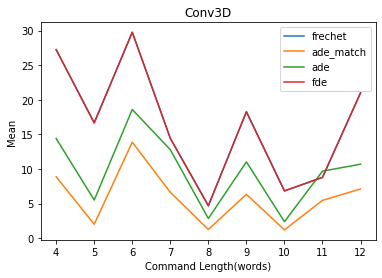

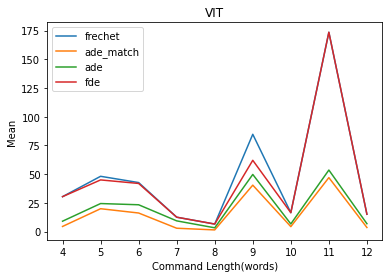

In [27]:
l_cv = sorted([(k,v) for k,v in command_vals.items()],key = lambda it: it[0])
for model in ['Conv3D','VIT']:
    plt.figure()
    for metric in ['frechet','ade_match','ade','fde']:
        x = [k for k,v in l_cv]
        y = [np.mean([t[model][metric] for t in v]) for k,v in l_cv]
        plt.plot(x,y,label = metric)
    plt.title(model)
    plt.legend()
    plt.ylabel('Mean')
    plt.xlabel('Command Length(words)')
    plt.show()

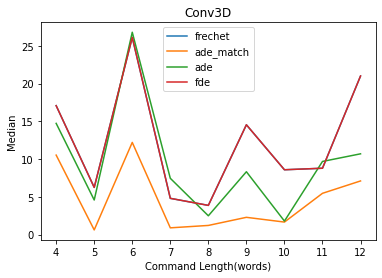

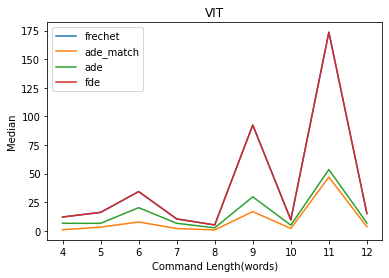

In [28]:
l_cv = sorted([(k,v) for k,v in command_vals.items()],key = lambda it: it[0])
for model in ['Conv3D','VIT']:
    plt.figure()
    for metric in ['frechet','ade_match','ade','fde']:
        x = [k for k,v in l_cv]
        y = [np.median([t[model][metric] for t in v]) for k,v in l_cv]
        plt.plot(x,y,label = metric)
    plt.title(model)
    plt.legend()
    plt.ylabel('Median')
    plt.xlabel('Command Length(words)')
    plt.show()

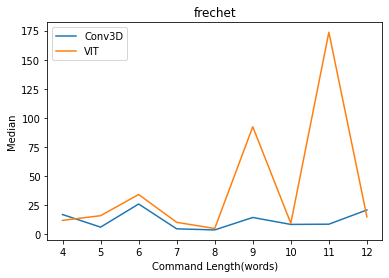

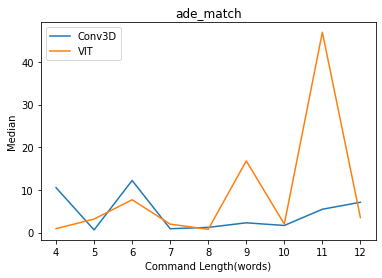

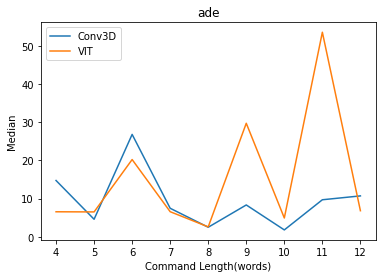

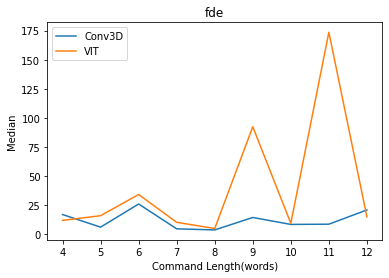

In [29]:
l_cv = sorted([(k,v) for k,v in command_vals.items()],key = lambda it: it[0])
for metric in ['frechet','ade_match','ade','fde']:
    plt.figure()
    for model in ['Conv3D','VIT']:
        x = [k for k,v in l_cv]
        y = [np.median([t[model][metric] for t in v]) for k,v in l_cv]
        plt.plot(x,y,label = model)
    plt.title(metric)
    plt.legend()
    plt.ylabel('Median')
    plt.xlabel('Command Length(words)')
    plt.show()

In [119]:
def get_subcommand_count_from_wordlist(commands,wordlist):
    out = dict()
    for i,word in enumerate(wordlist):
        wordlist[i] = word.lower()
        
    for i,command in enumerate(commands):
        print(command)
        command = re.sub(r'[^a-zA-Z]', ' ', command)
        command = command.lower().strip().split()
        count = 0
        for c in command:
            if c not in wordlist:
                continue
            count+=1
        print(count)
        if count in out.keys():
            out[count].append(i)
        else:
            out[count]=[i]
    return out

In [120]:
sub_command_count = get_subcommand_count_from_wordlist(commands,['stop','left','right','park','wait','straight'])

Stop in front of the garbage dumpsters.
1
Turn left and stop near the traffic signal
2
take a right turn and stop across the bench on left
3
stop by the lamp post
1
Turn left and stop near the traffic signal
2
Go straight and stop next to the grey arch.
2
Turn right and park near the sidewalk.
2
Turn right and stop just before the traffic signal
2
park immediately after the signboard
1
Stop near the signboard
1
Wait for the signal to turn green and continue straight
2
Drive towards the bus stop and park after crossing it
2
Turn left and stop beside the traffic signal
2
Turn right from the intersection
1
Turn right and stop before the traffic signal
2
Take a left from the intersection ahead
1
Turn right from the crossroads.
1
After crossing the blue car come to a stop
1
Take a left at the traffic light
1
Park on the roadside after you have crossed the bus stop
2
Turn right from the crossroads ahead
1
go straight and take a right
2
Change lanes and stop at the junction.
1
Turn right and 

In [30]:
sub_command_count = get_ablations(commands)

Stop after crossing the stop signboard
Type:1
go straight and take a left
Type:2
After crossing the blue car come to a stop
Type:1
Turn left from the intersection
Type:1
Change lanes and stop at the junction.
Type:2
Drive straight then turn right.
Type:1
Stop near the signboard
Type:1
Turn right from the crossroads.
Type:1
Drive to the intersection and turn left
Type:2
Go straight and stop a few metres ahead of the bus stop
Type:1
Take a left from the intersection ahead.
Type:1
Park near the hut visible on the right
Type:1
Park on the roadside after you have crossed the bus stop
Type:1
park immediately after the signboard
Type:1
Take a left from the interection.
Type:1
Turn left and stop next to the bus stop.
Type:2
Wait at the traffic light then go straight.
Type:2
Stop as soon as you encounter a white car
Type:1
stop beside the black suv
Type:1
take a right at the traffic lights and then take a left
Type:2
Wait for the signal to turn green and continue straight
Type:2
Take the next r

In [121]:
subcommands_based = pd.DataFrame({
    f'{key}':results_test_df[sub_command_count[key]].mean(axis=1) for key in sub_command_count.keys()}).T
subcommands_based

Meteric    frechet                                                         \
Model      CLIP-VC     CLIP-V       CLIP     CLIP-C      RNR-C        RNR   
1        15.248528  45.259646  24.143101  30.066307  43.752766  39.735091   
2        16.754152  70.329496  67.528456  55.968934  49.973891  44.349871   
3         6.169750  17.174447  30.064170   4.647751  24.925430  49.029109   

Meteric        fde                                   ...        tc            \
Model      CLIP-VC     CLIP-V       CLIP     CLIP-C  ...      CLIP    CLIP-C   
1        12.384658  45.180789  24.114967  26.564001  ...  0.411765  0.411765   
2        16.754152  58.309555  45.733325  28.673447  ...  0.571429  0.500000   
3         6.169750  17.174447  30.064170   4.572588  ...  0.333333  1.000000   

Meteric                          nDTW                                          \
Model       RNR-C       RNR   CLIP-VC    CLIP-V      CLIP    CLIP-C     RNR-C   
1        0.235294  0.176471  0.599443  0.305408  0.308862  0.393062  0.256690   
2        0.357143  0.428571  0.557333  0.187190  0.205214  0.324729  0.363723   
3        0.666667  0.333333  0.691857  0.394659  0.045089  0.745743  0.628597   

Meteric            
Model         RNR  
1        0.131329  
2        0.170072  
3        0.303743  

[3 rows x 36 columns]

In [122]:
subcommands_based.applymap(trunc).to_csv('subcommands_based.csv')

In [33]:
sub_command_count = {'1': [0, 2, 3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 17, 18, 21, 22, 23, 25, 27, 29, 31, 33, 34, 35, 37, 38, 39, 42, 43, 45, 46, 47, 48, 49], '2': [1, 4, 8, 15, 16, 19, 20, 24, 26, 28, 30, 32, 36, 40, 41, 44]}

In [123]:
target_type = get_ablations(commands)

Stop in front of the garbage dumpsters.
Type:infra
Turn left and stop near the traffic signal
Type:road
take a right turn and stop across the bench on left
Type:infra
stop by the lamp post
Type:infra
Turn left and stop near the traffic signal
Type:road
Go straight and stop next to the grey arch.
Type:infra
Turn right and park near the sidewalk.
Type:road
Turn right and stop just before the traffic signal
Type:road
park immediately after the signboard
Type:road
Stop near the signboard
Type:road
Wait for the signal to turn green and continue straight
Type:road
Drive towards the bus stop and park after crossing it
Type:infra
Turn left and stop beside the traffic signal
Type:road
Turn right from the intersection
Type:road
Turn right and stop before the traffic signal
Type:road
Take a left from the intersection ahead
Type:road
Turn right from the crossroads.
Type:road
After crossing the blue car come to a stop
Type:auto
Take a left at the traffic light
Type:road
Park on the roadside after y

In [124]:
target_based = pd.DataFrame({
    f'{key}':results_test_df[target_type[key]].mean(axis=1) for key in target_type.keys()}).T
target_based

Meteric    frechet                                                          \
Model      CLIP-VC      CLIP-V       CLIP     CLIP-C      RNR-C        RNR   
infra     9.262961   10.977143  33.844036  18.384789  18.493099  53.105394   
road     17.578500   55.326045  49.163786  47.691763  49.679602  36.292154   
auto     11.294390  148.411369  14.834747  21.548891  75.877382  61.306457   

Meteric        fde                                    ...        tc            \
Model      CLIP-VC      CLIP-V       CLIP     CLIP-C  ...      CLIP    CLIP-C   
infra     9.233401   10.977143  33.844036  10.520316  ...  0.375000  0.750000   
road     15.472008   47.951273  35.897184  31.235150  ...  0.521739  0.478261   
auto     11.294390  148.411369  14.675328  21.387684  ...  0.333333  0.000000   

Meteric                          nDTW                                          \
Model       RNR-C       RNR   CLIP-VC    CLIP-V      CLIP    CLIP-C     RNR-C   
infra    0.625000  0.375000  0.679238  0.478773  0.114789  0.495973  0.532757   
road     0.217391  0.260870  0.553276  0.209228  0.247820  0.358311  0.286700   
auto     0.333333  0.333333  0.636508  0.118048  0.546919  0.418857  0.161828   

Meteric            
Model         RNR  
infra    0.170350  
road     0.143414  
auto     0.287838  

[3 rows x 36 columns]

In [125]:
target_based.applymap(trunc).to_csv('target_based.csv')

In [76]:
target_type = {'infrastructure': [0, 6, 9, 11, 12, 13, 15, 25, 31, 32, 33, 35, 36, 39, 40, 41, 43, 44, 46], 'road/traffic light': [1, 3, 4, 5, 7, 8, 10, 14, 15, 16, 19, 20, 21, 23, 24, 26, 27, 28, 30, 32, 34, 36, 37, 38, 40, 42, 44, 45, 47, 48, 49], 'automobile': [2, 17, 18, 22, 29]}

In [77]:
subcommands_frechet_df = dict()
subcommands_fde_df = dict()
subcommands_ade_df = dict()
subcommands_ade_match_df = dict()
subcommands_frechet_metric = dict()
subcommands_fde_metric = dict()
subcommands_ade_metric = dict()
subcommands_ade_match_metric = dict()
subcommands_joined = dict()


for k in sub_command_count.keys():
    subcommands_frechet_df[k] = frechet_df.iloc[sub_command_count[k]].reset_index().drop('index',axis=1)
    subcommands_fde_df[k] = fde_df.iloc[sub_command_count[k]].reset_index().drop('index',axis=1)
    subcommands_ade_df[k] = ade_df.iloc[sub_command_count[k]].reset_index().drop('index',axis=1)
    subcommands_ade_match_df[k] = ade_match_df.iloc[sub_command_count[k]].reset_index().drop('index',axis=1)


    subcommands_frechet_metric[k] = pd.DataFrame([subcommands_frechet_df[k].mean(),subcommands_frechet_df[k].std(),subcommands_frechet_df[k].median()],index=['Mean','STD','Median'])
    subcommands_frechet_metric[k]['Metric'] = 'Frechet'

    subcommands_fde_metric[k] = pd.DataFrame([subcommands_fde_df[k].mean(),subcommands_fde_df[k].std(),subcommands_fde_df[k].median()],index=['Mean','STD','Median'])
    subcommands_fde_metric[k]['Metric'] = 'FDE'

    subcommands_ade_metric[k] = pd.DataFrame([subcommands_ade_df[k].mean(),subcommands_ade_df[k].std(),subcommands_ade_df[k].median()],index=['Mean','STD','Median'])
    subcommands_ade_metric[k]['Metric'] = 'ADE'

    subcommands_ade_match_metric[k] = pd.DataFrame([subcommands_ade_match_df[k].mean(),subcommands_ade_match_df[k].std(),subcommands_ade_match_df[k].median()],index=['Mean','STD','Median'])
    subcommands_ade_match_metric[k]['Metric'] = 'ADE Match'

    subcommands_joined[k] = pd.concat([subcommands_frechet_metric[k],subcommands_fde_metric[k],subcommands_ade_metric[k],subcommands_ade_match_metric[k]])

    subcommands_joined[k]['Measure'] = subcommands_joined[k].index
    subcommands_joined[k]['Subcommand Counts'] = k
    subcommands_joined[k] = subcommands_joined[k].set_index(['Metric','Measure'])
subcommands_joined

{'1':                       Conv3D        VIT Subcommand Counts
 Metric    Measure                                        
 Frechet   Mean     21.695631  46.315727                 1
           STD      24.573625  58.768304                 1
           Median   10.576424  13.151570                 1
 FDE       Mean     21.687111  44.782756                 1
           STD      24.581240  55.701135                 1
           Median   10.576424  13.151570                 1
 ADE       Mean     12.133896  23.256242                 1
           STD      12.934812  30.824083                 1
           Median    7.221481   7.995976                 1
 ADE Match Mean      6.052525  17.297288                 1
           STD       9.954506  28.929336                 1
           Median    1.285317   3.817860                 1,
 '2':                      Conv3D        VIT Subcommand Counts
 Metric    Measure                                       
 Frechet   Mean     9.635227  38.908920        

In [78]:
subcommand = pd.concat([subcommands_joined[k] for k in subcommands_joined.keys()])
subcommand = subcommand.pivot_table(index=['Subcommand Counts','Metric'],columns='Measure',sort=False)
subcommand

Conv3D                              VIT  \
Measure                           Mean     Median        STD       Mean   
Subcommand Counts Metric                                                  
1                 ADE        12.133896   7.221481  12.934812  23.256242   
                  ADE Match   6.052525   1.285317   9.954506  17.297288   
                  FDE        21.687111  10.576424  24.581240  44.782756   
                  Frechet    21.695631  10.576424  24.573625  46.315727   
2                 ADE         6.427001   4.655100   5.132122  19.636344   
                  ADE Match   1.914478   1.193149   2.494732  14.598521   
                  FDE         9.635227   7.496407   8.652809  29.450858   
                  Frechet     9.635227   7.496407   8.652809  38.908920   

                                                   
Measure                         Median        STD  
Subcommand Counts Metric                           
1                 ADE         7.995976  30.824083  
                  ADE Match   3.817860  28.929336  
                  FDE        13.151570  55.701135  
                  Frechet    13.151570  58.768304  
2                 ADE         4.743729  38.485049  
                  ADE Match   1.260908  36.605499  
                  FDE         9.111187  40.339602  
                  Frechet     9.111187  65.895587

In [144]:
subcommand.applymap(trunc).to_csv('subcommand_joined.csv')

In [79]:
target_frechet_df = dict()
target_fde_df = dict()
target_ade_df = dict()
target_ade_match_df = dict()
target_frechet_metric = dict()
target_fde_metric = dict()
target_ade_metric = dict()
target_ade_match_metric = dict()
target_joined = dict()


for k in target_type.keys():
    target_frechet_df[k] = frechet_df.iloc[target_type[k]].reset_index().drop('index',axis=1)
    target_fde_df[k] = fde_df.iloc[target_type[k]].reset_index().drop('index',axis=1)
    target_ade_df[k] = ade_df.iloc[target_type[k]].reset_index().drop('index',axis=1)
    target_ade_match_df[k] = ade_match_df.iloc[target_type[k]].reset_index().drop('index',axis=1)


    target_frechet_metric[k] = pd.DataFrame([target_frechet_df[k].mean(),target_frechet_df[k].std(),target_frechet_df[k].median()],index=['Mean','STD','Median'])
    target_frechet_metric[k]['Metric'] = 'Frechet'

    target_fde_metric[k] = pd.DataFrame([target_fde_df[k].mean(),target_fde_df[k].std(),target_fde_df[k].median()],index=['Mean','STD','Median'])
    target_fde_metric[k]['Metric'] = 'FDE'

    target_ade_metric[k] = pd.DataFrame([target_ade_df[k].mean(),target_ade_df[k].std(),target_ade_df[k].median()],index=['Mean','STD','Median'])
    target_ade_metric[k]['Metric'] = 'ADE'

    target_ade_match_metric[k] = pd.DataFrame([target_ade_match_df[k].mean(),target_ade_match_df[k].std(),target_ade_match_df[k].median()],index=['Mean','STD','Median'])
    target_ade_match_metric[k]['Metric'] = 'ADE Match'

    target_joined[k] = pd.concat([target_frechet_metric[k],target_fde_metric[k],target_ade_metric[k],target_ade_match_metric[k]])

    target_joined[k]['Measure'] = target_joined[k].index
    target_joined[k]['Target Type'] = k
    target_joined[k] = target_joined[k].set_index(['Metric','Measure'])
target_joined

{'infrastructure':                       Conv3D        VIT     Target Type
 Metric    Measure                                      
 Frechet   Mean     16.807340  64.845518  infrastructure
           STD      19.259225  85.244439  infrastructure
           Median    9.440486  12.044129  infrastructure
 FDE       Mean     16.792096  55.207910  infrastructure
           STD      19.272948  70.361020  infrastructure
           Median    9.440486  12.044129  infrastructure
 ADE       Mean     11.621862  32.784353  infrastructure
           STD      14.301745  46.145592  infrastructure
           Median    7.285282   6.536296  infrastructure
 ADE Match Mean      4.837199  26.847398  infrastructure
           STD      10.656907  44.472381  infrastructure
           Median    1.129908   3.017199  infrastructure,
 'road/traffic light':                       Conv3D        VIT         Target Type
 Metric    Measure                                          
 Frechet   Mean     15.635038  38.84982

In [80]:
target_type_df = pd.concat([target_joined[k] for k in target_joined.keys()])
target_type_df = target_type_df.pivot_table(index=['Target Type','Metric'],columns='Measure',sort=False)
target_type_df

Conv3D                              VIT  \
Measure                            Mean     Median        STD       Mean   
Target Type        Metric                                                  
infrastructure     ADE        11.621862   7.285282  14.301745  32.784353   
                   ADE Match   4.837199   1.129908  10.656907  26.847398   
                   FDE        16.792096   9.440486  19.272948  55.207910   
                   Frechet    16.807340   9.440486  19.259225  64.845518   
road/traffic light ADE         8.858580   4.601238   9.154295  20.134793   
                   ADE Match   4.211691   1.071918   6.938210  14.289330   
                   FDE        15.635038   7.521699  19.475425  33.312262   
                   Frechet    15.635038   7.521699  19.475424  38.849826   
automobile         ADE        10.575444   8.320739   4.971648  19.241063   
                   ADE Match   4.154883   2.162487   5.291152  14.061753   
                   FDE        25.478048  13.310310  34.689315  47.479817   
                   Frechet    25.478048  13.310310  34.689315  47.479817   

                                                    
Measure                          Median        STD  
Target Type        Metric                           
infrastructure     ADE         6.536296  46.145592  
                   ADE Match   3.017199  44.472381  
                   FDE        12.044129  70.361020  
                   Frechet    12.044129  85.244439  
road/traffic light ADE         6.359792  32.036774  
                   ADE Match   1.716868  29.586389  
                   FDE        12.694986  37.973150  
                   Frechet    12.694986  53.439373  
automobile         ADE         8.505983  21.296766  
                   ADE Match   4.605110  20.666708  
                   FDE        22.171681  45.582768  
                   Frechet    22.171681  45.582768

In [145]:
target_type_df.applymap(trunc)

Conv3D                     VIT                
Measure                         Mean  Median     STD    Mean  Median     STD
Target Type        Metric                                                   
infrastructure     ADE        11.621   7.285  14.301  32.784   6.536  46.145
                   ADE Match   4.837   1.129  10.656  26.847   3.017  44.472
                   FDE        16.792   9.440  19.272  55.207  12.044  70.361
                   Frechet    16.807   9.440  19.259  64.845  12.044  85.244
road/traffic light ADE         8.858   4.601   9.154  20.134   6.359  32.036
                   ADE Match   4.211   1.071   6.938  14.289   1.716  29.586
                   FDE        15.635   7.521  19.475  33.312  12.694  37.973
                   Frechet    15.635   7.521  19.475  38.849  12.694  53.439
automobile         ADE        10.575   8.320   4.971  19.241   8.505  21.296
                   ADE Match   4.154   2.162   5.291  14.061   4.605  20.666
                   FDE        25.478  13.310  34.689  47.479  22.171  45.582
                   Frechet    25.478  13.310  34.689  47.479  22.171  45.582

In [146]:
target_type_df.applymap(trunc).to_csv('target_type_joined.csv')

In [53]:
command_actions = get_ablations(commands)

Stop after crossing the stop signboard
Type:stop
go straight and take a left
Type:go, take, turn
After crossing the blue car come to a stop
Type:stop
Turn left from the intersection
Type:turn
Change lanes and stop at the junction.
Type:change, stop
Drive straight then turn right.
Type:drive, turn
Stop near the signboard
Type:stop
Turn right from the crossroads.
Type:turn
Drive to the intersection and turn left
Type:drive, turn
Go straight and stop a few metres ahead of the bus stop
Type:go, stop
Take a left from the intersection ahead.
Type:take, turn
Park near the hut visible on the right
Type:park
Park on the roadside after you have crossed the bus stop
Type:park
park immediately after the signboard
Type:park
Take a left from the interection.
Type:take, turn
Turn left and stop next to the bus stop.
Type:turn, stop
Wait at the traffic light then go straight.
Type:wait, go
Stop as soon as you encounter a white car
Type:stop
stop beside the black suv
Type:stop
take a right at the traffi

In [133]:
command_actions = get_ablations_from_wordlist(commands,['stop', 'go', 'take', 'turn', 'change', 'drive', 'park', 'wait', 'continue'])

Stop in front of the garbage dumpsters.
stop 
Turn left and stop near the traffic signal
turn stop 
take a right turn and stop across the bench on left
take turn stop 
stop by the lamp post
stop 
Turn left and stop near the traffic signal
turn stop 
Go straight and stop next to the grey arch.
go stop 
Turn right and park near the sidewalk.
turn park 
Turn right and stop just before the traffic signal
turn stop 
park immediately after the signboard
park 
Stop near the signboard
stop 
Wait for the signal to turn green and continue straight
wait turn continue 
Drive towards the bus stop and park after crossing it
drive stop park 
Turn left and stop beside the traffic signal
turn stop 
Turn right from the intersection
turn 
Turn right and stop before the traffic signal
turn stop 
Take a left from the intersection ahead
take 
Turn right from the crossroads.
turn 
After crossing the blue car come to a stop
stop 
Take a left at the traffic light
take 
Park on the roadside after you have cross

In [56]:
command_actions = {'stop': [0, 2, 4, 6, 9, 15, 17, 18, 29, 30, 32, 33, 36, 38, 39, 40, 43, 44, 46, 47], 'go': [1, 9, 16, 20, 28, 37, 40, 47], 'take': [1, 10, 14, 19, 21, 32, 37, 44, 48], 'turn': [1, 3, 5, 7, 8, 10, 14, 15, 19, 21, 24, 26, 27, 28, 32, 34, 36, 37, 44, 45, 48, 49], 'change': [4, 30, 42], 'drive': [5, 8, 23, 26, 28, 31, 41], 'park': [11, 12, 13, 22, 24, 25, 35, 41], 'wait': [16, 20], 'continue': [20], 'shift': [30]}

In [134]:
action_based = pd.DataFrame({
    f'{key}':results_test_df[command_actions[key]].mean(axis=1) for key in command_actions.keys()}).T
action_based

Meteric     frechet                                                         \
Model       CLIP-VC     CLIP-V       CLIP     CLIP-C      RNR-C        RNR   
stop      13.657662  62.557142  43.562818  32.777137  43.294869  43.519980   
go        16.177536  64.713648  80.388777  71.612345  41.460128  26.534822   
take      16.783133  51.628931  66.174293  59.260297  17.652714  13.161921   
turn      16.229034  54.521573  45.194464  43.375727  51.465700  39.633311   
change     5.369669  16.086969  25.808815   3.128152  45.029118  18.959550   
drive     38.634164  34.144927  43.205196  59.152869  41.526914  92.226249   
park      13.329254  15.709297  27.527645  26.923644  42.268309  80.496014   
wait       2.574906  81.177825  77.017454  12.032765  54.664877  68.753917   
continue   2.574906  81.177825  77.017454  12.032765  54.664877  68.753917   

Meteric         fde                                   ...        tc            \
Model       CLIP-VC     CLIP-V       CLIP     CLIP-C  ...      CLIP    CLIP-C   
stop      13.645838  54.726084  38.101392  23.476152  ...  0.500000  0.450000   
go        16.177536  61.839175  31.293376  22.405763  ...  0.500000  0.750000   
take       4.670805  48.754457  17.078898   9.997342  ...  1.000000  1.000000   
turn      16.229034  45.737025  39.152783  33.270101  ...  0.444444  0.444444   
change     5.369669  16.086969  25.808815   3.128152  ...  1.000000  1.000000   
drive     38.634164  34.144927  43.205188  38.256142  ...  0.000000  0.000000   
park      13.329254  15.709297  27.527645  14.385608  ...  0.400000  0.600000   
wait       2.574906  81.017695  77.017454  12.032765  ...  0.000000  1.000000   
continue   2.574906  81.017695  77.017454  12.032765  ...  0.000000  1.000000   

Meteric                           nDTW                                         \
Model        RNR-C       RNR   CLIP-VC         CLIP-V          CLIP    CLIP-C   
stop      0.350000  0.350000  0.615232   2.436009e-01  2.159936e-01  0.391268   
go        0.500000  0.500000  0.606856   1.152547e-01  1.178702e-01  0.332521   
take      0.500000  0.750000  0.616594   3.860541e-01  1.316618e-01  0.614049   
turn      0.333333  0.222222  0.541613   2.095756e-01  2.257006e-01  0.352253   
change    0.000000  1.000000  0.770439   3.043136e-01  4.281633e-22  0.759033   
drive     0.000000  0.000000  0.224989   3.436293e-01  1.342560e-01  0.027542   
park      0.400000  0.400000  0.603609   4.957498e-01  3.840398e-01  0.501262   
wait      0.000000  0.000000  0.942956  1.762063e-114  1.096002e-14  0.726383   
continue  0.000000  0.000000  0.942956  1.762063e-114  1.096002e-14  0.726383   

Meteric                           
Model        RNR-C           RNR  
stop      0.393159  1.696599e-01  
go        0.306702  3.263157e-01  
take      0.555371  5.341802e-01  
turn      0.341734  1.500989e-01  
change    0.000046  1.818486e-14  
drive     0.185500  9.400476e-02  
park      0.356773  3.822242e-02  
wait      0.000002  3.900065e-14  
continue  0.000002  3.900065e-14  

[9 rows x 36 columns]

In [135]:
action_based.applymap(trunc).to_csv('action_based.csv')

In [59]:
{k:len(v) for k,v in command_actions.items()}

{'stop': 20,
 'go': 8,
 'take': 9,
 'turn': 22,
 'change': 3,
 'drive': 7,
 'park': 8,
 'wait': 2,
 'continue': 1,
 'shift': 1}

In [65]:
print(list(command_actions.keys()))

['stop', 'go', 'take', 'turn', 'change', 'drive', 'park', 'wait', 'continue', 'shift']


In [68]:
action_frechet_df = dict()
action_fde_df = dict()
action_ade_df = dict()
action_ade_match_df = dict()
action_frechet_metric = dict()
action_fde_metric = dict()
action_ade_metric = dict()
action_ade_match_metric = dict()
action_joined = dict()


command_actions['change'] = list(set(command_actions['change']+command_actions['shift']))
command_actions['go'] = list(set(command_actions['go']+command_actions['continue']))
for k in ['stop', 'go', 'take', 'turn', 'change', 'drive', 'park']:
    action_frechet_df[k] = frechet_df.iloc[command_actions[k]].reset_index().drop('index',axis=1)
    action_fde_df[k] = fde_df.iloc[command_actions[k]].reset_index().drop('index',axis=1)
    action_ade_df[k] = ade_df.iloc[command_actions[k]].reset_index().drop('index',axis=1)
    action_ade_match_df[k] = ade_match_df.iloc[command_actions[k]].reset_index().drop('index',axis=1)


    action_frechet_metric[k] = pd.DataFrame([action_frechet_df[k].mean(),action_frechet_df[k].std(),action_frechet_df[k].median()],index=['Mean','STD','Median'])
    action_frechet_metric[k]['Metric'] = 'Frechet'

    action_fde_metric[k] = pd.DataFrame([action_fde_df[k].mean(),action_fde_df[k].std(),action_fde_df[k].median()],index=['Mean','STD','Median'])
    action_fde_metric[k]['Metric'] = 'FDE'

    action_ade_metric[k] = pd.DataFrame([action_ade_df[k].mean(),action_ade_df[k].std(),action_ade_df[k].median()],index=['Mean','STD','Median'])
    action_ade_metric[k]['Metric'] = 'ADE'

    action_ade_match_metric[k] = pd.DataFrame([action_ade_match_df[k].mean(),action_ade_match_df[k].std(),action_ade_match_df[k].median()],index=['Mean','STD','Median'])
    action_ade_match_metric[k]['Metric'] = 'ADE Match'

    action_joined[k] = pd.concat([action_frechet_metric[k],action_fde_metric[k],action_ade_metric[k],action_ade_match_metric[k]])

    action_joined[k]['Measure'] = action_joined[k].index
    action_joined[k]['Action Type'] = k
    action_joined[k] = action_joined[k].set_index(['Metric','Measure'])
action_joined

{'stop':                       Conv3D        VIT Action Type
 Metric    Measure                                  
 Frechet   Mean     14.904109  55.343605        stop
           STD      16.820159  74.144557        stop
           Median   10.873851  16.654946        stop
 FDE       Mean     14.889627  46.552122        stop
           STD      16.833321  56.397639        stop
           Median   10.873851  16.654946        stop
 ADE       Mean     11.522367  28.152154        stop
           STD      13.581955  42.683422        stop
           Median    6.827363   7.995976        stop
 ADE Match Mean      4.391716  23.107888        stop
           STD       9.492827  42.202428        stop
           Median    1.829374   3.817860        stop,
 'go':                       Conv3D        VIT Action Type
 Metric    Measure                                  
 Frechet   Mean     13.715183  52.741256          go
           STD      16.600035  86.864932          go
           Median    8.672974  

In [69]:
action_type_df = pd.concat([action_joined[k] for k in action_joined.keys()])
action_type_df = action_type_df.pivot_table(index=['Action Type','Metric'],columns='Measure',sort=False)
action_type_df

Conv3D                              VIT             \
Measure                     Mean     Median        STD       Mean     Median   
Action Type Metric                                                             
stop        ADE        11.522367   6.827363  13.581955  28.152154   7.995976   
            ADE Match   4.391716   1.829374   9.492827  23.107888   3.817860   
            FDE        14.889627  10.873851  16.833321  46.552122  16.654946   
            Frechet    14.904109  10.873851  16.820159  55.343605  16.654946   
go          ADE         8.626665   4.904092   9.267007  31.516263   4.840591   
            ADE Match   3.648433   1.442496   6.964559  25.874540   1.436317   
            FDE        13.715183   8.672974  16.600035  33.825132  11.067736   
            Frechet    13.715183   8.672974  16.600035  52.741256  11.067736   
take        ADE         8.991268   4.601238   9.222277  19.638373   6.359792   
            ADE Match   4.027335   0.944008   6.935357  12.875993   1.487927   
            FDE        12.809828   5.769688  18.167669  45.523567   9.601379   
            Frechet    12.809828   5.769688  18.167669  45.523567   9.601379   
turn        ADE         9.173834   4.750141   9.225480  17.942513   8.030983   
            ADE Match   4.584984   1.007963   7.753575  11.679205   1.602397   
            FDE        15.790412   6.128330  20.787226  34.772229  11.276185   
            Frechet    15.790412   6.128330  20.787226  35.696569  11.276185   
change      ADE         9.231975   4.103861  11.114210  10.665915  12.164417   
            ADE Match   4.131912   1.654306   5.580808   7.337664   9.939220   
            FDE        21.448847   9.665442  26.084668  36.764701  33.608114   
            Frechet    21.448847   9.665442  26.084668  36.764701  33.608114   
drive       ADE        10.182636   4.899043  10.702309  19.475932   4.906519   
            ADE Match   4.725036   0.409002   8.654155  11.377884   1.464359   
            FDE        15.660191   9.918605  19.572126  26.559727   9.857384   
            Frechet    15.660194   9.918605  19.572124  27.600423   9.857384   
park        ADE         6.208517   5.316667   5.822862  14.431576   4.556008   
            ADE Match   2.163289   0.574941   4.530444   9.781371   1.509032   
            FDE        18.485411   7.026224  28.672159  41.970050   8.416550   
            Frechet    18.485411   7.026224  28.672159  41.970050   8.416550   

                                  
Measure                      STD  
Action Type Metric                
stop        ADE        42.683422  
            ADE Match  42.202428  
            FDE        56.397639  
            Frechet    74.144557  
go          ADE        54.592073  
            ADE Match  51.992333  
            FDE        46.058394  
            Frechet    86.864932  
take        ADE        23.421616  
            ADE Match  18.923828  
            FDE        54.310024  
            Frechet    54.310024  
turn        ADE        22.672765  
            ADE Match  19.046982  
            FDE        40.882488  
            Frechet    42.200648  
change      ADE         5.491274  
            ADE Match   5.859912  
            FDE        29.795158  
            Frechet    29.795158  
drive       ADE        32.909169  
            ADE Match  24.116753  
            FDE        40.010416  
            Frechet    42.714006  
park        ADE        18.973630  
            ADE Match  19.421588  
            FDE        73.673045  
            Frechet    73.673045

In [75]:
! jt -r

Reset css and font defaults in:
/home/varunc/.jupyter/custom &
/home/varunc/.local/share/jupyter/nbextensions


In [149]:
traj_conv3d = {
    'Mask Type':'traj',
    'IOU':0.1101,
    'Pointing Game': 0.1004,
    'Recall@k':{
        10:0.2259,
        100:0.3294,
        1000:0.4515,
    },
}

In [150]:
pd.DataFrame(traj_conv3d)

Mask Type     IOU  Pointing Game  Recall@k
10        traj  0.1101         0.1004    0.2259
100       traj  0.1101         0.1004    0.3294
1000      traj  0.1101         0.1004    0.4515

In [ ]:
Traj_IOU 0.1101 Traj_PG 0.1004 Traj RK 0.1004 (k = 1), 0.2259 (k = 10), 0.3294 (k = 100), 0.4515 (k = 1000)

Episode 0: Turn left and stop next to the bus stop.
(541, 3) (541, 3)
single1
Frechet Distance: 46.01240453200899
FDE Distance: 46.01240453200899
ADE Distance: 5.182162095257661
ADE Matched Distance: 3.342108489960864
nDTW Distance: 0.5125168461402826
TC Distance: False
(536, 3) (536, 3)
single2
Frechet Distance: 46.08043652591174
FDE Distance: 46.08043652591174
ADE Distance: 5.229178270250372
ADE Matched Distance: 3.115833231501314
nDTW Distance: 0.5362436521458326
TC Distance: False


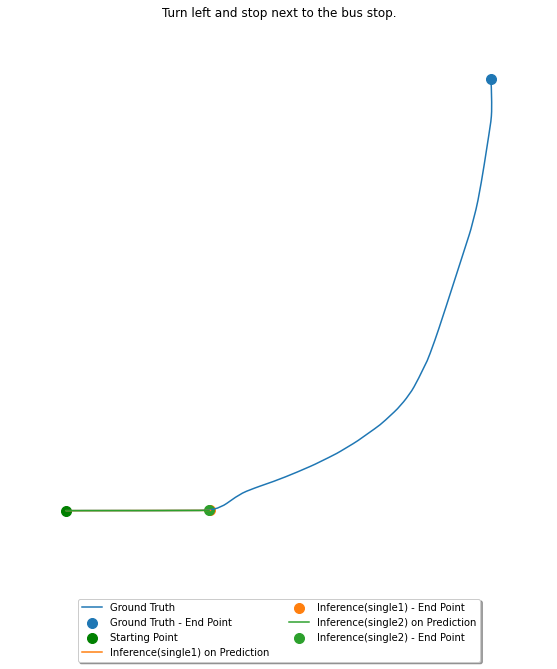

Episode 1: Take a left from the interection.
(94, 3) (94, 3)
single1
Frechet Distance: 3.3950793624897226
FDE Distance: 3.3950793624897226
ADE Distance: 3.9007252916866677
ADE Matched Distance: 0.216126517542188
nDTW Distance: 0.9299213210952745
TC Distance: True
(94, 3) (94, 3)
single2
Frechet Distance: 16.171223782579855
FDE Distance: 16.17122378257985
ADE Distance: 10.874007807195868
ADE Matched Distance: 2.116509917196106
nDTW Distance: 0.2733710563559246
TC Distance: False


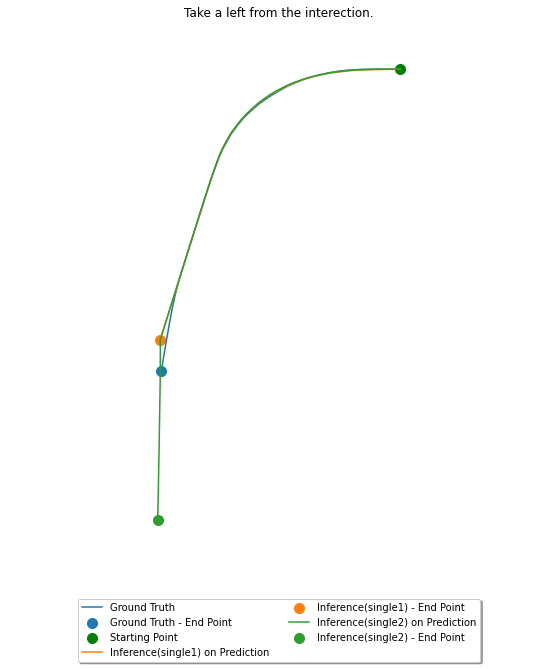

Episode 2: Drive straight till you see a red coloured board
(55, 3) (55, 3)
single1
Frechet Distance: 5.354095466204557
FDE Distance: 5.354095466204557
ADE Distance: 2.3301572422601997
ADE Matched Distance: 0.6973424614130732
nDTW Distance: 0.7228299981675352
TC Distance: False
(55, 3) (55, 3)
single2
Frechet Distance: 11.298828135695478
FDE Distance: 11.298828135695478
ADE Distance: 7.166501146363264
ADE Matched Distance: 1.6475988108095483
nDTW Distance: 0.3203500430351114
TC Distance: False


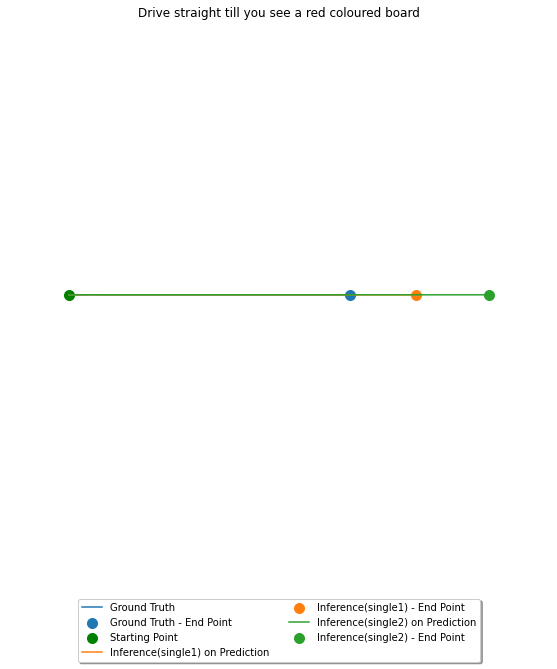

Episode 3: Park just ahead of the speed signboard
(38, 3) (38, 3)
single1
Frechet Distance: 30.313087524423736
FDE Distance: 30.313087524423736
ADE Distance: 31.830682472689574
ADE Matched Distance: 26.330173801129888
nDTW Distance: 8.180192822362128e-62
TC Distance: False
(38, 3) (38, 3)
single2
Frechet Distance: 29.153907403979158
FDE Distance: 29.153907403979158
ADE Distance: 9.463675398249578
ADE Matched Distance: 6.540627863225767
nDTW Distance: 0.0024193351557130318
TC Distance: False


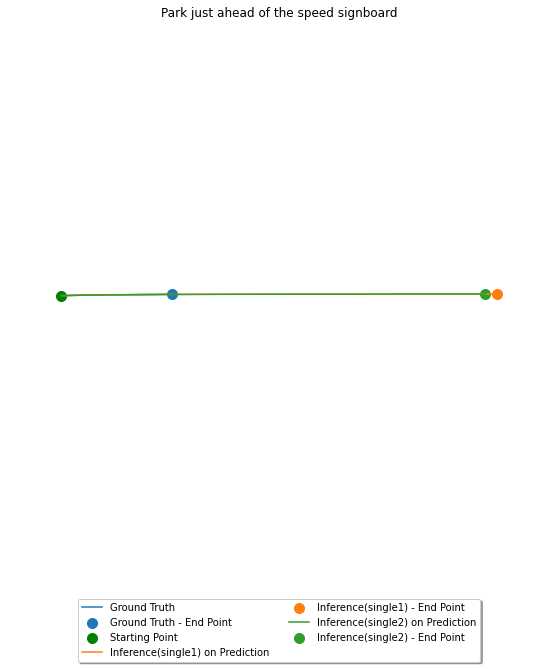

Episode 4: Take the next right turn.
(332, 3) (332, 3)
single1
Frechet Distance: 6.956138053006804
FDE Distance: 6.956138053006805
ADE Distance: 10.327366467942314
ADE Matched Distance: 1.901860948886671
nDTW Distance: 0.3344430745345118
TC Distance: False
(332, 3) (332, 3)
single2
Frechet Distance: 113.89763583955936
FDE Distance: 25.548743810457246
ADE Distance: 60.39944343983322
ADE Matched Distance: 44.12352294421359
nDTW Distance: 1.94610063708501e-24
TC Distance: False


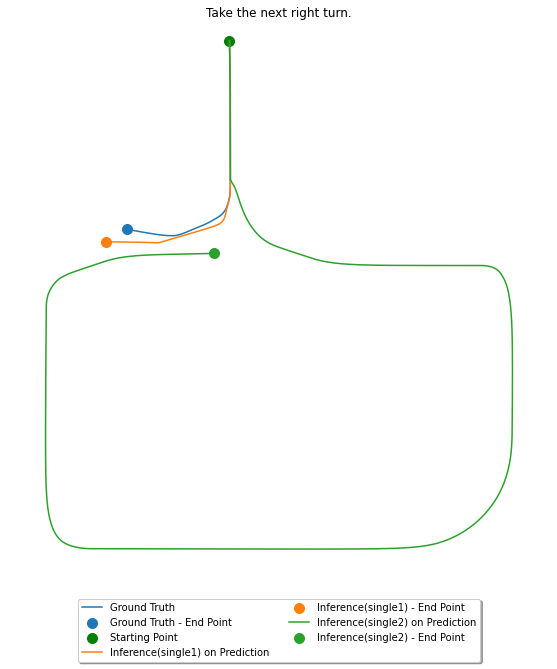

Episode 5: Drive straight from the next crossroads.
(150, 3) (150, 3)
single1
Frechet Distance: 38.896470075200746
FDE Distance: 38.896470075200746
ADE Distance: 21.41000810583244
ADE Matched Distance: 6.925657307028575
nDTW Distance: 0.024880176997677354
TC Distance: False
(150, 3) (150, 3)
single2
Frechet Distance: 40.14347682600247
FDE Distance: 40.14347682600247
ADE Distance: 19.369447292714504
ADE Matched Distance: 7.603552846970197
nDTW Distance: 0.15961497760360024
TC Distance: False


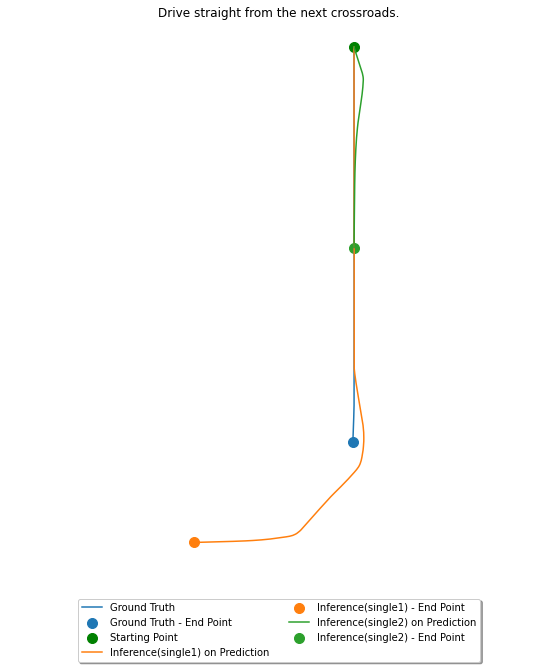

Episode 6: change to left lane
(70, 3) (70, 3)
single1
Frechet Distance: 8.1295453586907
FDE Distance: 8.1295453586907
ADE Distance: 6.0024510985196455
ADE Matched Distance: 2.6706243285569156
nDTW Distance: 0.1880499247633928
TC Distance: False
(70, 3) (70, 3)
single2
Frechet Distance: 3.8283031943167587
FDE Distance: 3.740088539897062
ADE Distance: 4.709255991568213
ADE Matched Distance: 2.0003361769594328
nDTW Distance: 0.359504324258018
TC Distance: True


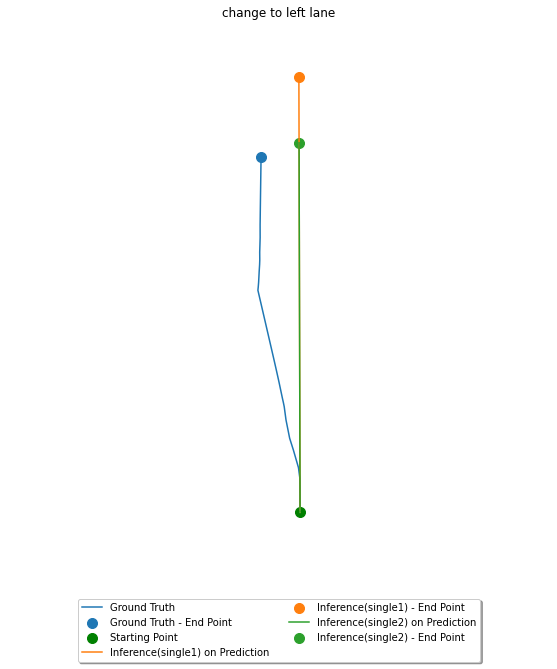

Episode 7: Stop near the scooty
(42, 3) (42, 3)
single1
Frechet Distance: 33.46100819481557
FDE Distance: 33.46100819481557
ADE Distance: 15.497107440656206
ADE Matched Distance: 9.947970150875705
nDTW Distance: 6.35462587976763e-05
TC Distance: False
(42, 3) (42, 3)
single2
Frechet Distance: 33.46754883676372
FDE Distance: 33.46754883676372
ADE Distance: 18.137983826919005
ADE Matched Distance: 10.090289679408507
nDTW Distance: 5.2744835952168824e-05
TC Distance: False


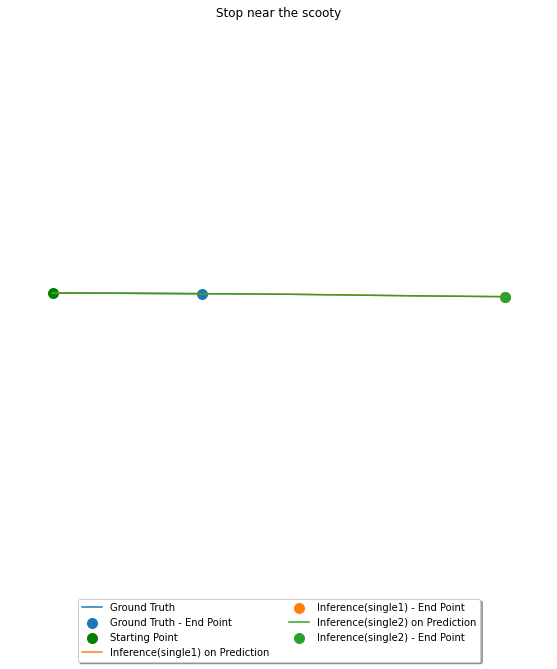

Episode 8: take right and stop near the speed limit sign
(142, 3) (142, 3)
single1
Frechet Distance: 11.239072208243467
FDE Distance: 11.239072208243467
ADE Distance: 5.976077621407588
ADE Matched Distance: 1.8148891499095627
nDTW Distance: 0.5655092852697089
TC Distance: False
(142, 3) (142, 3)
single2
Frechet Distance: 7.60482710413893
FDE Distance: 7.60482710413893
ADE Distance: 6.117020988703295
ADE Matched Distance: 0.7418417708812897
nDTW Distance: 0.825098957058976
TC Distance: False


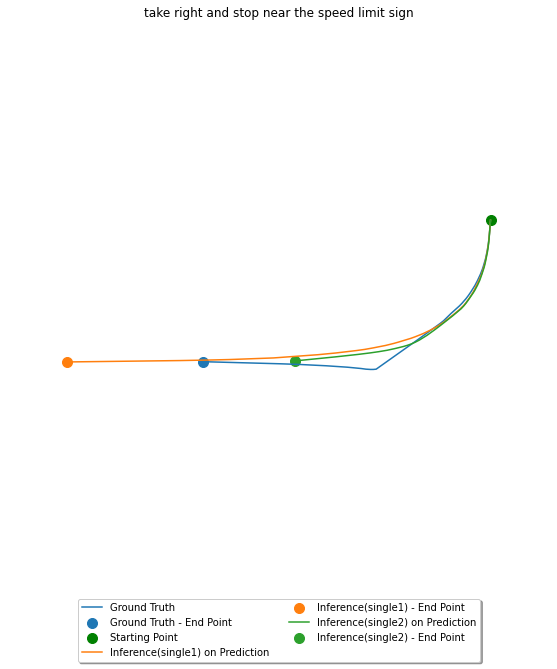

Episode 9: Turn right and stop near the bus stop.
(59, 3) (59, 3)
single1
Frechet Distance: 22.049531414404782
FDE Distance: 22.049531414404782
ADE Distance: 8.20908914016449
ADE Matched Distance: 4.591935619715742
nDTW Distance: 0.05615225493466028
TC Distance: False
(59, 3) (59, 3)
single2
Frechet Distance: 23.633294972027468
FDE Distance: 23.633294972027468
ADE Distance: 9.753023819113128
ADE Matched Distance: 5.424097136341733
nDTW Distance: 0.029840968099597114
TC Distance: False


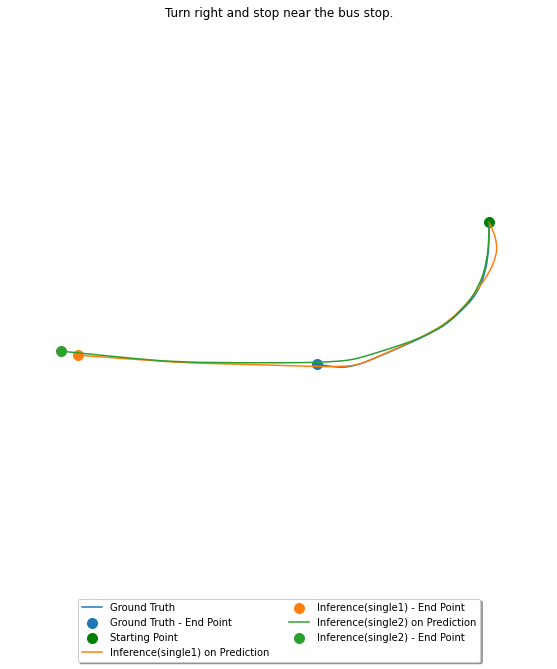

Episode 10: Shift to the left lane and stop at the intersection.
(66, 3) (66, 3)
single1
Frechet Distance: 11.803642747153846
FDE Distance: 11.803642747153846
ADE Distance: 4.501480008061647
ADE Matched Distance: 3.2122101695452008
nDTW Distance: 0.24858815692074698
TC Distance: False
(66, 3) (66, 3)
single2
Frechet Distance: 12.349465105152433
FDE Distance: 12.349465105152433
ADE Distance: 11.51900326282093
ADE Matched Distance: 3.633171534745142
nDTW Distance: 2.2303325438340255e-06
TC Distance: False


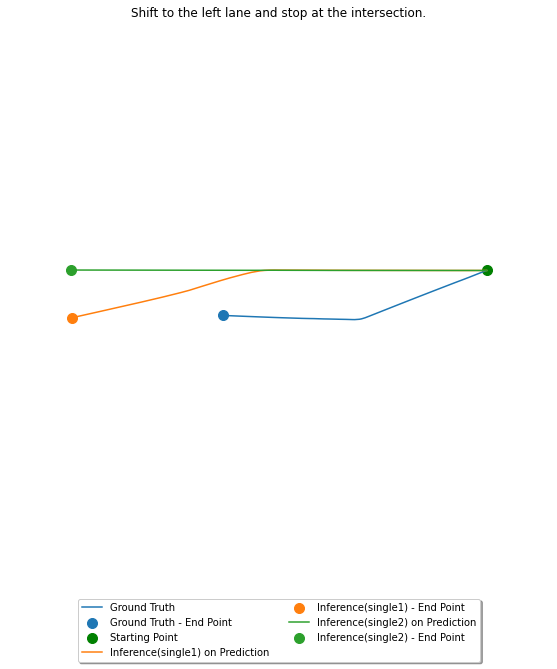

Episode 11: Stop after crossing the stop signboard
(45, 3) (45, 3)
single1
Frechet Distance: 39.66549849910885
FDE Distance: 39.66549849910885
ADE Distance: 15.553978768316703
ADE Matched Distance: 12.574456954661017
nDTW Distance: 5.409439083910247e-06
TC Distance: False
(45, 3) (45, 3)
single2
Frechet Distance: 39.43241260529062
FDE Distance: 39.43241260529062
ADE Distance: 18.532161598920343
ADE Matched Distance: 12.760524802394755
nDTW Distance: 1.8244493346040671e-06
TC Distance: False


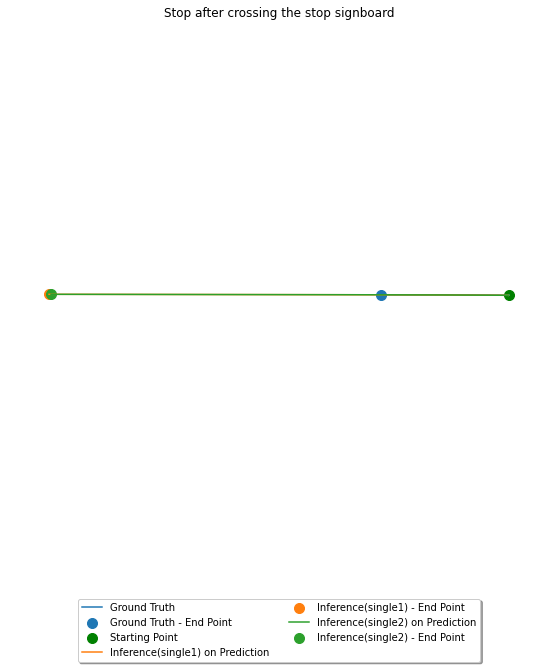

Episode 12: Park near the red signboard
(45, 3) (45, 3)
single1
Frechet Distance: 310.0880541231953
FDE Distance: 284.73696004535026
ADE Distance: 163.9007726834752
ADE Matched Distance: 189.61918416418308
nDTW Distance: 0.0
TC Distance: False
(45, 3) (45, 3)
single2
Frechet Distance: 310.07589040188236
FDE Distance: 89.91042109858485
ADE Distance: 150.6689871065197
ADE Matched Distance: 161.56291822828018
nDTW Distance: 0.0
TC Distance: False


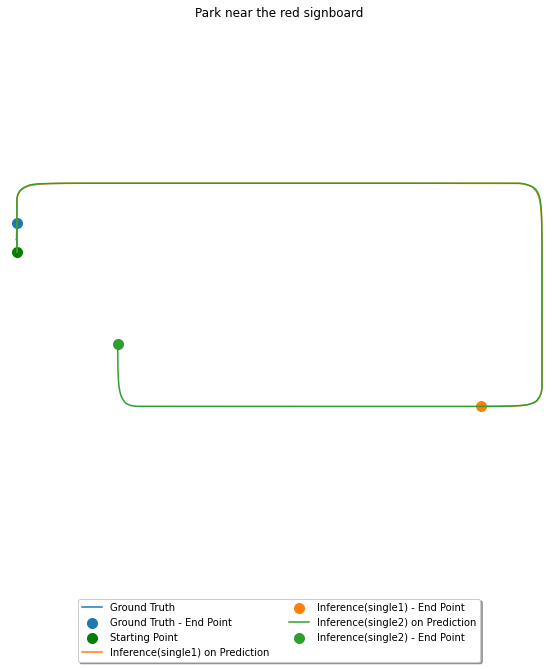

Episode 13: Wait at the traffic light then go straight.
(340, 3) (340, 3)
single1
Frechet Distance: 80.69740298161548
FDE Distance: 80.69740298161548
ADE Distance: 14.24745361213154
ADE Matched Distance: 9.724466675659217
nDTW Distance: 0.007303248111689081
TC Distance: False
(340, 3) (340, 3)
single2
Frechet Distance: 80.96703946660026
FDE Distance: 80.96703946660026
ADE Distance: 18.087100252147998
ADE Matched Distance: 10.237986067431224
nDTW Distance: 0.02223423903867471
TC Distance: False


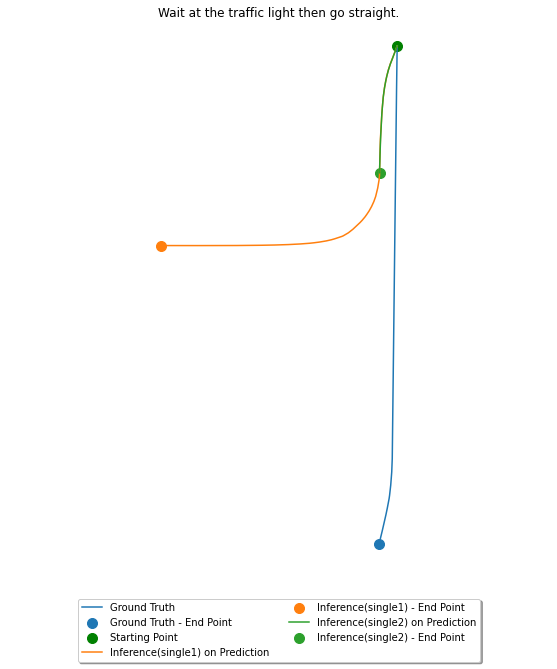

Episode 14: Drive straight till the intersection and then turn left
(73, 3) (73, 3)
single1
Frechet Distance: 10.580051566496694
FDE Distance: 10.580051566496694
ADE Distance: 8.05333815167504
ADE Matched Distance: 0.19848433130020052
nDTW Distance: 0.728704233469688
TC Distance: False
(73, 3) (73, 3)
single2
Frechet Distance: 22.195805230684616
FDE Distance: 22.195805230684616
ADE Distance: 7.680502065625596
ADE Matched Distance: 1.4676504241095067
nDTW Distance: 0.06520416805621106
TC Distance: False


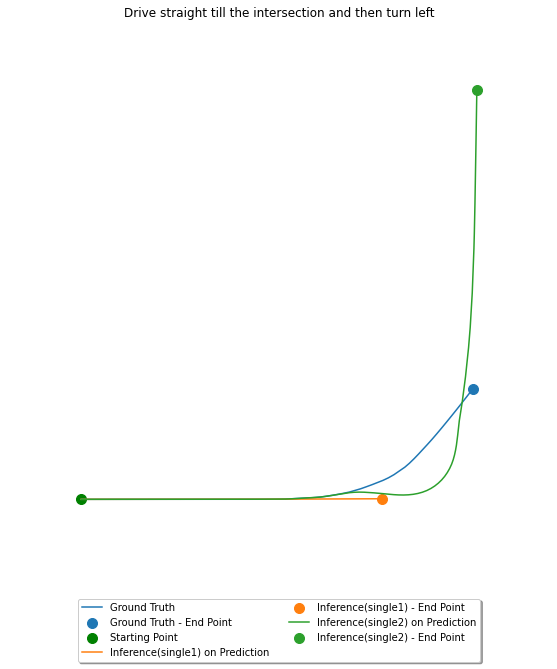

Episode 15: go straight and take a left
(218, 3) (218, 3)
single1
Frechet Distance: 32.33433189948215
FDE Distance: 32.33433189948215
ADE Distance: 17.670312377432143
ADE Matched Distance: 6.64224214938568
nDTW Distance: 0.26488793482863554
TC Distance: False
(213, 3) (213, 3)
single2
Frechet Distance: 32.352277946279045
FDE Distance: 32.352277946279045
ADE Distance: 19.505768532508117
ADE Matched Distance: 6.665514052701512
nDTW Distance: 0.26365791026865426
TC Distance: False


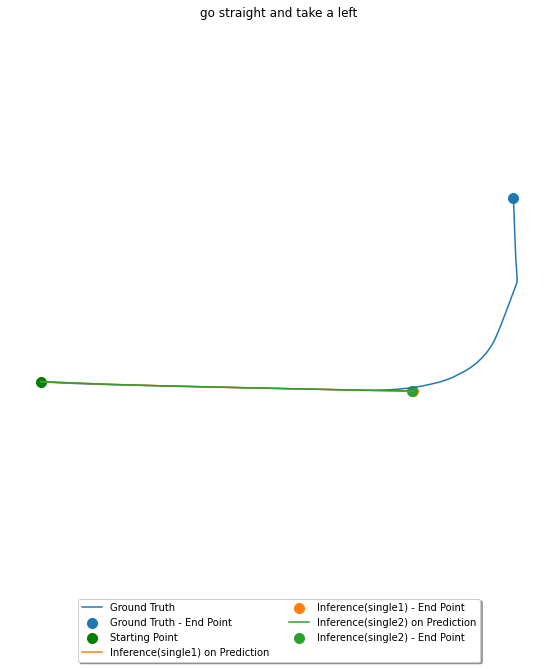

Episode 16: Stop as soon as you encounter a white car
(47, 3) (47, 3)
single1
Frechet Distance: 34.3534916190603
FDE Distance: 34.3534916190603
ADE Distance: 18.81537972884326
ADE Matched Distance: 9.139625211223766
nDTW Distance: 2.646366204587147e-05
TC Distance: False
(47, 3) (47, 3)
single2
Frechet Distance: 51.98011295782507
FDE Distance: 51.98011295782507
ADE Distance: 23.960073224916417
ADE Matched Distance: 16.01304714843384
nDTW Distance: 1.4179591422452443e-09
TC Distance: False


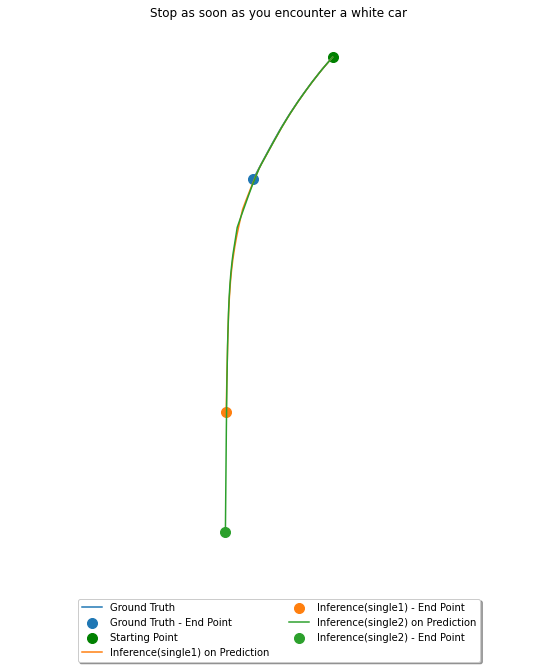

Episode 17: take a right at the intersection
(105, 3) (105, 3)
single1
Frechet Distance: 14.096172347447013
FDE Distance: 14.096172347447013
ADE Distance: 6.872877684472174
ADE Matched Distance: 2.4053858372432257
nDTW Distance: 0.3299651194361639
TC Distance: False
(105, 3) (105, 3)
single2
Frechet Distance: 13.97193151173686
FDE Distance: 13.97193151173686
ADE Distance: 7.004061380317631
ADE Matched Distance: 2.68735503394982
nDTW Distance: 0.34837808855770147
TC Distance: False


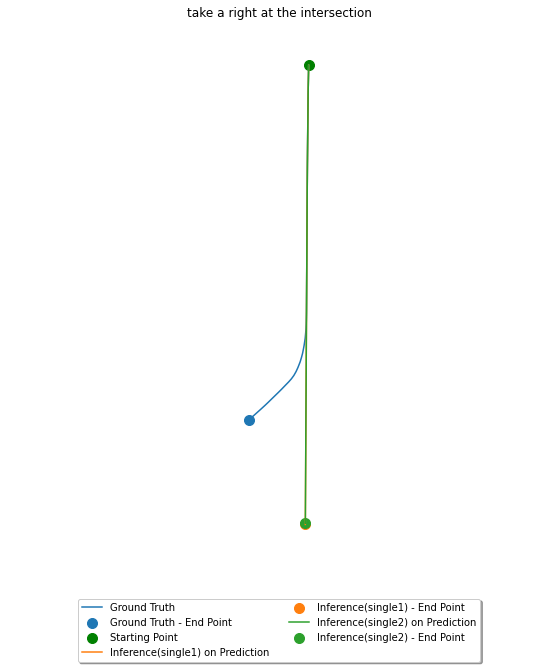

Episode 18: Stop near the red shelters
(44, 3) (44, 3)
single1
Frechet Distance: 15.461216808115623
FDE Distance: 15.461216808115621
ADE Distance: 18.493375679146375
ADE Matched Distance: 10.159883561145415
nDTW Distance: 3.2612197227249334e-10
TC Distance: False
(44, 3) (44, 3)
single2
Frechet Distance: 110.55743889514474
FDE Distance: 33.875854150324145
ADE Distance: 74.49148999135075
ADE Matched Distance: 68.82691454558483
nDTW Distance: 0.0
TC Distance: False


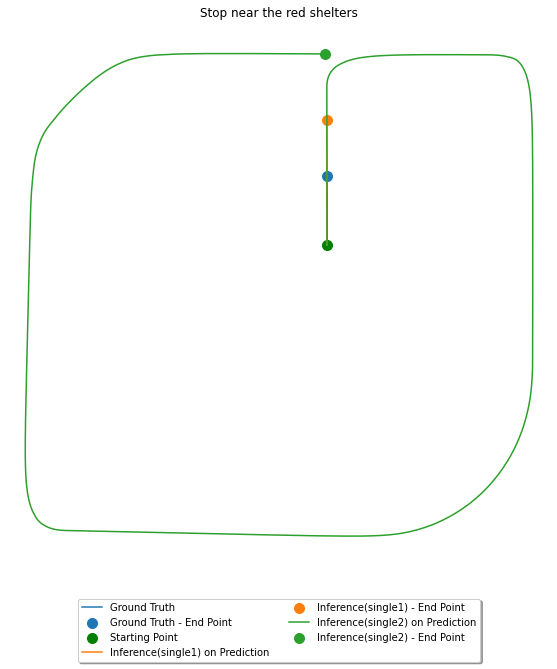

Episode 19: Turn left from the intersection
(127, 3) (127, 3)
single1
Frechet Distance: 29.240287603706424
FDE Distance: 29.240287603706424
ADE Distance: 8.984007728794248
ADE Matched Distance: 2.2362251336839787
nDTW Distance: 0.08176812127070594
TC Distance: False
(127, 3) (127, 3)
single2
Frechet Distance: 13.036656417593958
FDE Distance: 13.036656417593958
ADE Distance: 7.4667114768779435
ADE Matched Distance: 0.6352350707945732
nDTW Distance: 0.4680028120714772
TC Distance: False


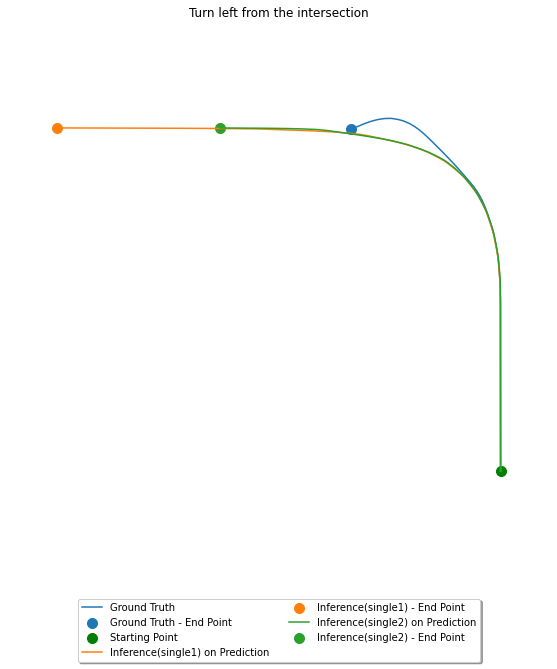

Episode 20: Drive straight then turn right
(127, 3) (127, 3)
single1
Frechet Distance: 94.08550201656539
FDE Distance: 14.75009654858232
ADE Distance: 75.5710420823729
ADE Matched Distance: 55.783715934599435
nDTW Distance: 3.819117649817487e-115
TC Distance: False
(127, 3) (127, 3)
single2
Frechet Distance: 1.4233958542039074
FDE Distance: 1.4233958542039071
ADE Distance: 3.681940281027851
ADE Matched Distance: 0.1673971136680656
nDTW Distance: 0.9099414104557649
TC Distance: True


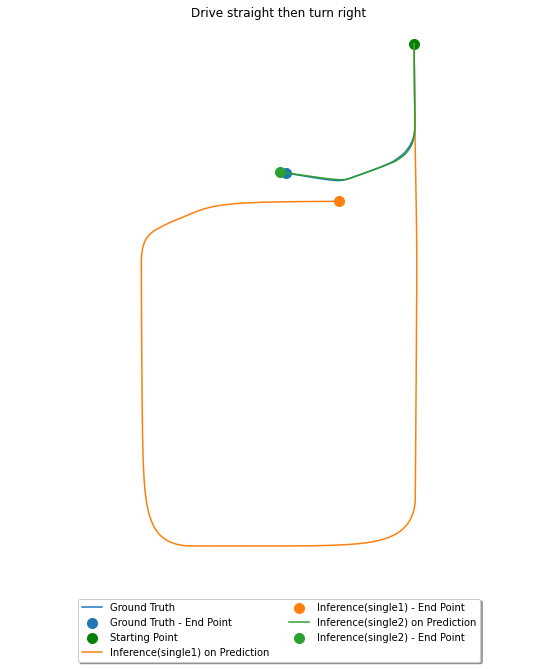

Episode 21: Park near the hut visible on the right
(36, 3) (36, 3)
single1
Frechet Distance: 13.464426404942342
FDE Distance: 13.464426404942342
ADE Distance: 12.788040759581014
ADE Matched Distance: 8.032874555282016
nDTW Distance: 3.0490059637283872e-05
TC Distance: False
(36, 3) (36, 3)
single2
Frechet Distance: 52.47992850941439
FDE Distance: 52.47992850941439
ADE Distance: 20.13581124546185
ADE Matched Distance: 17.996968590721387
nDTW Distance: 1.2961717501048646e-20
TC Distance: False


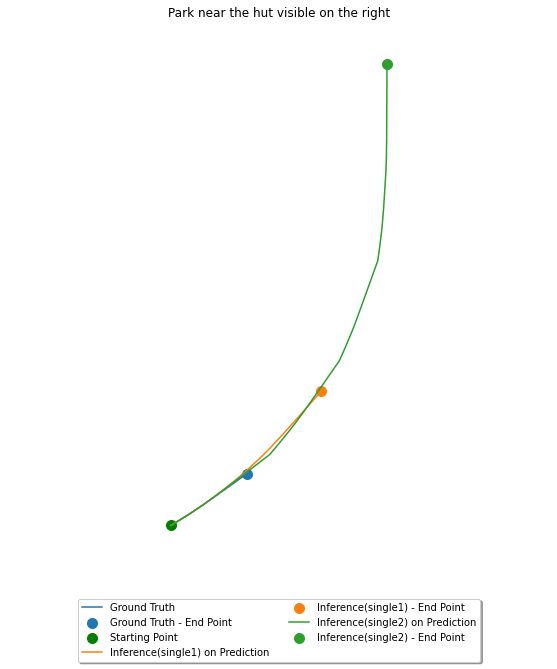

Episode 22: Go straight and stop before the traffic light.
(170, 3) (170, 3)
single1
Frechet Distance: 68.91293690028174
FDE Distance: 68.91293690028174
ADE Distance: 32.40032835776799
ADE Matched Distance: 17.94666277957374
nDTW Distance: 0.01810427873844903
TC Distance: False
(170, 3) (170, 3)
single2
Frechet Distance: 68.93315908659442
FDE Distance: 68.93315908659442
ADE Distance: 33.12448121708361
ADE Matched Distance: 18.765358282903776
nDTW Distance: 0.01839056588210507
TC Distance: False


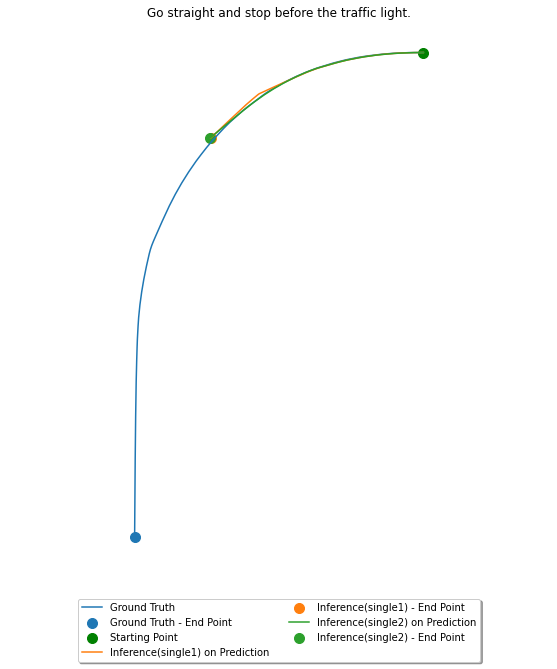

Episode 23: stop at the bus stand in front
(136, 3) (136, 3)
single1
Frechet Distance: 8.423905816993608
FDE Distance: 8.423905816993608
ADE Distance: 12.804575907852804
ADE Matched Distance: 0.22875294620035042
nDTW Distance: 0.8443316596456222
TC Distance: False
(136, 3) (136, 3)
single2
Frechet Distance: 8.42554513891993
FDE Distance: 8.425545138919928
ADE Distance: 9.535565746531688
ADE Matched Distance: 0.229865807242051
nDTW Distance: 0.8459214383535605
TC Distance: False


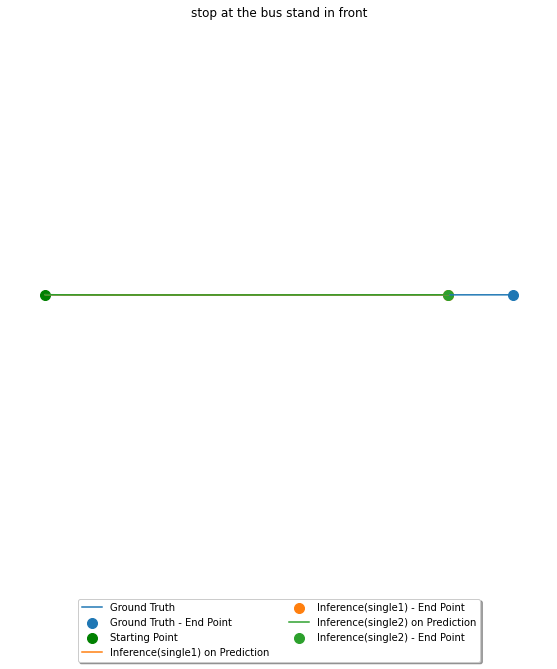

Episode 24: Turn right from the intersection.
(66, 3) (66, 3)
single1
Frechet Distance: 38.47114119139102
FDE Distance: 38.47114119139102
ADE Distance: 26.143395254286144
ADE Matched Distance: 16.273724421794803
nDTW Distance: 1.993780733248556e-26
TC Distance: False
(66, 3) (66, 3)
single2
Frechet Distance: 10.058122764656572
FDE Distance: 10.058122764656572
ADE Distance: 5.126848644348783
ADE Matched Distance: 1.1952035877509295
nDTW Distance: 0.40143850456201785
TC Distance: False


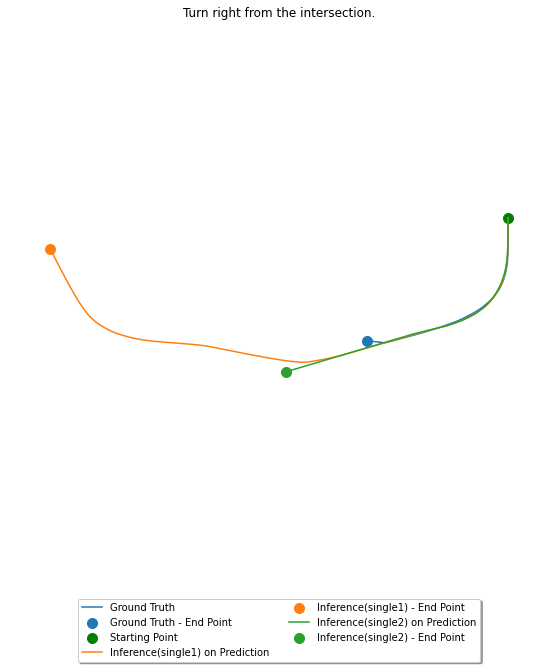

In [96]:
val_data_path = '/ssd_scratch/cvit/varunc/carla_data/val/'
val_run_paths = ['/ssd_scratch/cvit/varunc/new_vals/val_clipsingle/','/ssd_scratch/cvit/varunc/new_vals/val_clipsingle2/']
names = ['single1','single2']
save_loc = '../trajectories_temp/'

frechet_temp_all,fde_temp_all,ade_temp_all, ade_matched_temp_all, ndtw_temp_all, tc_temp_clip_all = get_scores_comp(val_data_path, val_run_paths,names, save_loc,episodes=list(range(25)))

CLIP-single1    0.056152
CLIP-single2    0.065204
RNR-con         0.535384
RNR             0.043633
dtype: float64


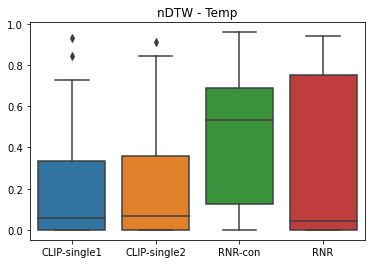

In [100]:
n_df = pd.DataFrame({
    'CLIP-single1':(ndtw_temp_all[0::2]),
    'CLIP-single2':(ndtw_temp_all[1::2]),
    
    'RNR-con':(ndtw_val_all[4::6]),
    'RNR':(ndtw_val_all[5::6]),
    })
g = sns.boxplot(data=n_df)
# g.set_yscale("log")
# g.set_ylim([-5,60])
plt.title('nDTW - Temp')
print(n_df.median())